# Vitals Analysis Notebook

## Purpose
This notebook analyzes vital signs data to identify and characterize distinct health states, 
enabling population health monitoring and risk stratification.

## Structure
1. **Setup and Data Loading**
   - Import required libraries
   - Configure database connection
   - Query vital signs data
   - Initial data validation

2. **Data Processing**
   - Temporal aggregations (daily, weekly, monthly)
   - Feature cleaning and validation
   - Missing data handling
   - Outlier detection

3. **Feature Engineering**
   - Basic clinical features (shock index, MAP, ROX)
   - Statistical features (mean, std, min, max)
   - Temporal features (time-based patterns)
   - Interaction features (vital sign relationships)

4. **Dimensionality Reduction**
   - PCA transformation
   - UMAP visualization
   - Feature importance analysis
   - Quality validation

5. **Cluster Analysis**
   - Parameter optimization
   - Health state identification
   - Cluster validation
   - Clinical interpretation

6. **Clinical Insights**
   - Health state characterization
   - Population segmentation
   - Risk stratification
   - Temporal patterns

7. **Validation & Documentation**
   - Statistical validation
   - Clinical validation
   - Result documentation
   - Future considerations


## Setup & Initialization

In [3]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from setup_utils import setup_db_connection
engine = setup_db_connection()

In [4]:
### Define vital_query string and load df into pandas

vital_query = f"""
SELECT v.*
FROM mimiciv_derived.vitalsign v
WHERE v.subject_id IN (
    SELECT DISTINCT subject_id
    FROM mimiciv_derived.vitalsign
    LIMIT 100 -- Replace 100 with your desired limit
);"""
vitals_df = pd.read_sql_query(vital_query, engine)

## Data Processing

In [6]:
### Define vital_cols: str[], converting 'charttime' to datetime and index
vital_cols = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'temperature', 'spo2']
vitals_df['charttime'] = pd.to_datetime(vitals_df['charttime'])
vitals_df.set_index('charttime', inplace=True)

In [7]:
### Create daily/weekly/monthly dataframes, using D/W/ME resamples
daily_vitals = vitals_df[vital_cols].resample('D').mean().dropna(subset=vital_cols).reset_index()
weekly_vitals = vitals_df[vital_cols].resample('W').mean().dropna(subset=vital_cols).reset_index()
monthly_vitals = vitals_df[vital_cols].resample('ME').mean().dropna(subset=vital_cols).reset_index()

In [8]:
### plot_vitals_comparison; simple check for early-stage visuals
def plot_vitals_comparison(daily, weekly, monthly, vital_cols):
    """
    Plots Daily, Weekly, and Monthly vitals for all columns in vital_cols.
    """
    plt.figure(figsize=(15, 25))  # Adjust figure size
    plt.suptitle('Vitals Over Time (Combined Plots)', fontsize=16, y=0.98)  # Added `y` for better spacing

    # Colors and styles for readability
    styles = {
        'daily': {'color': 'blue', 'label_suffix': 'Daily', 'linestyle': '-'},
        'weekly': {'color': 'orange', 'label_suffix': 'Weekly', 'linestyle': '--'},
        'monthly': {'color': 'green', 'label_suffix': 'Monthly', 'linestyle': ':'},
    }

    # Loop through each vital column
    for i, col in enumerate(vital_cols):
        # Create a subplot
        ax = plt.subplot(len(vital_cols), 1, i + 1)

        # Define common plot lines to avoid repetition
        for key, data in zip(['daily', 'weekly', 'monthly'], [daily, weekly, monthly]):
            plt.plot(
                data['charttime'],
                data[col],
                label=f"{styles[key]['label_suffix']} {col}",
                color=styles[key]['color'],
                linestyle=styles[key]['linestyle']
            )

        # Titles and labels for each subplot
        ax.set_title(f'{col} Over Time', fontsize=12)  # Define font size explicitly
        ax.set_xlabel('Date')
        ax.set_ylabel(col)
        ax.legend()

    # Improved layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])  # Define a padding area for title
    plt.show()

# plot_vitals_comparison(daily_vitals, weekly_vitals, monthly_vitals, vital_cols)

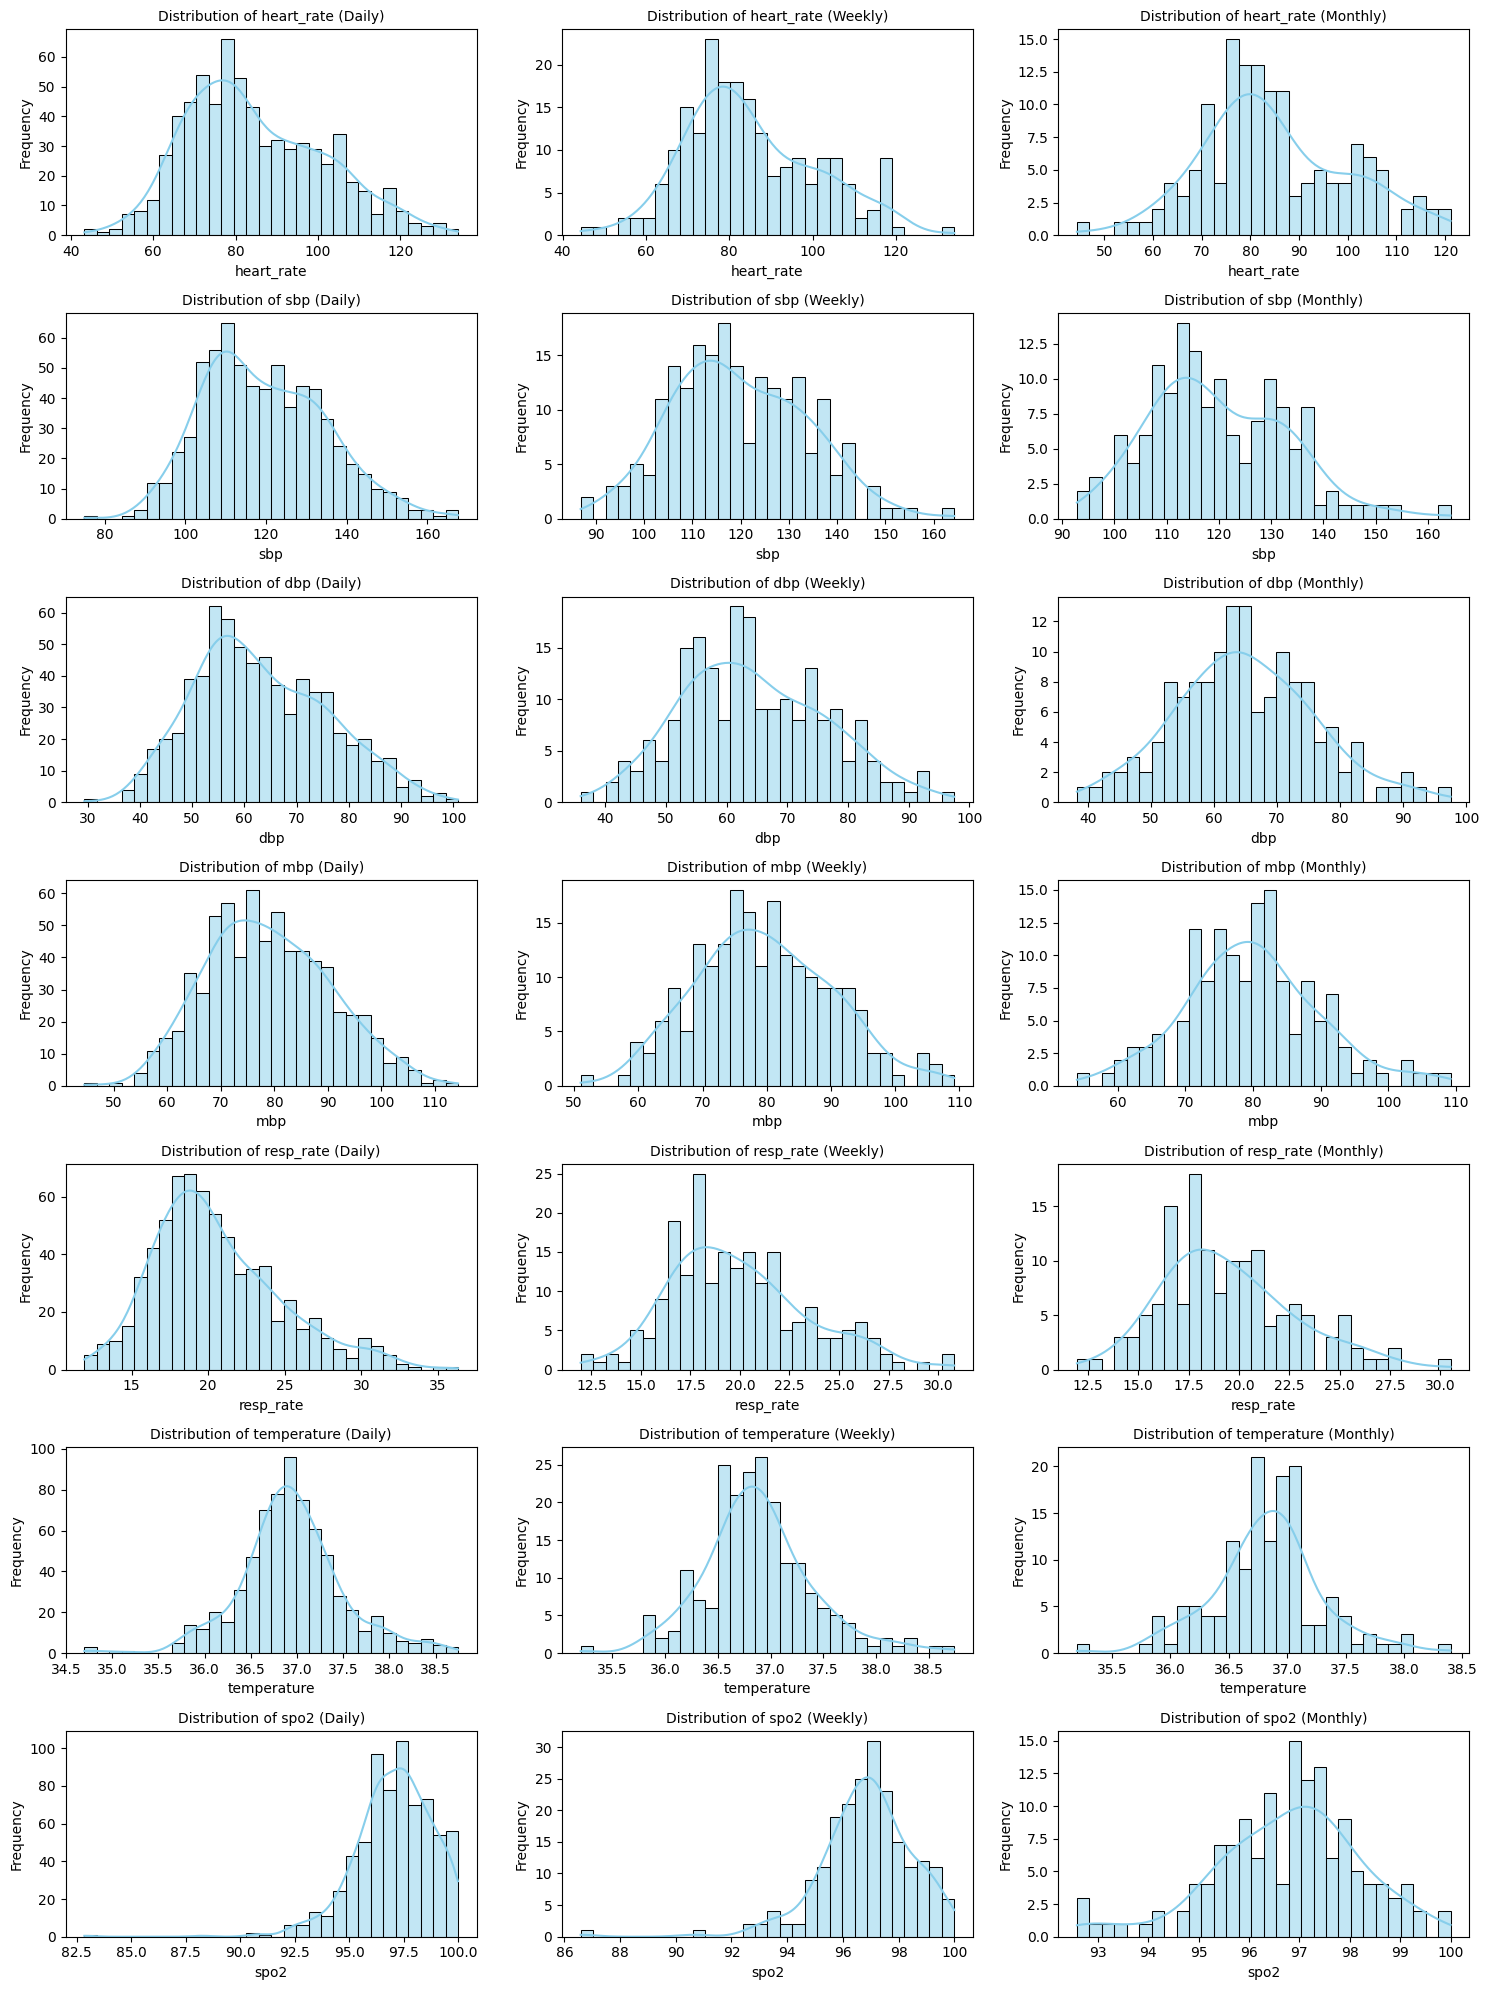

In [9]:
### plot_vital_distributions; iterate over the daily/weekly/monthly dataframes
def plot_vital_distributions(daily, weekly, monthly, vital_cols):
    """
    Shows distributions of vitals over different resampling periods (daily, weekly, monthly).
    """
    data_frames = {'Daily': daily, 'Weekly': weekly, 'Monthly': monthly}
    plt.figure(figsize=(15, 20))

    for i, col in enumerate(vital_cols):
        for j, (period, df) in enumerate(data_frames.items()):
            ax = plt.subplot(len(vital_cols), len(data_frames), i * len(data_frames) + j + 1)
            sns.histplot(df[col], kde=True, ax=ax, bins=30, color='skyblue')
            ax.set_title(f'Distribution of {col} ({period})', fontsize=10)
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

### plot the unchanged, daily/weekly/monthly dataframes
plot_vital_distributions(daily_vitals, weekly_vitals, monthly_vitals, vital_cols)

### Data Quality: Outliers

In [10]:
### remove_outliers_iqr; remove upper and lower quartiles
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [11]:
### apply remove_outliers to previous daily/weekly/monthly dataframes
# Removing outliers from monthly_vitals
daily_vitals_cleaned = remove_outliers_iqr(daily_vitals.copy(), vital_cols)
weekly_vitals_cleaned = remove_outliers_iqr(weekly_vitals.copy(), vital_cols)
monthly_vitals_cleaned = remove_outliers_iqr(monthly_vitals.copy(), vital_cols)

### Plot & Visualize

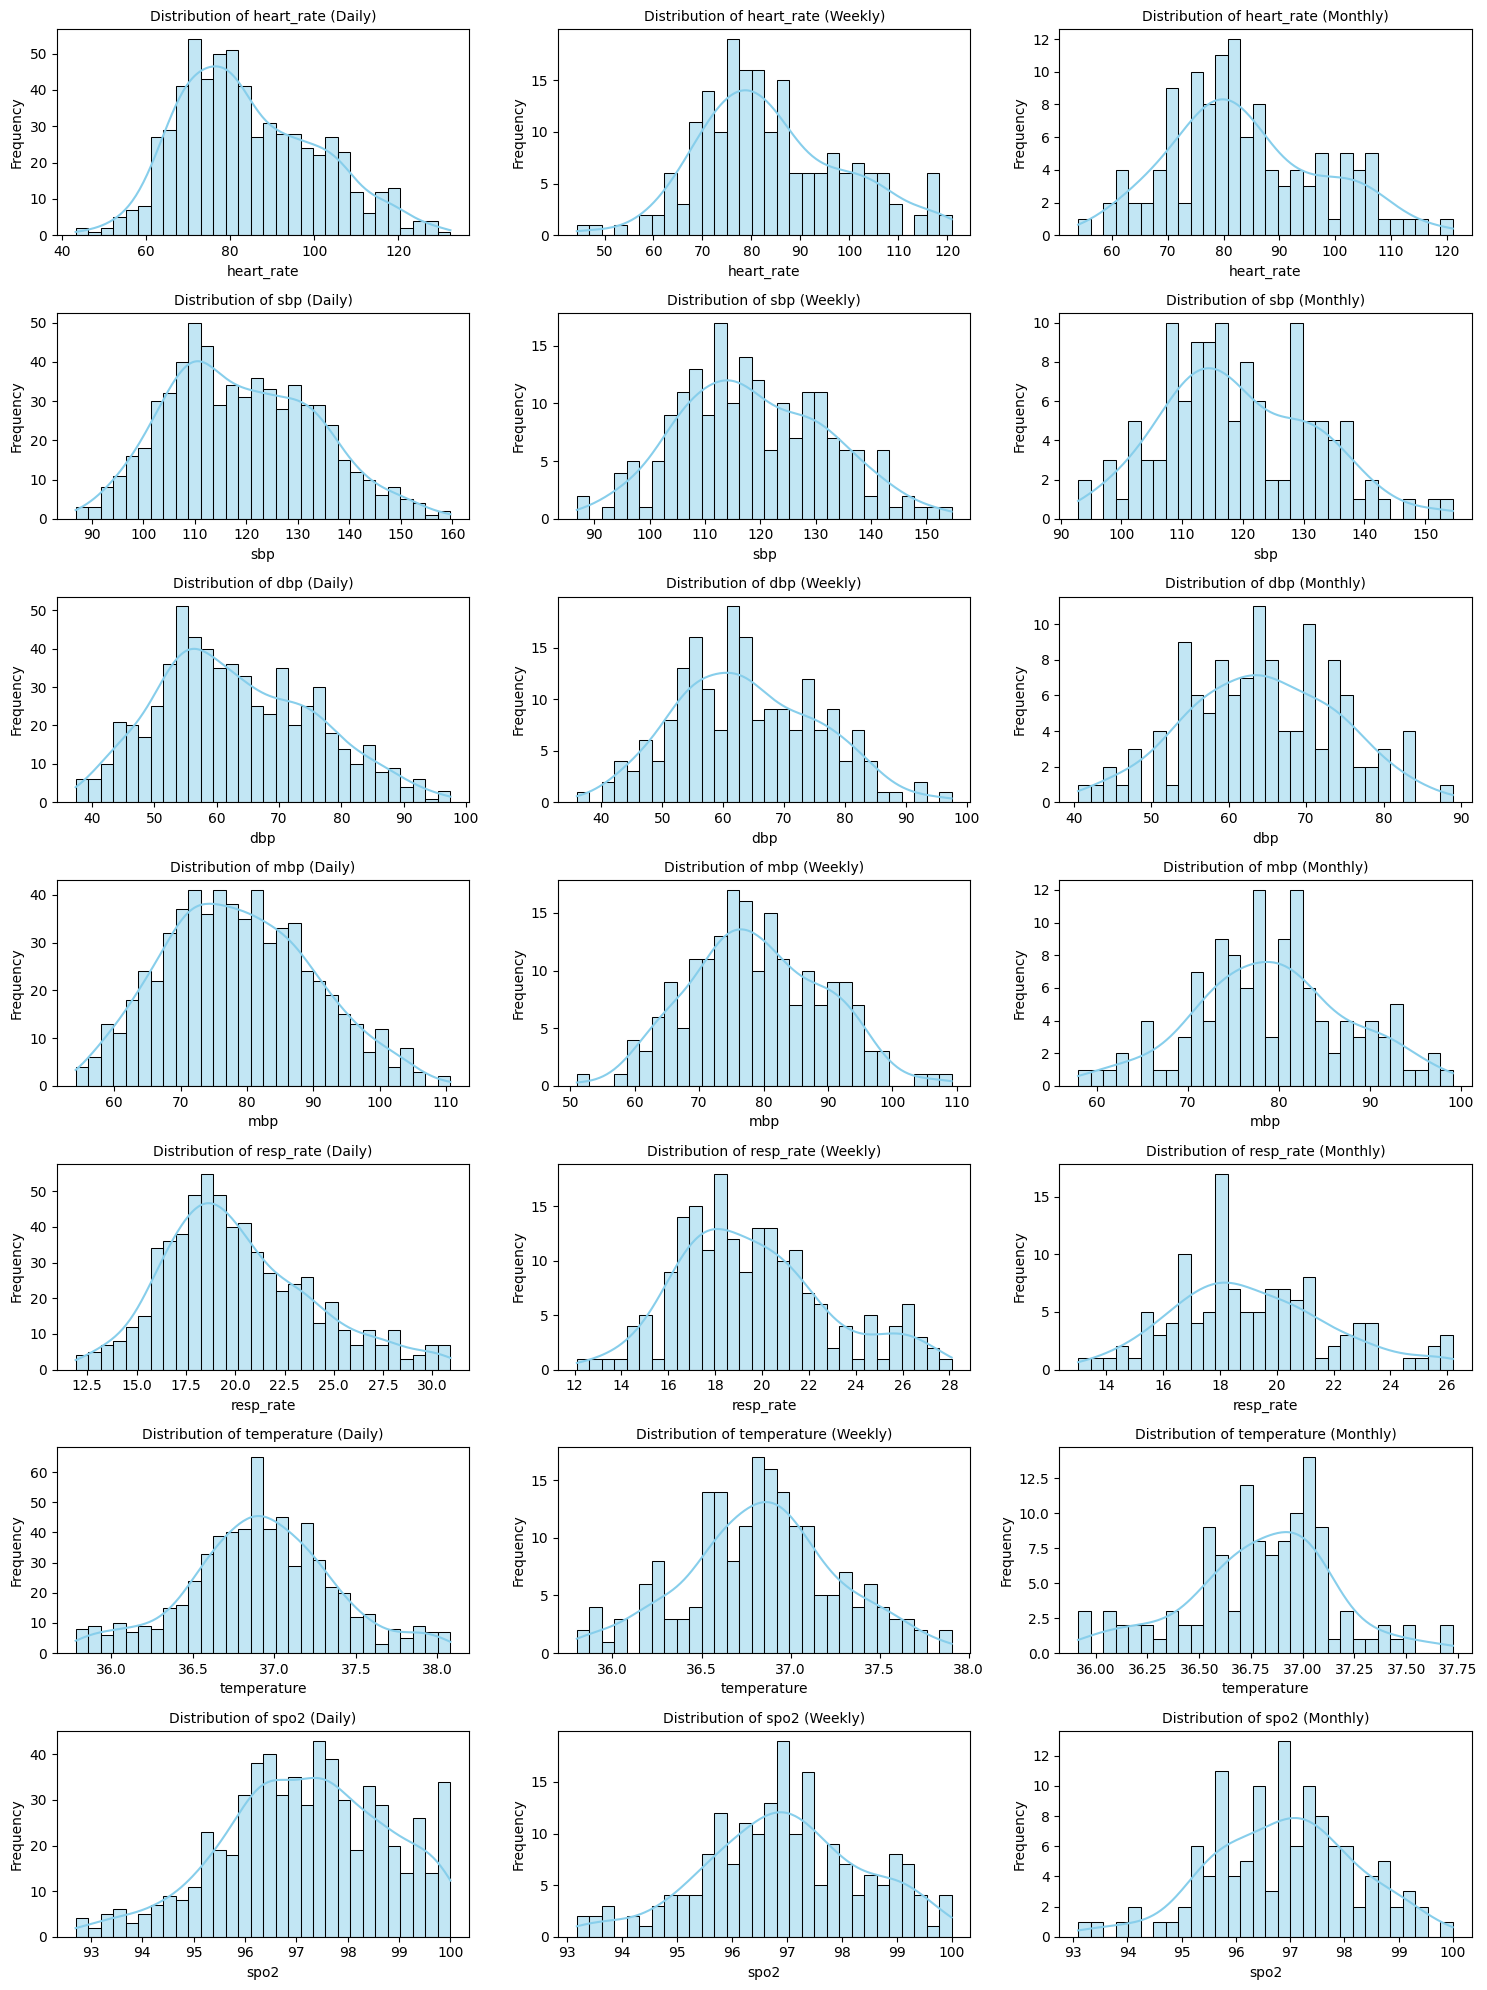

In [12]:
### plot the cleaned daily/weekly/monthly dataframes, after IQR is applied
plot_vital_distributions(daily_vitals_cleaned, weekly_vitals_cleaned, monthly_vitals_cleaned, vital_cols)

In [13]:
### compare_distributions; simple side-by-side comparison of dataframes and target cols
def compare_distributions(original_df, cleaned_df, vital_cols, title_prefix="Monthly", figsize=(15, 20)):
    """
    Compares the distributions of vital columns before and after cleaning for outliers.
    Args:
        original_df (DataFrame): The original dataframe before cleaning.
        cleaned_df (DataFrame): The cleaned dataframe after outlier removal.
        vital_cols (list): List of vital column names to compare.
        title_prefix (str): Prefix for the title (e.g., "Daily", "Weekly", "Monthly").
        figsize (tuple): Size of the plot figure.

    Returns:
        None: Displays a comparison plot of distributions with text output and difference visualizations.
    """
    # Compute and display summary statistics
    for col in vital_cols:
        print(f"\n=== {col} Statistics ({title_prefix}) ===")
        print(f"Original {title_prefix} Mean: {original_df[col].mean():.2f}, Std Dev: {original_df[col].std():.2f}")
        print(f"Cleaned {title_prefix} Mean: {cleaned_df[col].mean():.2f}, Std Dev: {cleaned_df[col].std():.2f}")
        print(f"Reduction in Rows for {col}: {len(original_df) - len(cleaned_df)}")

    # Create a difference DataFrame between original and cleaned data for visualization
    diff_df = original_df[vital_cols].describe() - cleaned_df[vital_cols].describe()

    # Plot distributions before and after cleaning
    data_frames = {f'Original {title_prefix}': original_df, f'Cleaned {title_prefix}': cleaned_df}
    plt.figure(figsize=figsize)

    for i, col in enumerate(vital_cols):
        for j, (period, df) in enumerate(data_frames.items()):
            ax = plt.subplot(len(vital_cols), len(data_frames), i * len(data_frames) + j + 1)
            sns.histplot(df[col], kde=True, ax=ax, bins=30, color='skyblue' if "Original" in period else 'green')
            ax.set_title(f'Distribution of {col} ({period})', fontsize=10)
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Visualize differences in summary metrics
    diff_df.loc[['mean', 'std', '25%', '50%', '75%']].plot(kind='bar', figsize=(10, 6), title="Difference in Metrics After Cleaning")
    plt.ylabel("Difference")
    plt.xlabel("Statistic")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


=== heart_rate Statistics (Daily) ===
Original Daily Mean: 84.75, Std Dev: 16.77
Cleaned Daily Mean: 84.44, Std Dev: 16.54
Reduction in Rows for heart_rate: 65

=== sbp Statistics (Daily) ===
Original Daily Mean: 119.60, Std Dev: 15.17
Cleaned Daily Mean: 119.14, Std Dev: 14.25
Reduction in Rows for sbp: 65

=== dbp Statistics (Daily) ===
Original Daily Mean: 63.27, Std Dev: 12.68
Cleaned Daily Mean: 63.15, Std Dev: 12.50
Reduction in Rows for dbp: 65

=== mbp Statistics (Daily) ===
Original Daily Mean: 78.97, Std Dev: 11.52
Cleaned Daily Mean: 78.75, Std Dev: 11.16
Reduction in Rows for mbp: 65

=== resp_rate Statistics (Daily) ===
Original Daily Mean: 20.58, Std Dev: 4.17
Cleaned Daily Mean: 20.19, Std Dev: 3.82
Reduction in Rows for resp_rate: 65

=== temperature Statistics (Daily) ===
Original Daily Mean: 36.94, Std Dev: 0.56
Cleaned Daily Mean: 36.92, Std Dev: 0.46
Reduction in Rows for temperature: 65

=== spo2 Statistics (Daily) ===
Original Daily Mean: 97.06, Std Dev: 1.81
Cle

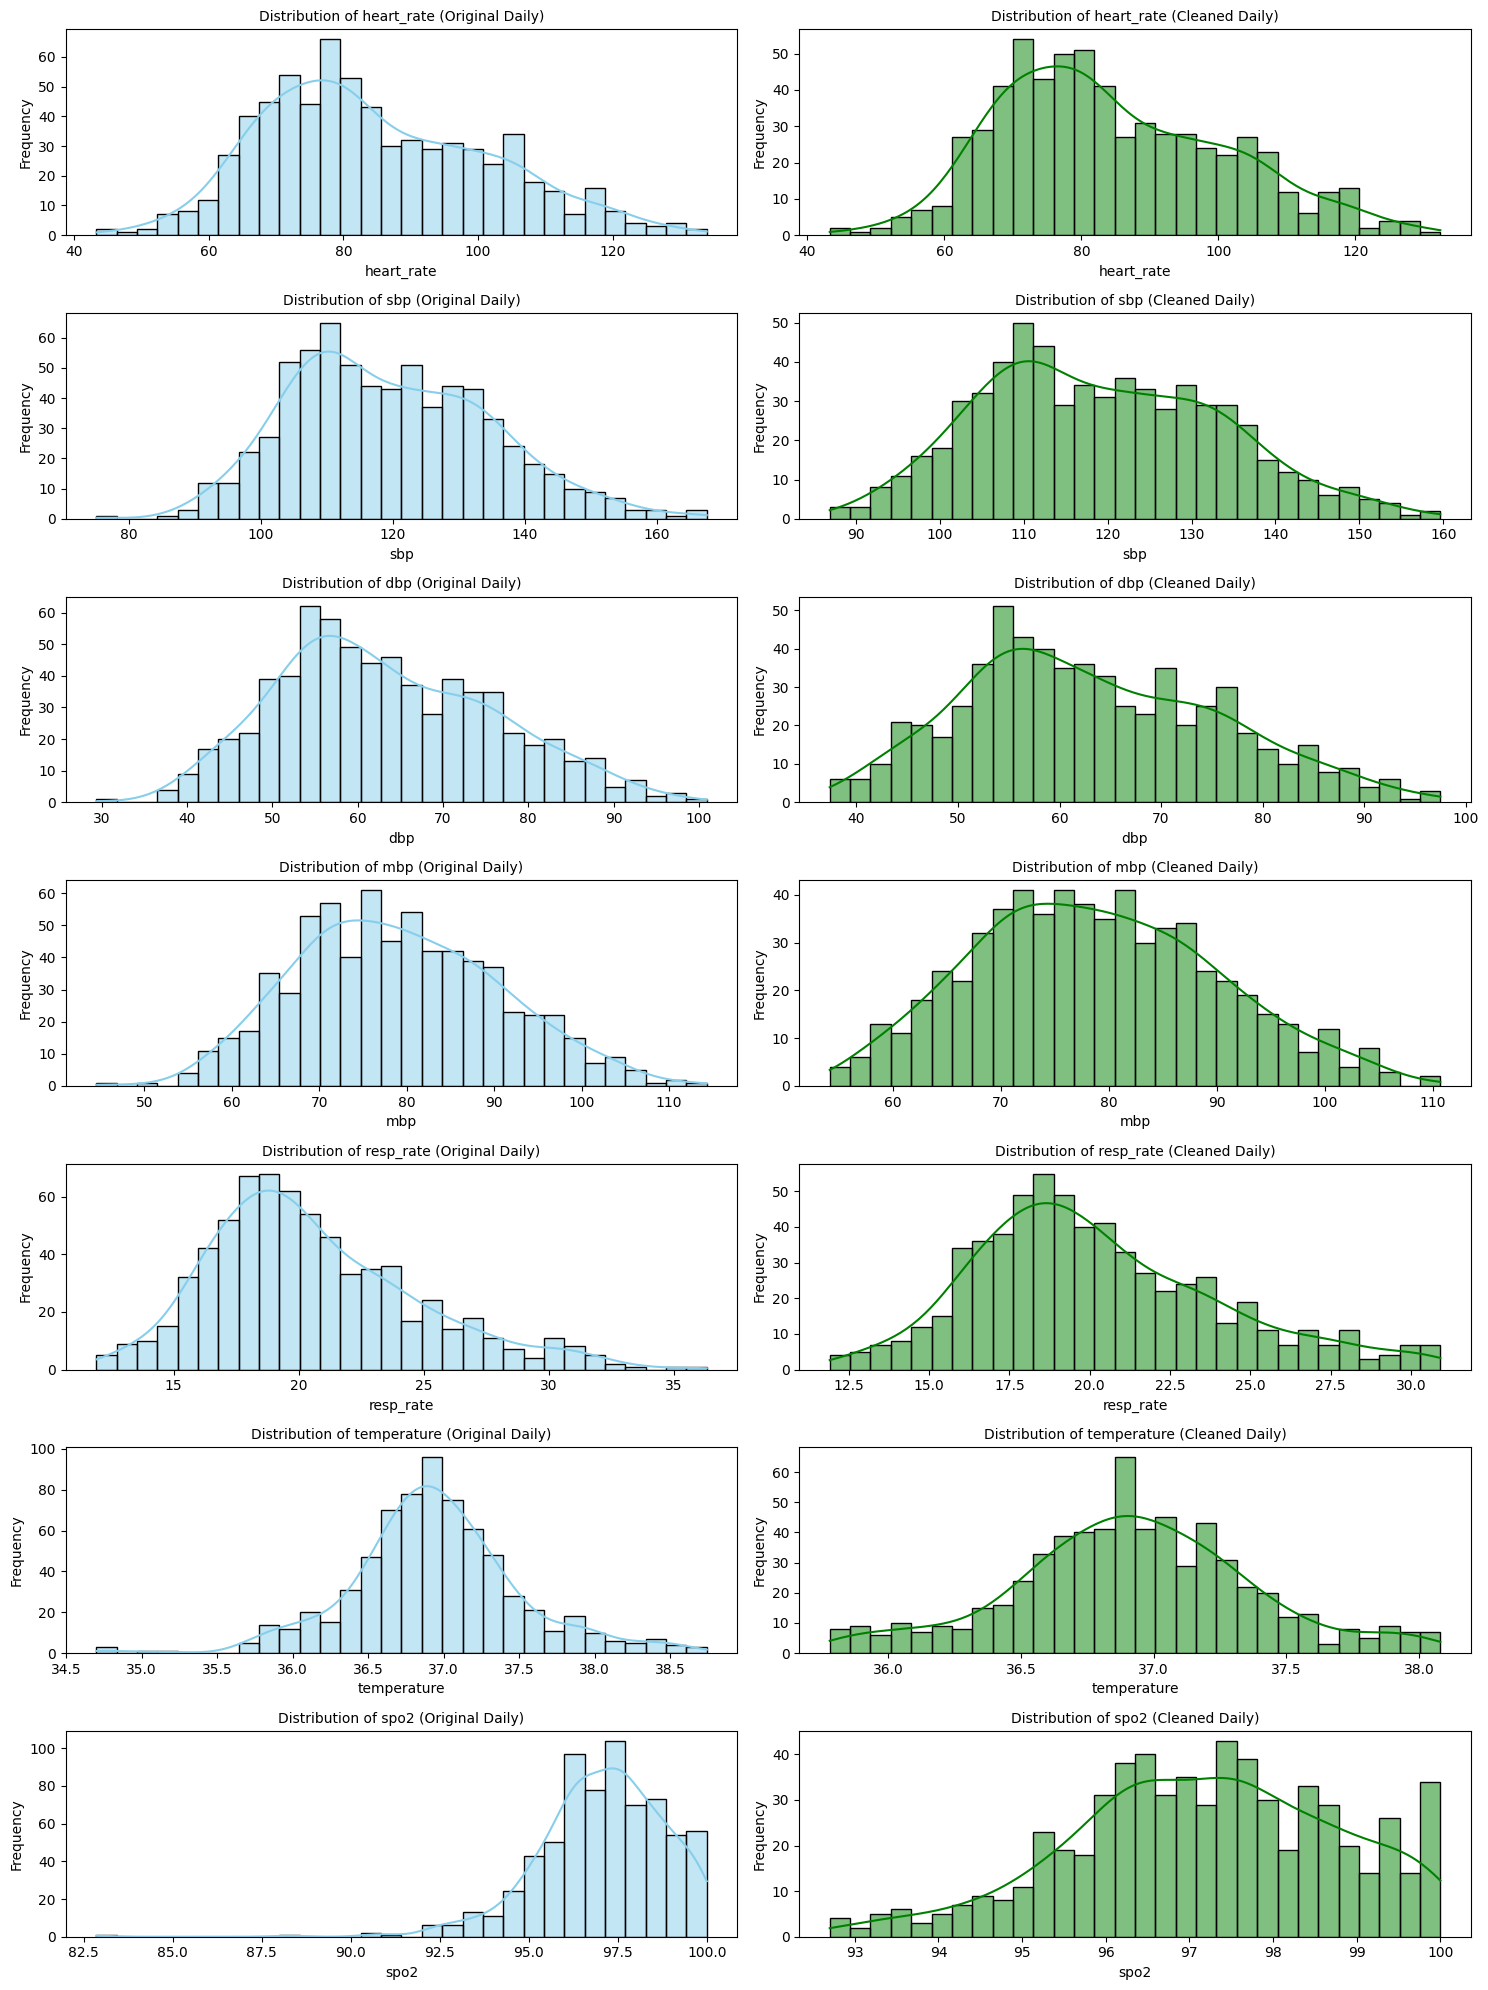

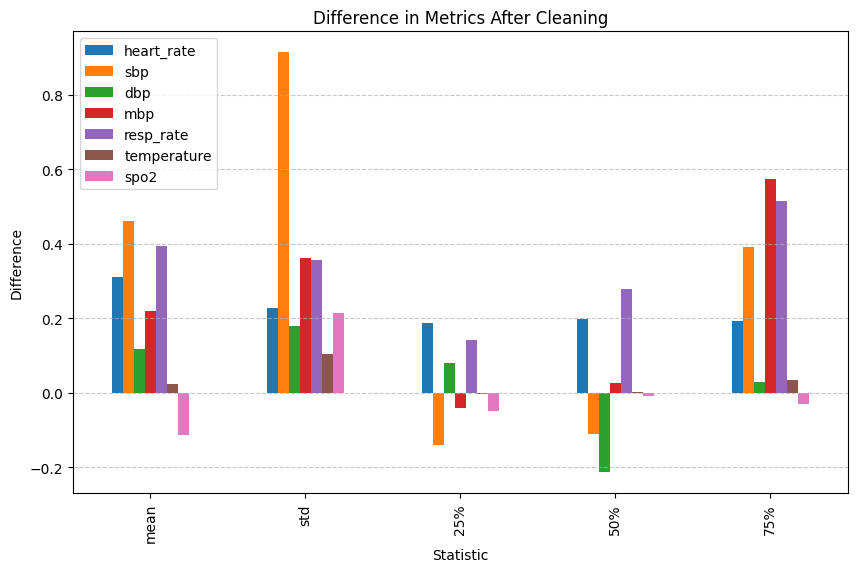

In [14]:
### compare distributions between daily and cleaned daily vitals
compare_distributions(daily_vitals, daily_vitals_cleaned, vital_cols, title_prefix="Daily")


=== heart_rate Statistics (Weekly) ===
Original Weekly Mean: 85.18, Std Dev: 15.73
Cleaned Weekly Mean: 84.26, Std Dev: 14.89
Reduction in Rows for heart_rate: 17

=== sbp Statistics (Weekly) ===
Original Weekly Mean: 119.71, Std Dev: 13.84
Cleaned Weekly Mean: 118.80, Std Dev: 13.41
Reduction in Rows for sbp: 17

=== dbp Statistics (Weekly) ===
Original Weekly Mean: 64.49, Std Dev: 11.83
Cleaned Weekly Mean: 63.91, Std Dev: 11.56
Reduction in Rows for dbp: 17

=== mbp Statistics (Weekly) ===
Original Weekly Mean: 79.63, Std Dev: 10.59
Cleaned Weekly Mean: 79.00, Std Dev: 10.34
Reduction in Rows for mbp: 17

=== resp_rate Statistics (Weekly) ===
Original Weekly Mean: 19.92, Std Dev: 3.48
Cleaned Weekly Mean: 19.62, Std Dev: 3.21
Reduction in Rows for resp_rate: 17

=== temperature Statistics (Weekly) ===
Original Weekly Mean: 36.88, Std Dev: 0.52
Cleaned Weekly Mean: 36.84, Std Dev: 0.43
Reduction in Rows for temperature: 17

=== spo2 Statistics (Weekly) ===
Original Weekly Mean: 96.8

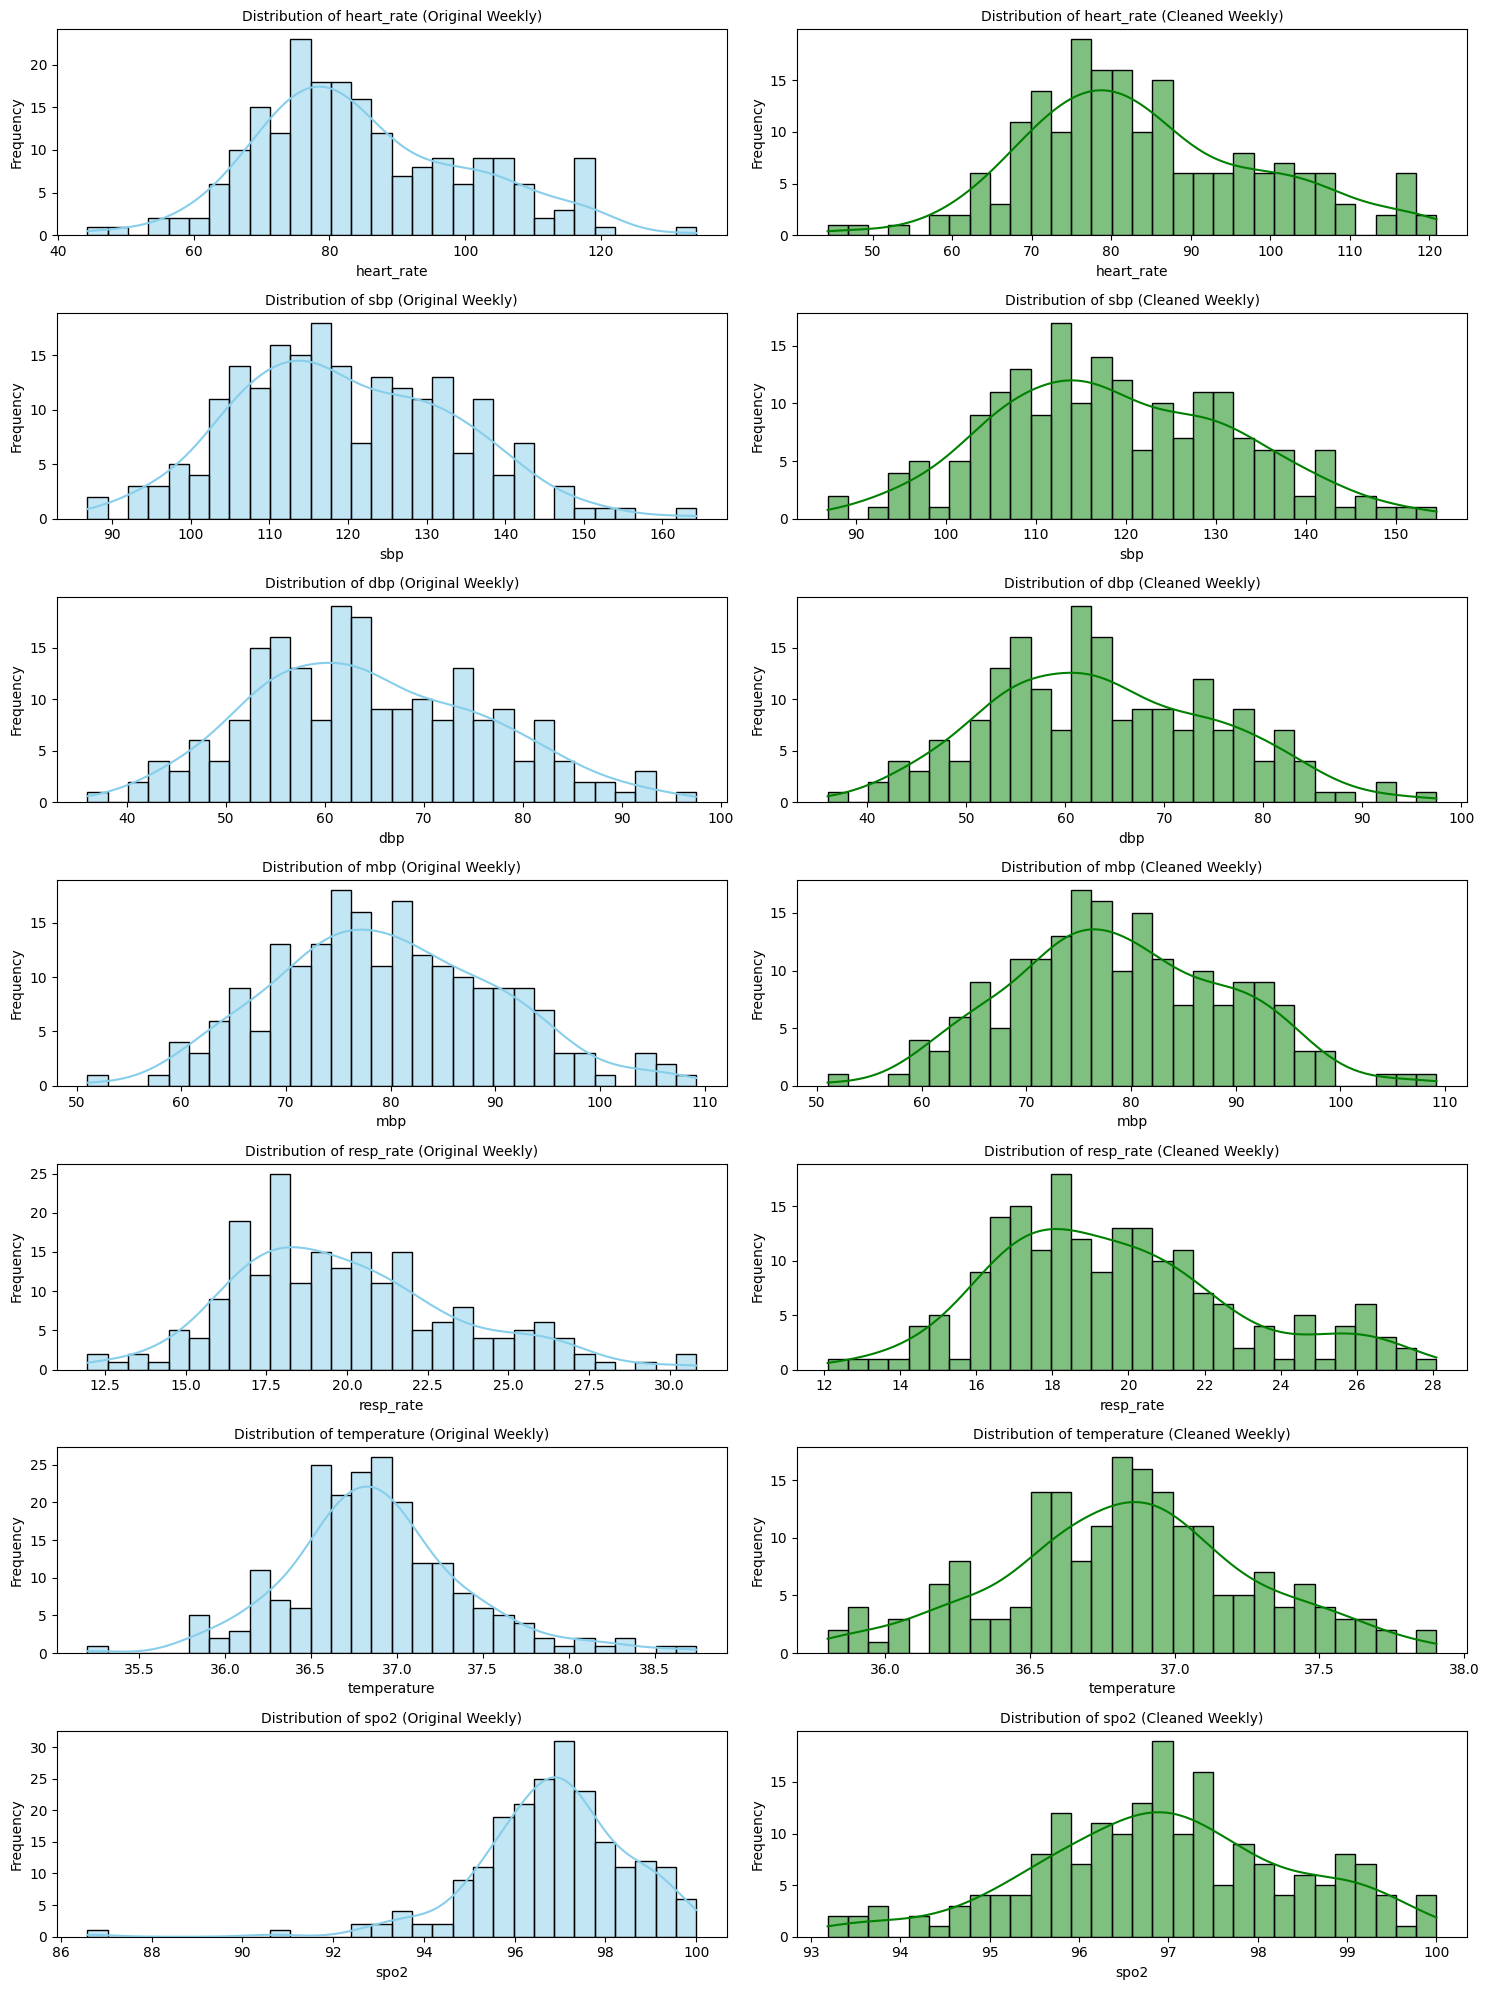

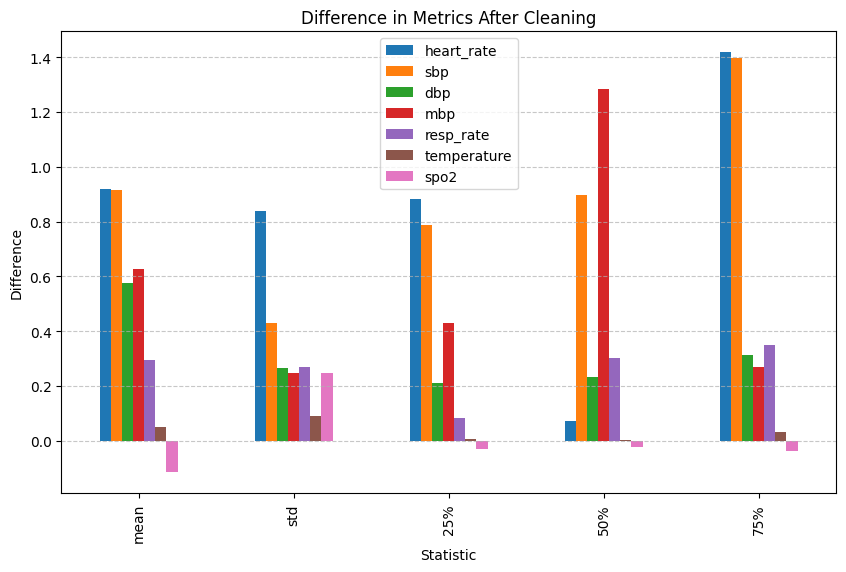

In [15]:
### compare distributions between weekly and cleaned weekly vitals
compare_distributions(weekly_vitals, weekly_vitals_cleaned, vital_cols, title_prefix="Weekly")


=== heart_rate Statistics (Monthly) ===
Original Monthly Mean: 84.77, Std Dev: 14.92
Cleaned Monthly Mean: 83.98, Std Dev: 13.70
Reduction in Rows for heart_rate: 22

=== sbp Statistics (Monthly) ===
Original Monthly Mean: 119.94, Std Dev: 13.13
Cleaned Monthly Mean: 119.35, Std Dev: 12.51
Reduction in Rows for sbp: 22

=== dbp Statistics (Monthly) ===
Original Monthly Mean: 64.94, Std Dev: 11.05
Cleaned Monthly Mean: 64.28, Std Dev: 9.75
Reduction in Rows for dbp: 22

=== mbp Statistics (Monthly) ===
Original Monthly Mean: 79.88, Std Dev: 9.93
Cleaned Monthly Mean: 79.23, Std Dev: 8.52
Reduction in Rows for mbp: 22

=== resp_rate Statistics (Monthly) ===
Original Monthly Mean: 19.47, Std Dev: 3.31
Cleaned Monthly Mean: 19.13, Std Dev: 2.79
Reduction in Rows for resp_rate: 22

=== temperature Statistics (Monthly) ===
Original Monthly Mean: 36.83, Std Dev: 0.47
Cleaned Monthly Mean: 36.80, Std Dev: 0.36
Reduction in Rows for temperature: 22

=== spo2 Statistics (Monthly) ===
Original M

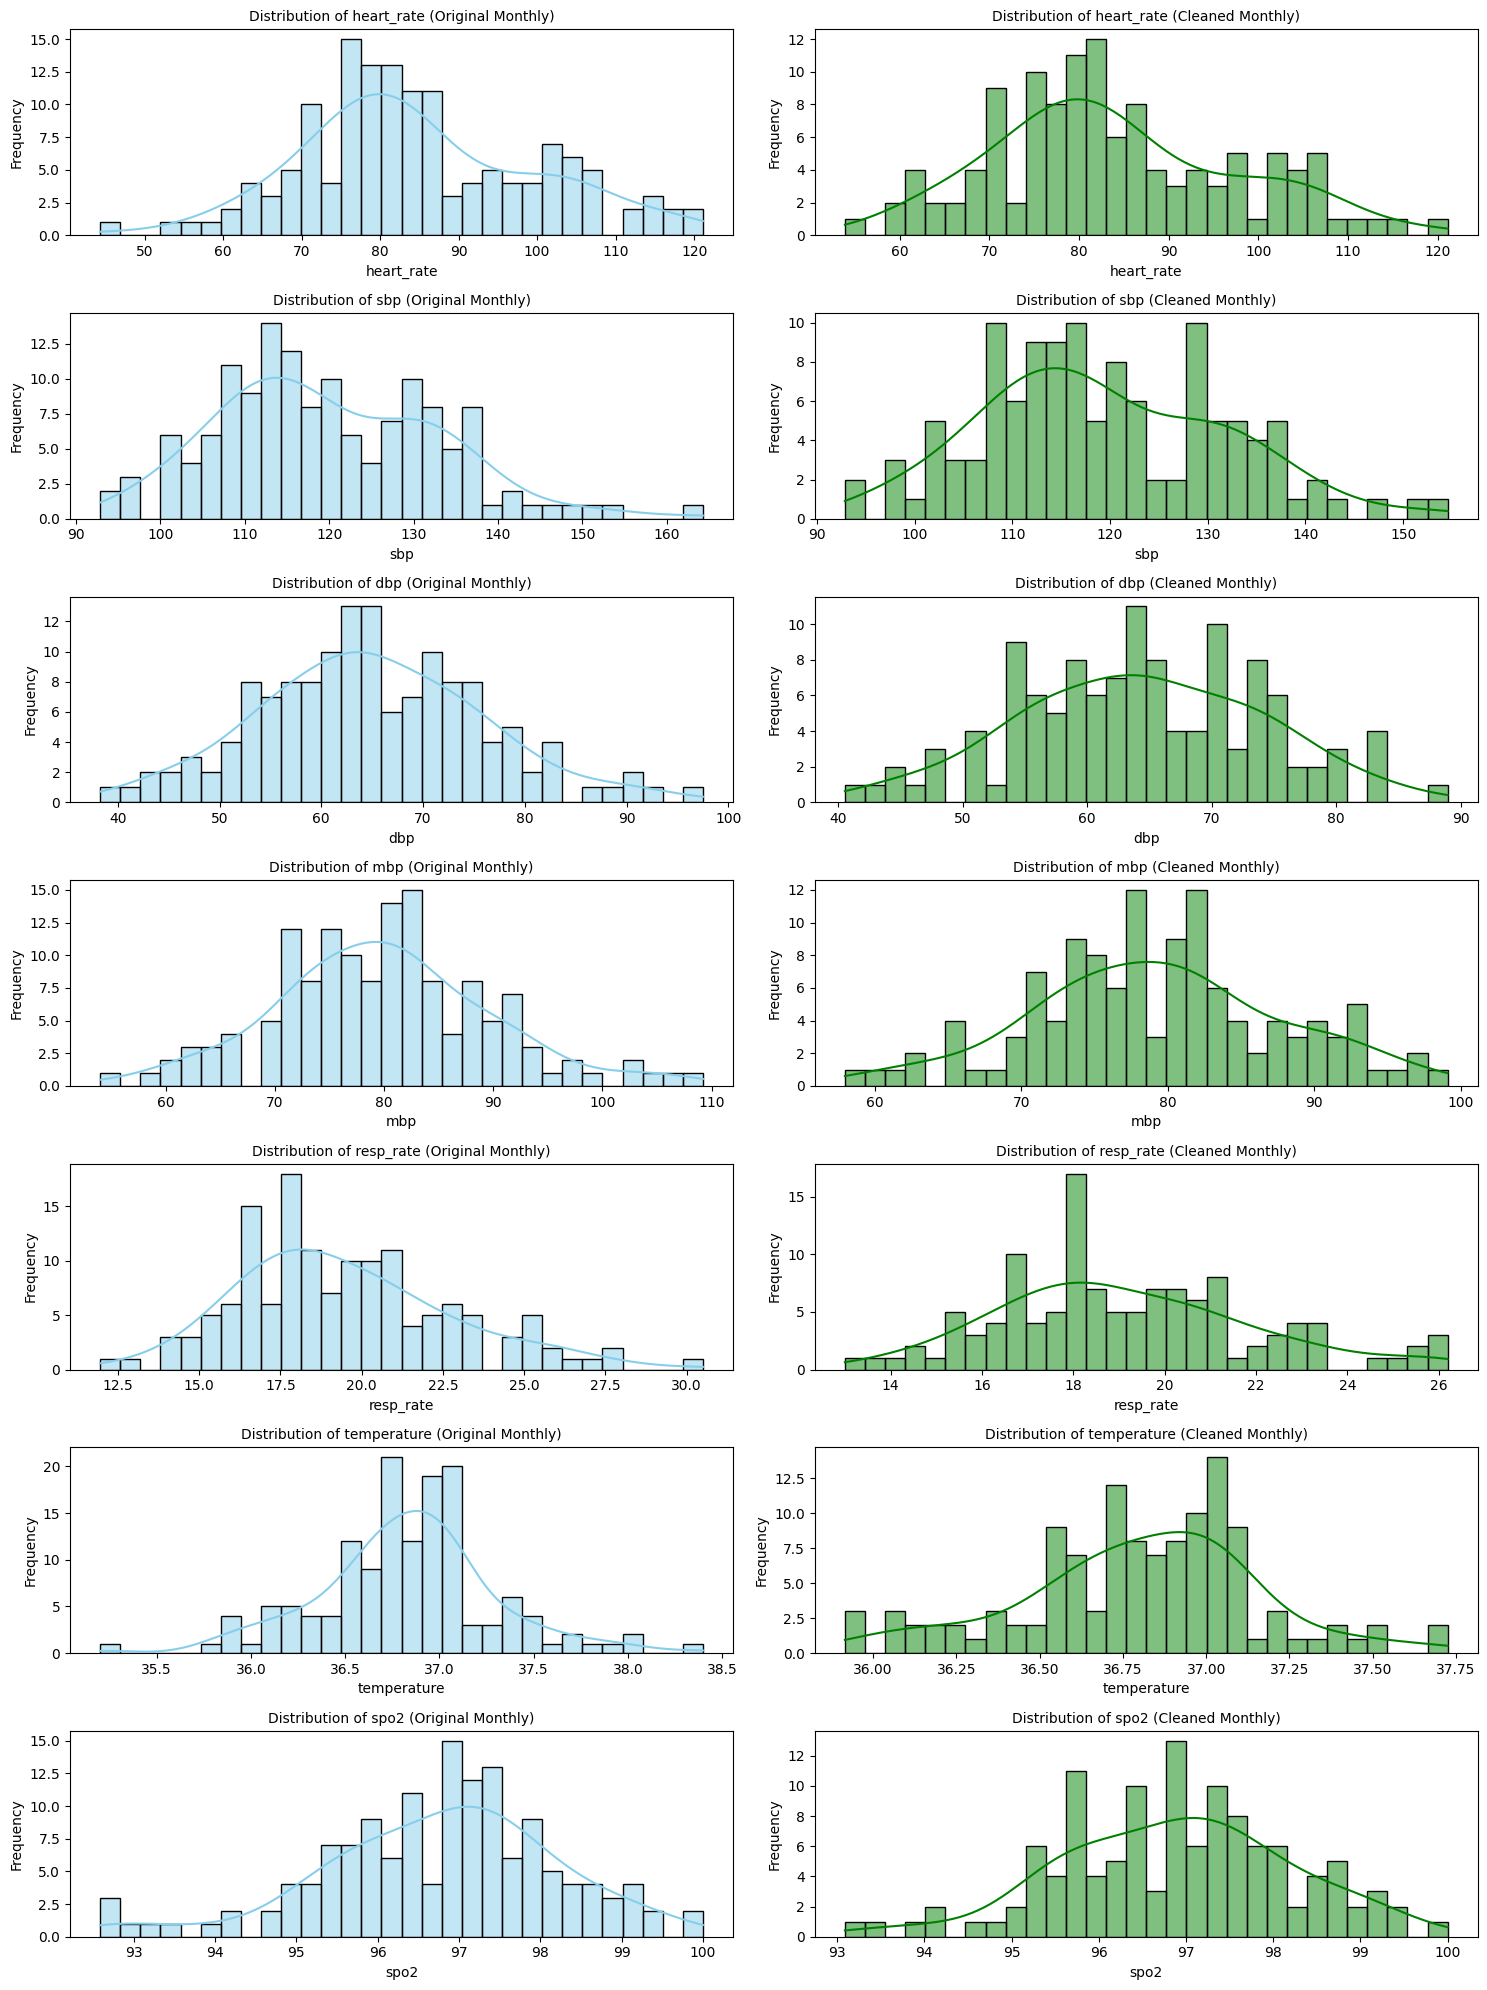

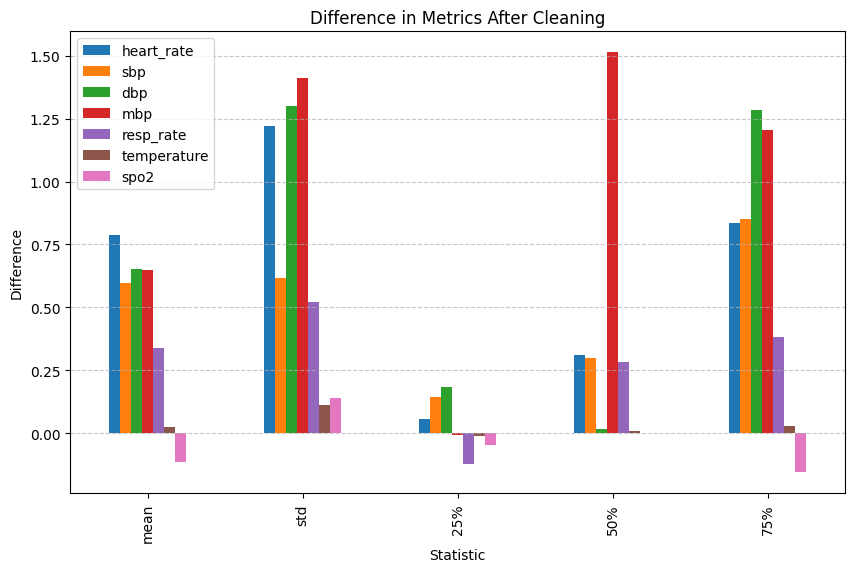

In [16]:
### compare distributions between monthly and cleaned monthly vitals
compare_distributions(monthly_vitals, monthly_vitals_cleaned, vital_cols, title_prefix="Monthly")

In [17]:
### plot_each_vital_separately; historical trend with deviation
import matplotlib.pyplot as plt

def plot_each_vital_separately(df_cleaned, vital_cols, title, downsample_factor=1):
    """
    Creates separate plots for each vital in vital_cols, showing its median 
    with ±1 standard deviation as a gradient. Downsampling is applied to reduce
    the number of points plotted.

    Args:
    df_cleaned (DataFrame): Cleaned DataFrame (daily, weekly, or monthly)
    vital_cols (list): List of vital column names
    title (str): Title prefix for the plots (e.g., "Daily", "Weekly", "Monthly")
    downsample_factor (int): Factor by which to downsample the data (default: 1 = no downsampling)
    """
    # Downsample the dataframe if needed
    if downsample_factor > 1:
        df_downsampled = df_cleaned.iloc[::downsample_factor].copy()
    else:
        df_downsampled = df_cleaned

    time_series = df_downsampled['charttime'] 

    for vital in vital_cols:
        medians = df_downsampled[vital].rolling(window=5, min_periods=1).median()
        std_devs = df_downsampled[vital].rolling(window=5, min_periods=1).std()

        plt.figure(figsize=(12, 6))

        # Plot the gradient (±1 standard deviation)
        plt.fill_between(
            time_series,
            medians - std_devs,
            medians + std_devs,
            alpha=0.3,
            label=f'±1 Std Dev: {vital}'
        )

        # Plot the median line
        plt.plot(time_series, medians, label=f'Median: {vital}', color='blue')

        # Add title and labels
        plt.title(f'{title} - {vital.capitalize()} Trends Over Time', fontsize=14)
        plt.xlabel('Time', fontsize=12)
        plt.ylabel(f'{vital.capitalize()} Value', fontsize=12)

        # Add grid and legend
        plt.grid(visible=True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=10)
        plt.tight_layout()

        # Display the plot
        plt.show()


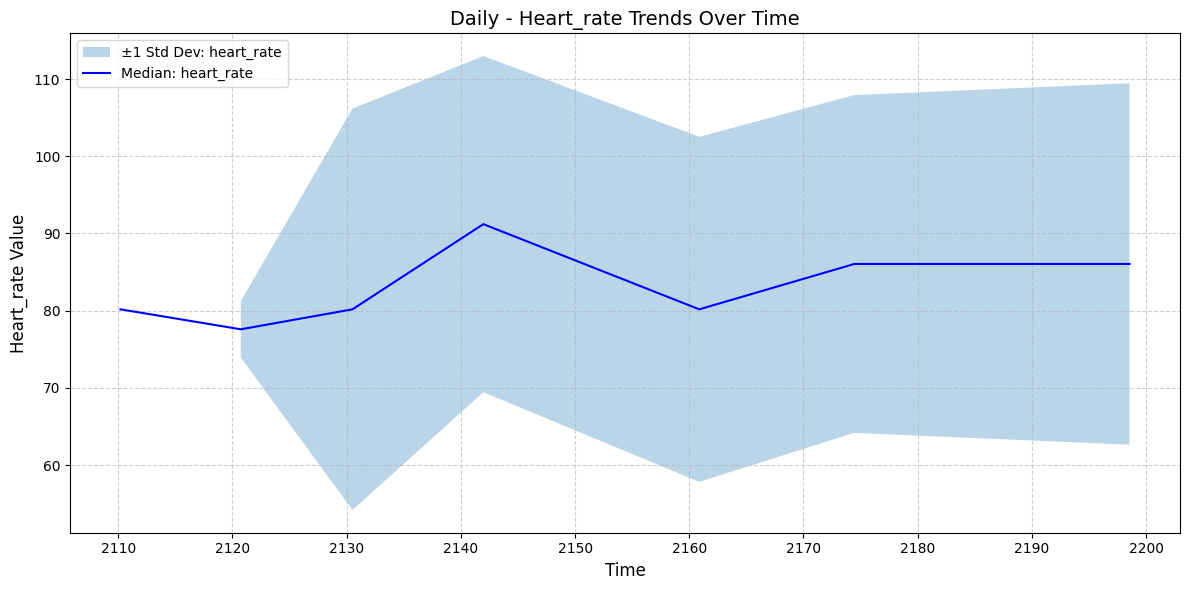

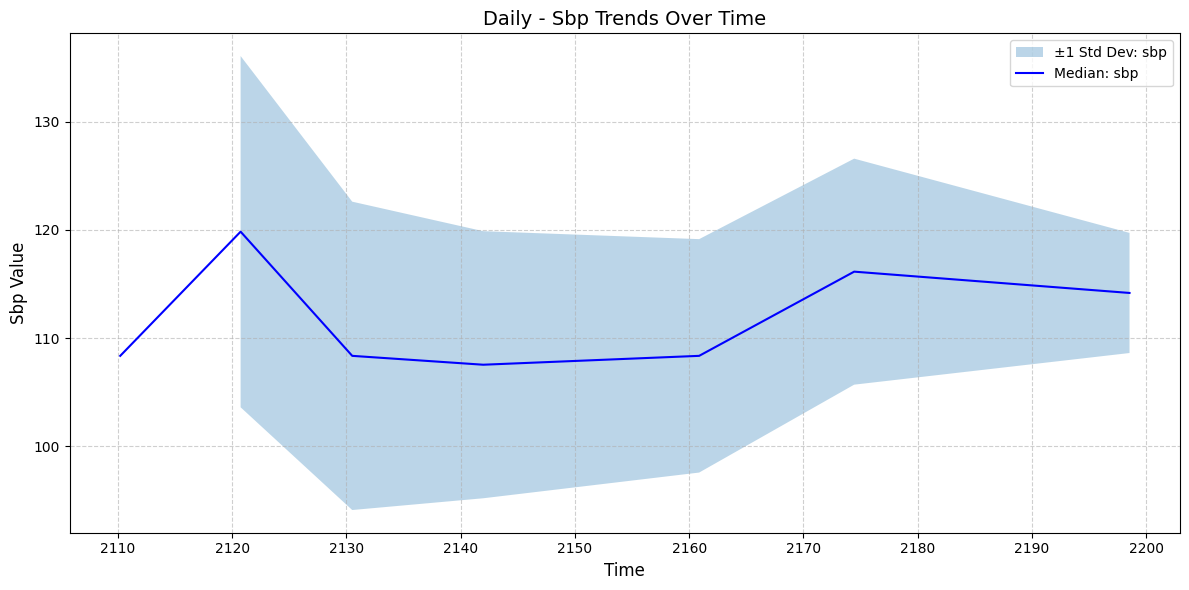

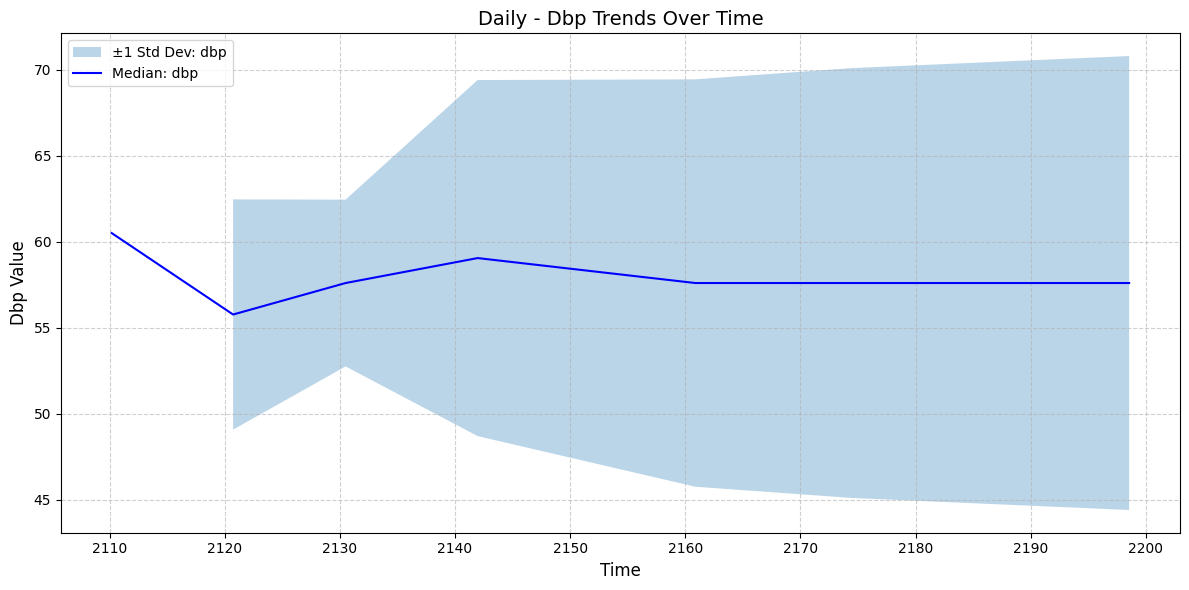

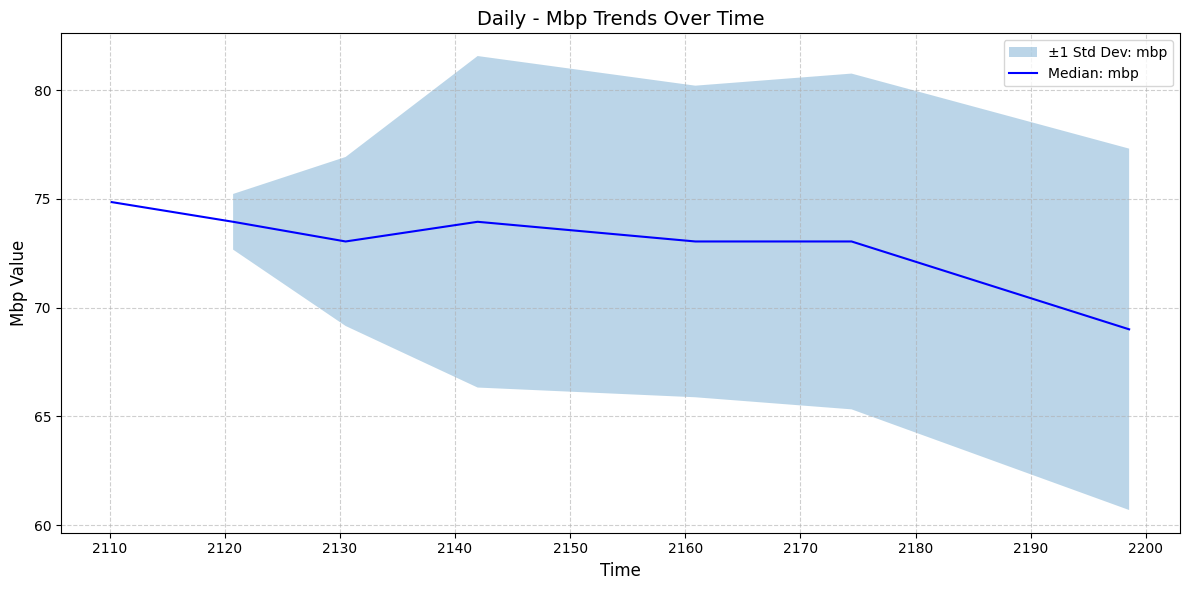

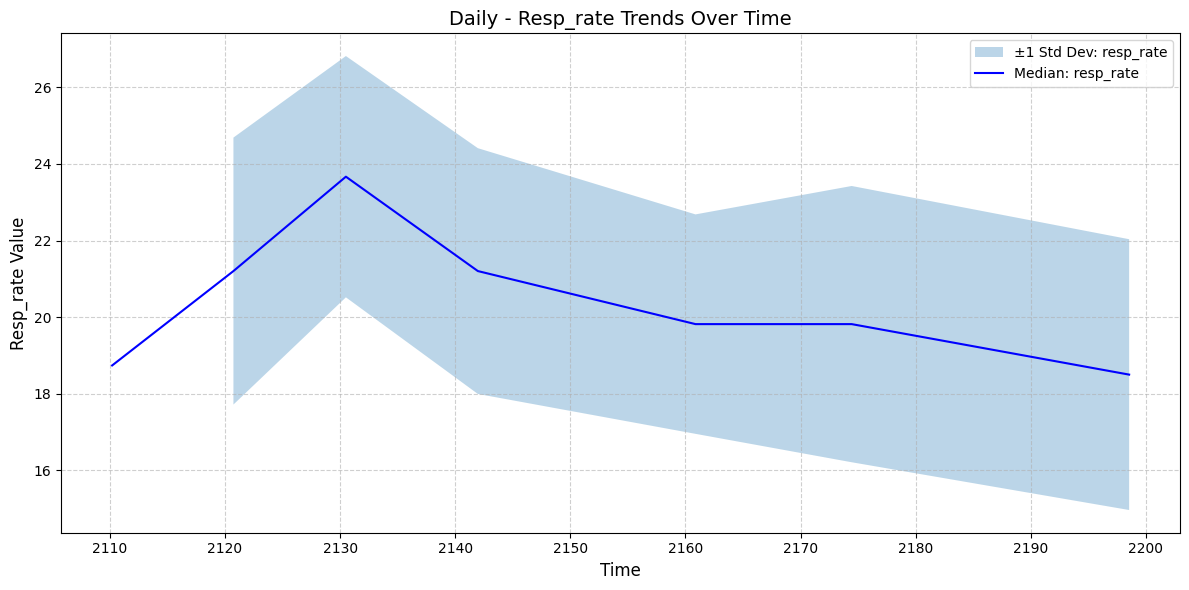

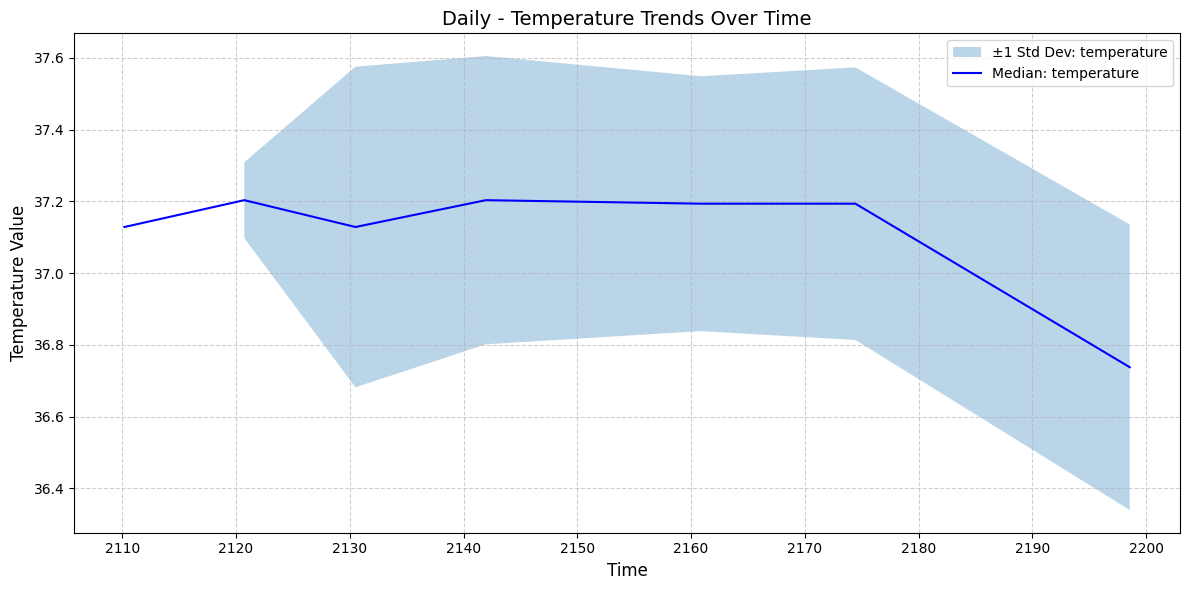

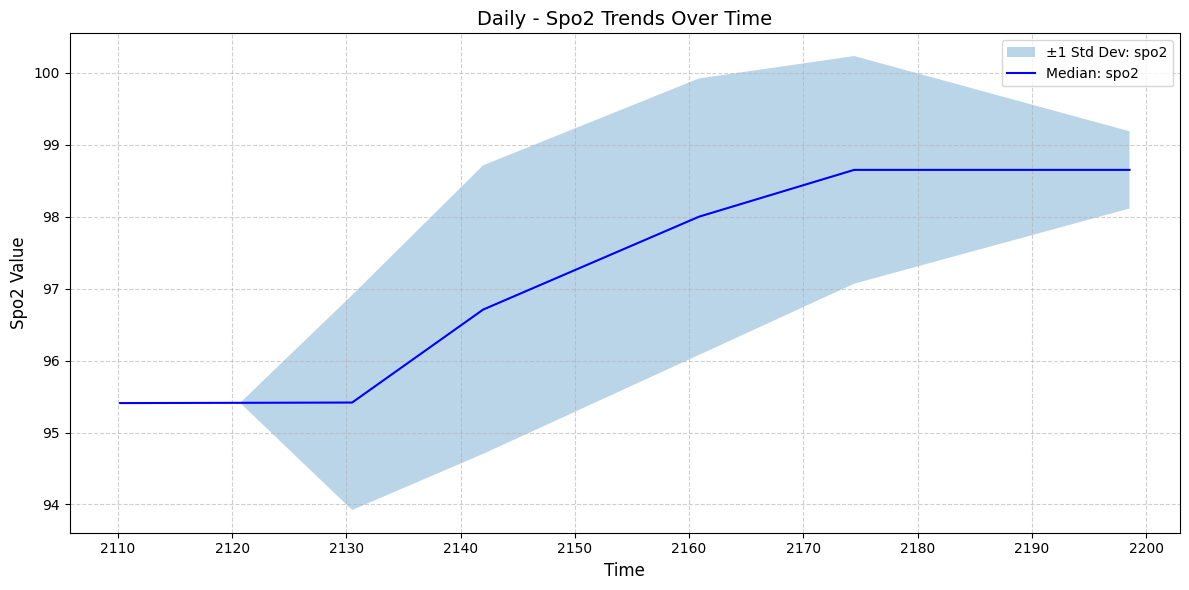

In [18]:
### visualize daily cleaned vitals with deviation for context
plot_each_vital_separately(daily_vitals_cleaned, vital_cols, 'Daily', 100)

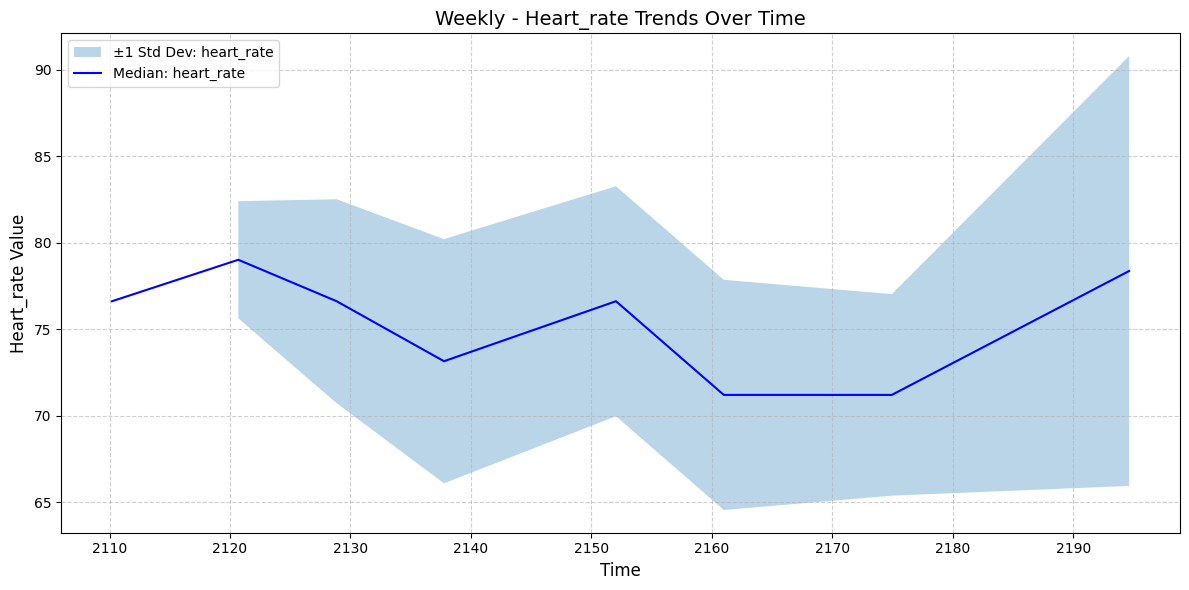

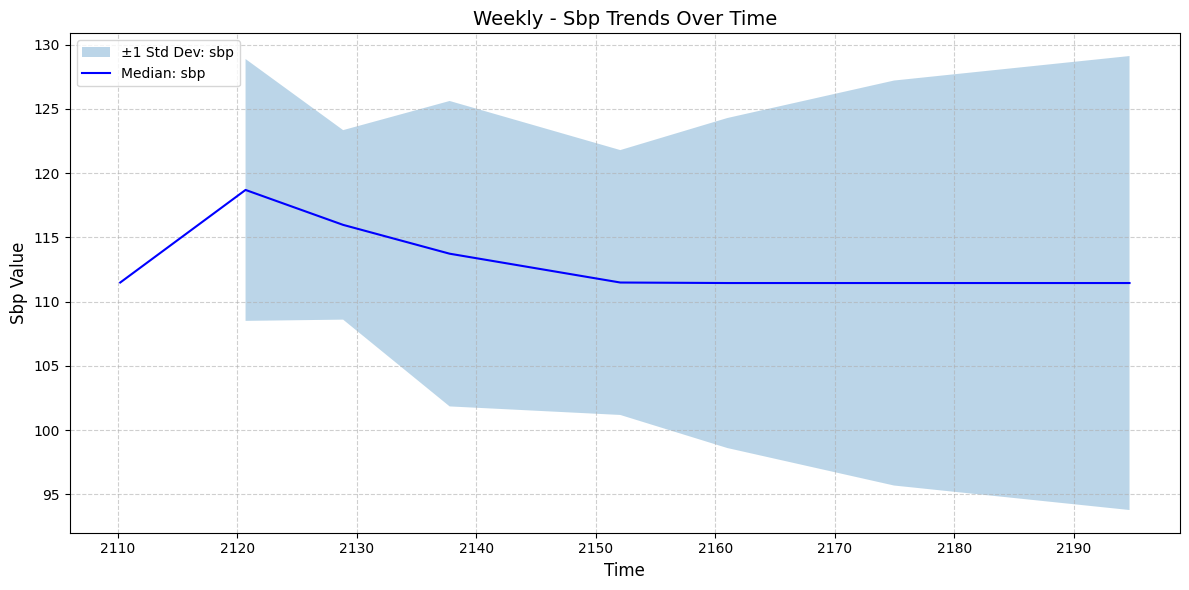

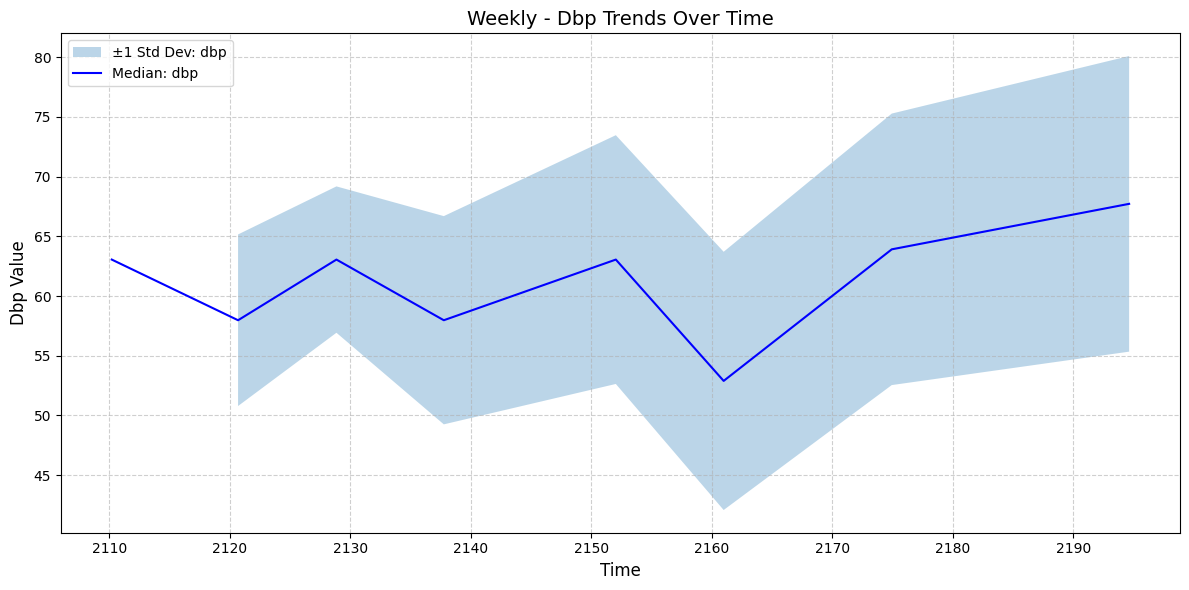

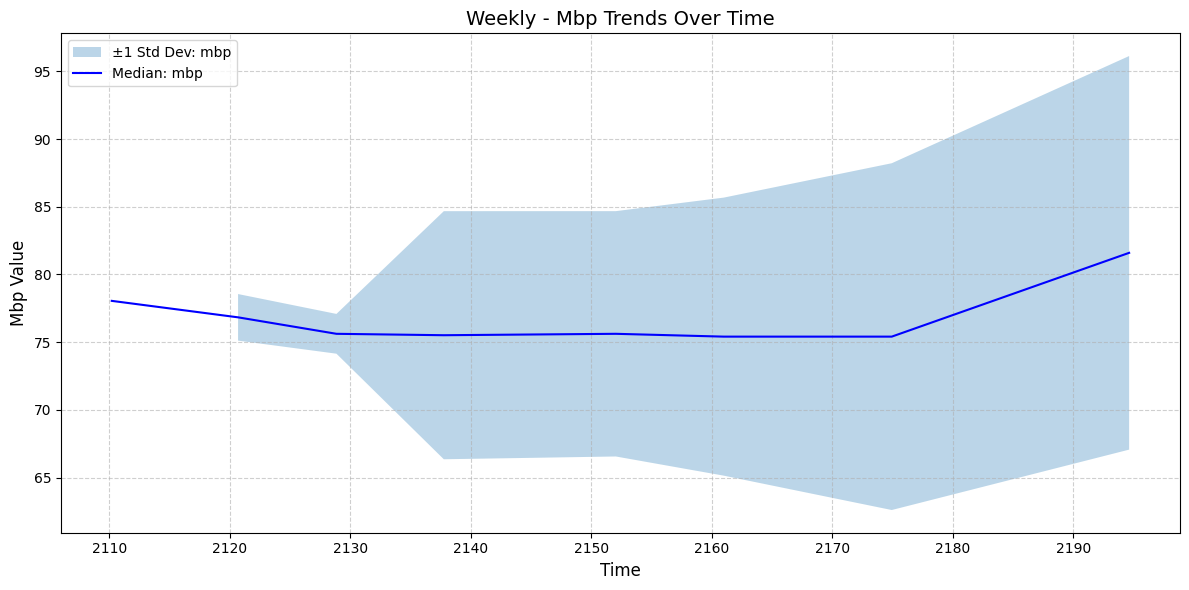

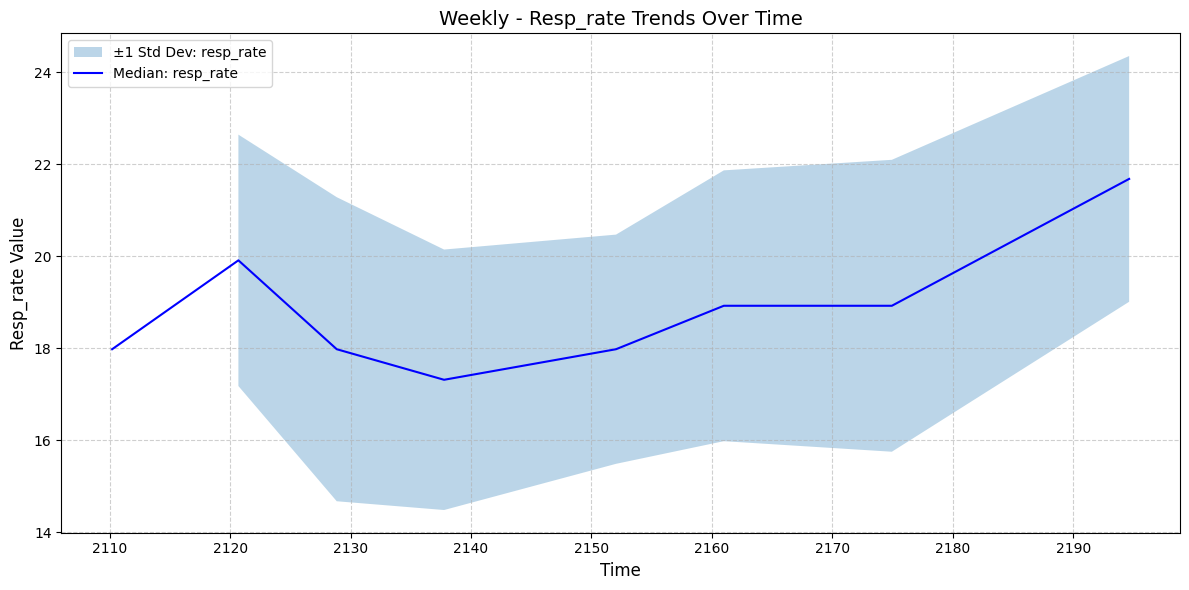

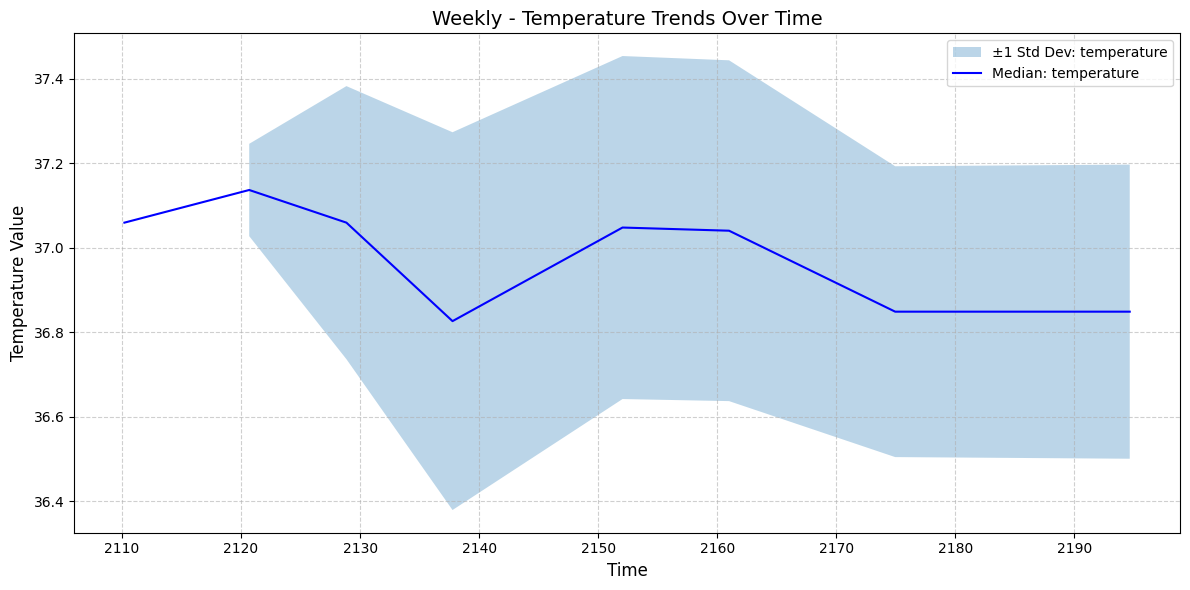

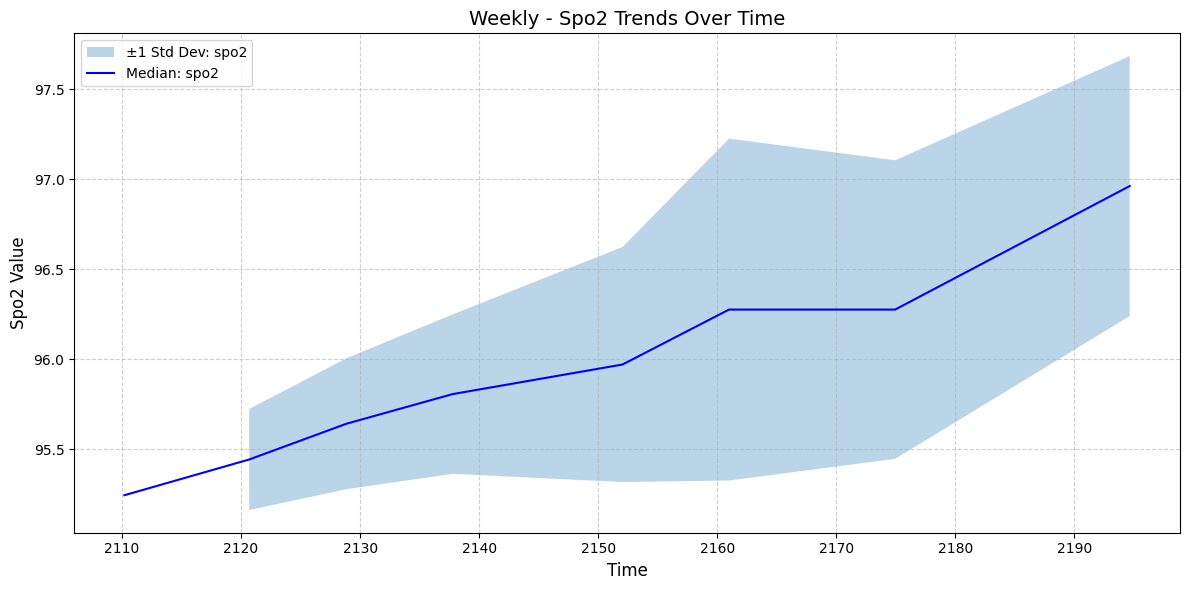

In [19]:
### visualize weekly cleaned vitals with deviation for context
plot_each_vital_separately(weekly_vitals_cleaned, vital_cols, 'Weekly', 25)

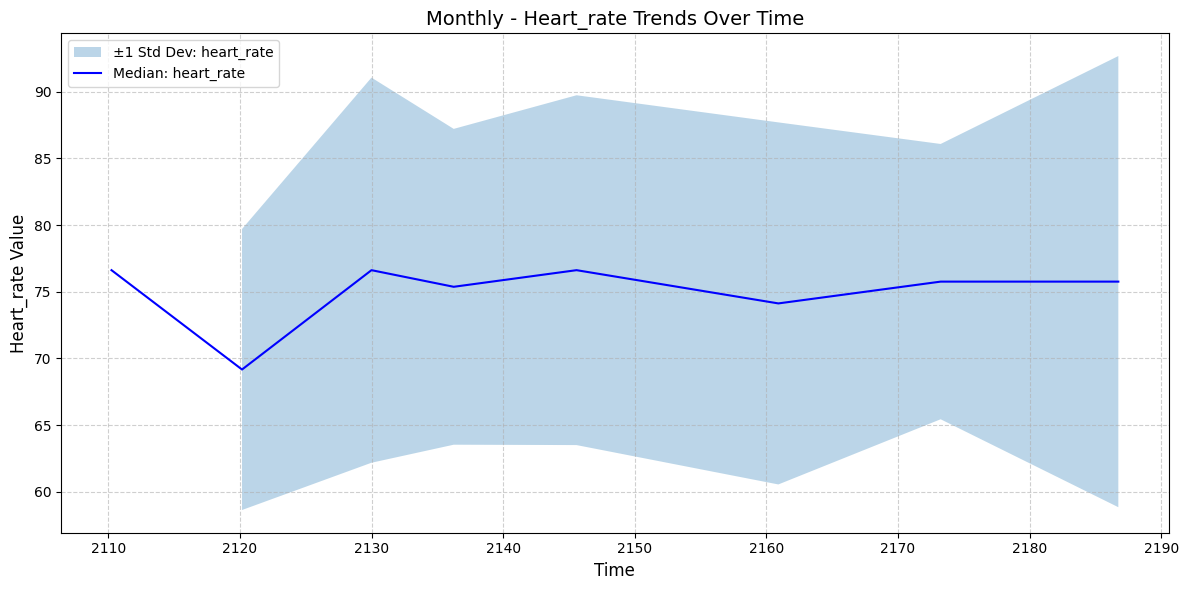

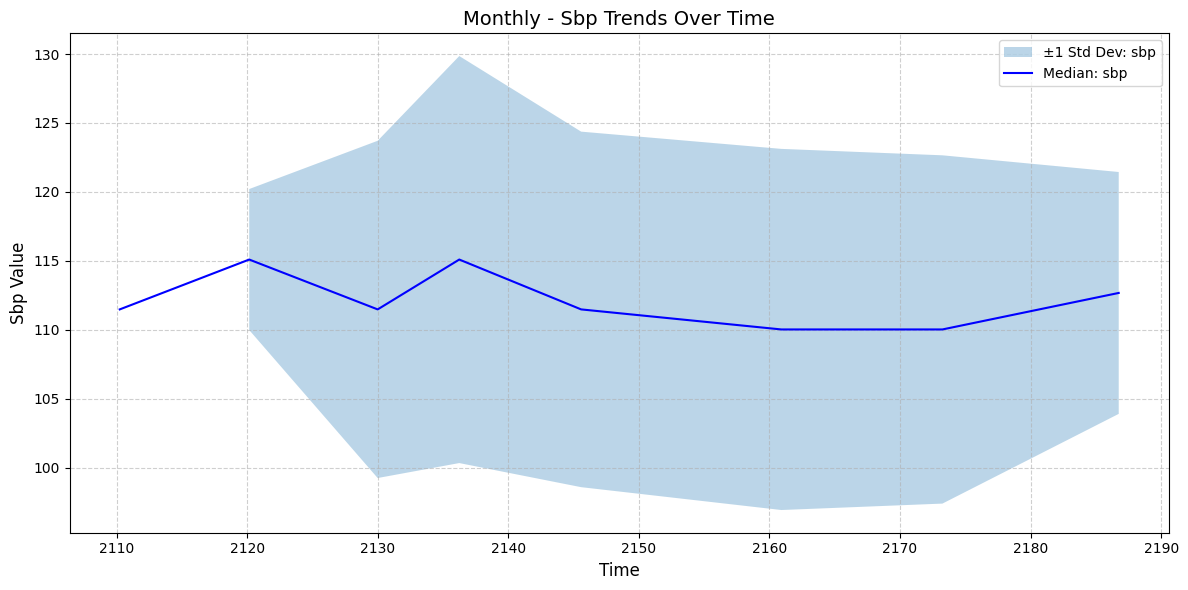

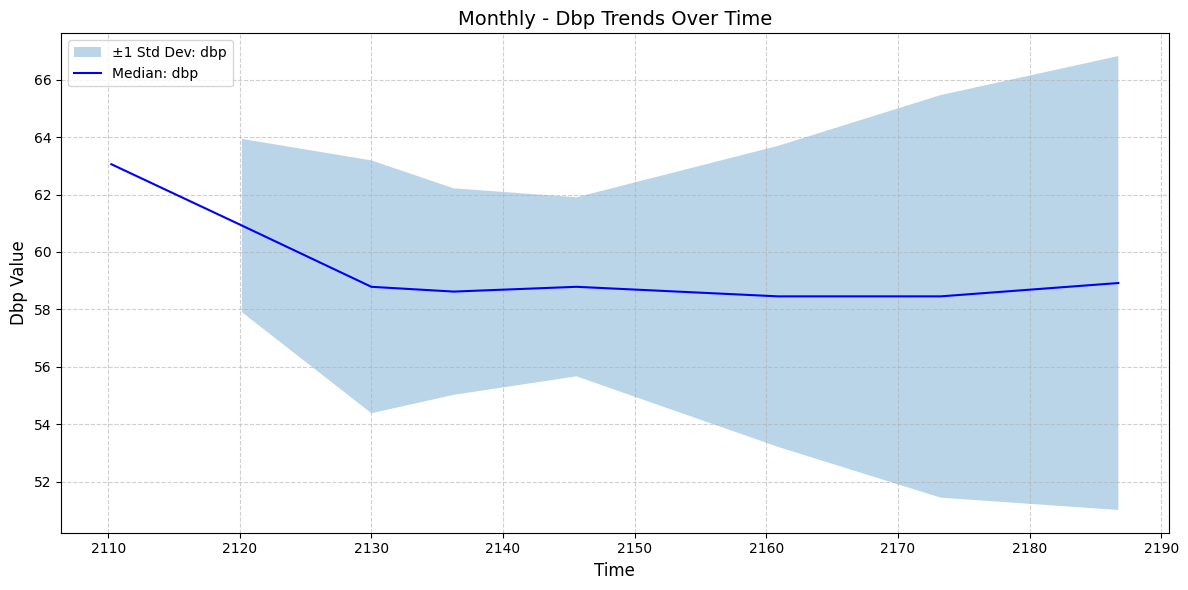

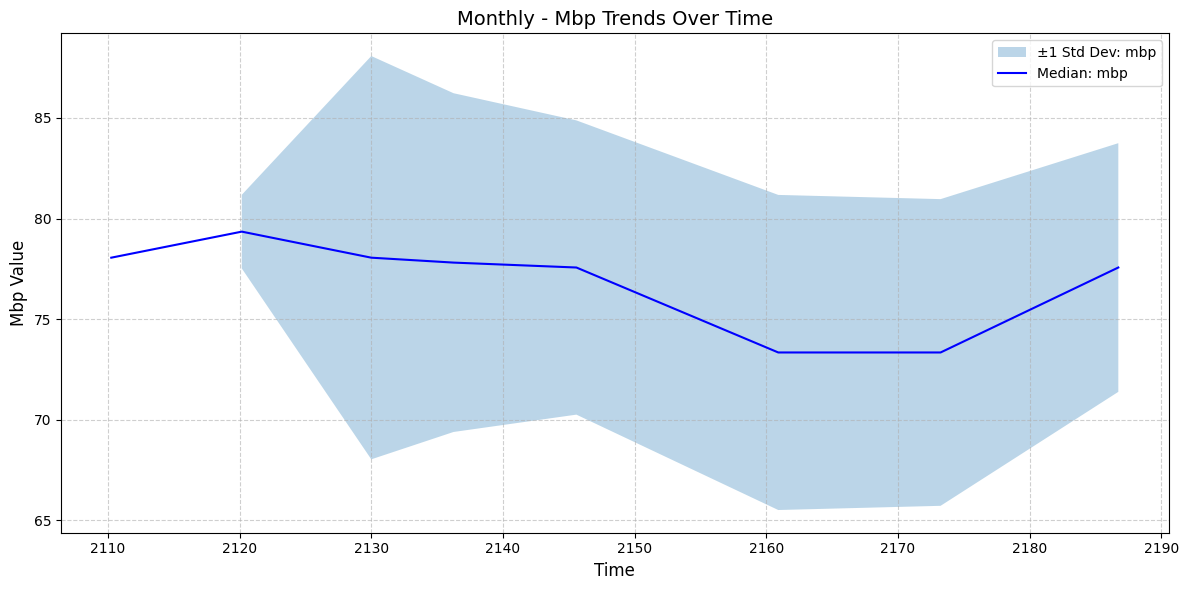

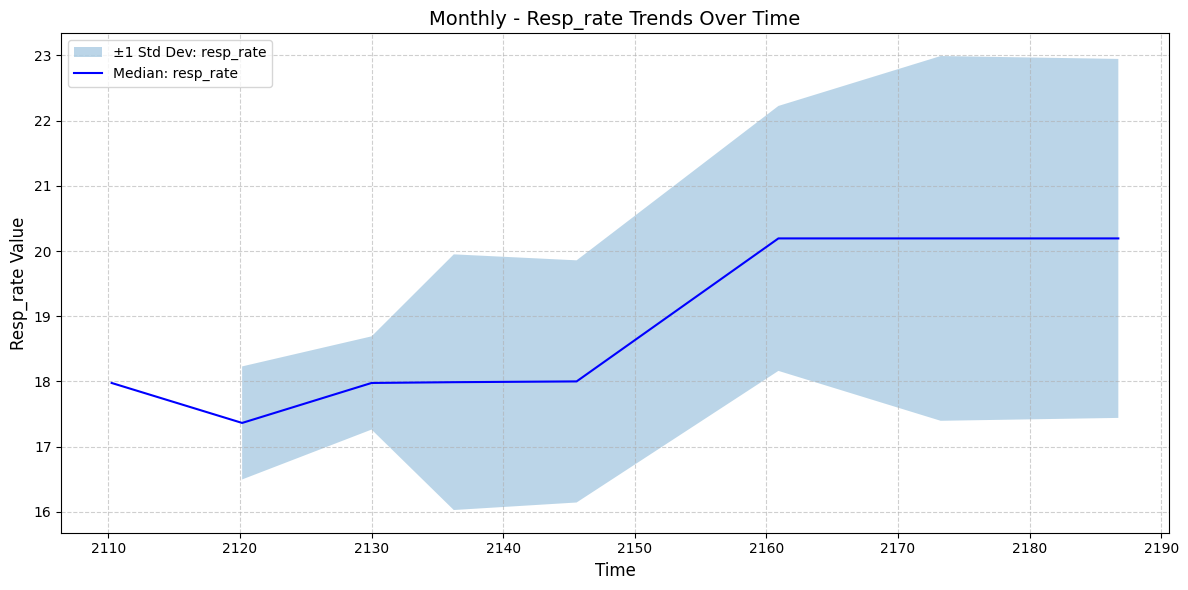

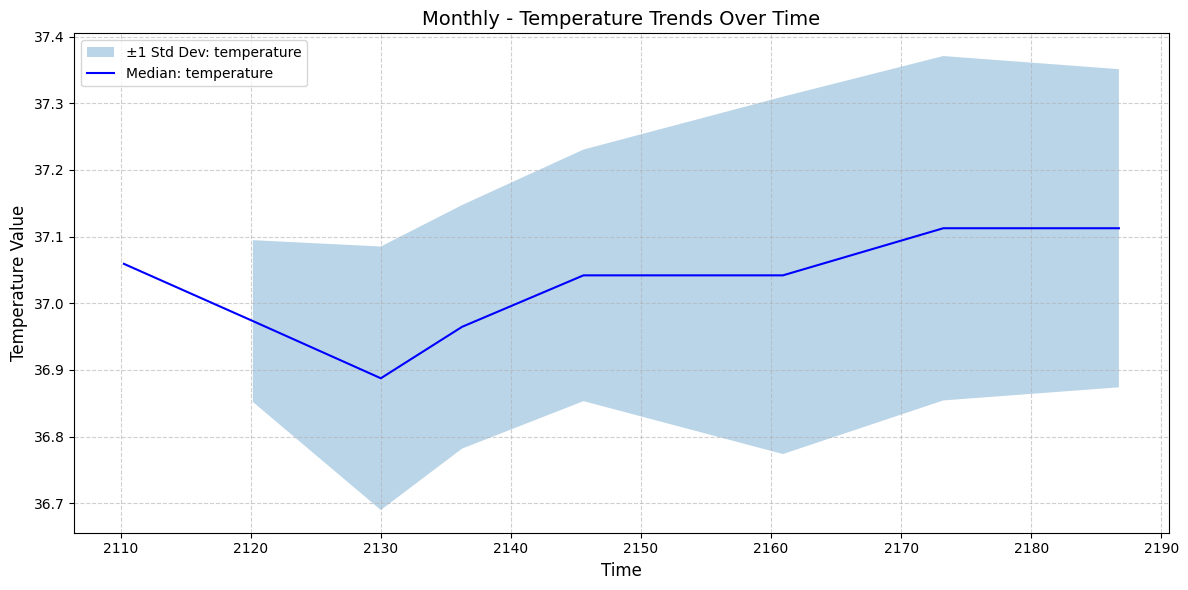

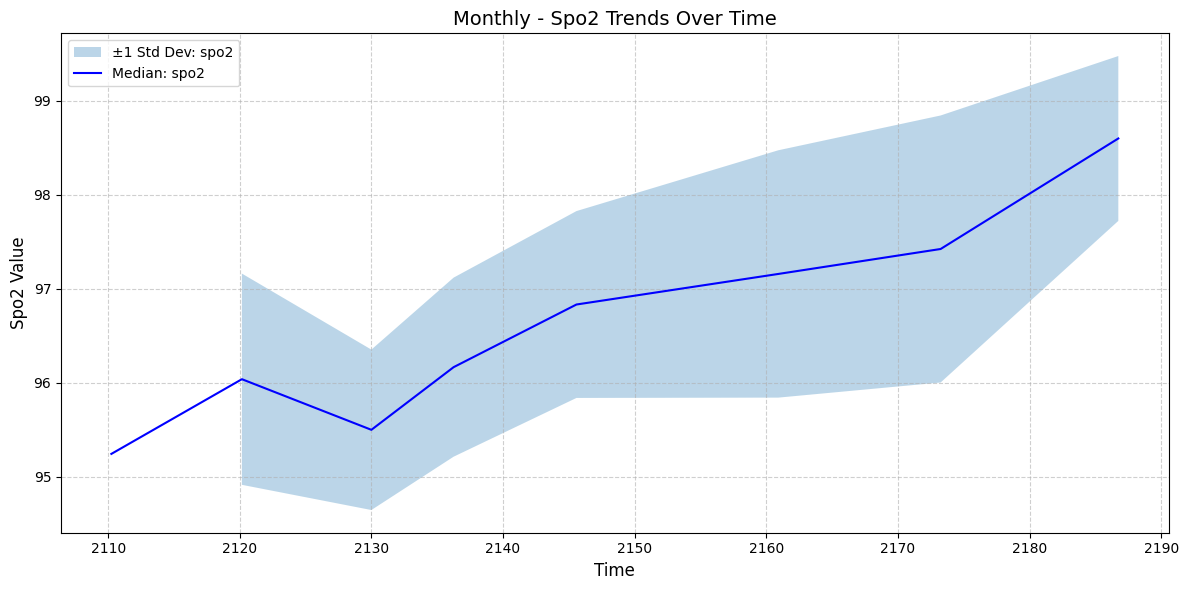

In [20]:
### visualize monthly cleaned vitals with deviation for context
plot_each_vital_separately(monthly_vitals_cleaned, vital_cols, 'Monthly', 15)

In [21]:
### optional, means to save dataframes
# from file_utils import save_dataframes

# save_dataframes({
#     "daily_vitals": daily_vitals,
#     "daily_vitals_cleaned": daily_vitals_cleaned,
#     "weekly_vitals": weekly_vitals,
#     "weekly_vitals_cleaned": weekly_vitals_cleaned,
#     "monthly_vitals": monthly_vitals,
#     "monthly_vitals_cleaned": monthly_vitals_cleaned
# })



In [22]:
### calculate_vital_variability; rolling std deviation and mean
def calculate_vital_variability(df, vital_columns):
    """
    Calculate rolling statistics for vital signs to capture variability
    
    Args:
        df (pd.DataFrame): Input dataframe with vital measurements
        vital_columns (list): List of vital sign columns to process
    
    Returns:
        pd.DataFrame: DataFrame with added variability features
    """
    result_df = df.copy()
    
    for col in vital_columns:
        # Rolling statistics (24h window for daily data)
        result_df[f'{col}_rolling_std'] = df.groupby('subject_id')[col].transform(
            lambda x: x.rolling(window=24, min_periods=1).std()
        )
        result_df[f'{col}_rolling_mean'] = df.groupby('subject_id')[col].transform(
            lambda x: x.rolling(window=24, min_periods=1).mean()
        )
        
        # Calculate rate of change
        result_df[f'{col}_rate_change'] = df.groupby('subject_id')[col].transform(
            lambda x: x.diff() / pd.Timedelta(hours=1).total_seconds()
        )
    
    return result_df

### calculate_vital_interactions; determine shock index, arterial pressure
def calculate_vital_interactions(df, vital_columns):
    """
    Calculate interaction features between different vital signs
    
    Args:
        df (pd.DataFrame): Input dataframe with vital measurements
        vital_columns (list): List of vital sign columns to process
    
    Returns:
        pd.DataFrame: DataFrame with added interaction features
    """
    result_df = df.copy()
    
    # Calculate shock index (heart rate / systolic blood pressure)
    if 'heart_rate' in vital_columns and 'sbp' in vital_columns:
        result_df['shock_index'] = df['heart_rate'] / df['sbp']
    
    # Calculate mean arterial pressure if not already present
    if all(col in vital_columns for col in ['sbp', 'dbp']) and 'mbp' not in vital_columns:
        result_df['map_calculated'] = (df['sbp'] + 2 * df['dbp']) / 3
    
    return result_df

### normalize_features; apply robust scaler
def normalize_features(df, columns_to_normalize):
    """
    Normalize numerical features using robust scaling
    
    Args:
        df (pd.DataFrame): Input dataframe
        columns_to_normalize (list): List of columns to normalize
    
    Returns:
        pd.DataFrame: DataFrame with normalized features
        dict: Scaling parameters for each column
    """
    from sklearn.preprocessing import RobustScaler
    
    result_df = df.copy()
    scaling_params = {}
    
    for col in columns_to_normalize:
        if col in df.columns:
            scaler = RobustScaler()
            result_df[f'{col}_normalized'] = scaler.fit_transform(df[[col]])
            scaling_params[col] = scaler
    
    return result_df, scaling_params


## Feature Engineering

### Data Quality: Temporal Prep

In [23]:
### inspect_dataframe; simple shape, col, head check, helper fn
def inspect_dataframe(df, name):
    """
    Print key information about a dataframe
    """
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    print("\nSample of first few rows:")
    print(df.head(2))

### inspect_dataframe
inspect_dataframe(vitals_df, "Raw Vitals DataFrame")

### calculate_vital_variability; rehashed from previous
def calculate_vital_variability(df, vital_columns, time_col='charttime'):
    """
    Calculate rolling statistics for vital signs to capture variability
    
    Args:
        df (pd.DataFrame): Input dataframe with vital measurements
        vital_columns (list): List of vital sign columns to process
        time_col (str): Name of the timestamp column
    
    Returns:
        pd.DataFrame: DataFrame with added variability features
    """
    result_df = df.copy()
    
    # Ensure datetime format
    result_df[time_col] = pd.to_datetime(result_df[time_col])
    
    # Sort by subject_id and time for accurate rolling calculations
    result_df = result_df.sort_values(['subject_id', time_col])
    
    for col in vital_columns:
        if col in df.columns:
            # Rolling statistics (24h window)
            result_df[f'{col}_rolling_std'] = (
                result_df.groupby('subject_id')[col]
                .transform(lambda x: x.rolling('24H', on=time_col, min_periods=1).std())
            )
            result_df[f'{col}_rolling_mean'] = (
                result_df.groupby('subject_id')[col]
                .transform(lambda x: x.rolling('24H', on=time_col, min_periods=1).mean())
            )
            
            # Calculate rate of change (per hour)
            result_df[f'{col}_rate_change'] = (
                result_df.groupby('subject_id')[col]
                .transform(lambda x: x.diff() / 
                         result_df[time_col].diff().dt.total_seconds() * 3600)
            )
    
    return result_df

### calculate_vital_interactions; rehashed from previous
def calculate_vital_interactions(df, vital_columns):
    """
    Calculate interaction features between different vital signs
    
    Args:
        df (pd.DataFrame): Input dataframe with vital measurements
        vital_columns (list): List of vital sign columns to process
    
    Returns:
        pd.DataFrame: DataFrame with added interaction features
    """
    result_df = df.copy()
    
    # Calculate shock index (heart_rate / sbp)
    if 'heart_rate' in df.columns and 'sbp' in df.columns:
        result_df['shock_index'] = (
            df['heart_rate'].div(df['sbp'])
            .replace([np.inf, -np.inf], np.nan)
        )
    
    # Calculate mean arterial pressure if not already present
    if all(col in df.columns for col in ['sbp', 'dbp']) and 'mbp' not in df.columns:
        result_df['map_calculated'] = (df['sbp'] + 2 * df['dbp']) / 3
    
    return result_df

### normalize_features; rehashed from previous
def normalize_features(df, columns_to_normalize):
    """
    Normalize numerical features using robust scaling
    
    Args:
        df (pd.DataFrame): Input dataframe
        columns_to_normalize (list): List of columns to normalize
    
    Returns:
        pd.DataFrame: DataFrame with normalized features
        dict: Scaling parameters for each column
    """
    from sklearn.preprocessing import RobustScaler
    
    result_df = df.copy()
    scaling_params = {}
    
    for col in columns_to_normalize:
        if col in df.columns:
            # Handle NaN values before scaling
            mask = df[col].notna()
            if mask.any():
                scaler = RobustScaler()
                result_df.loc[mask, f'{col}_normalized'] = (
                    scaler.fit_transform(df.loc[mask, [col]])
                )
                scaling_params[col] = scaler
    
    return result_df, scaling_params



=== Raw Vitals DataFrame ===
Shape: (23015, 14)

Columns: ['subject_id', 'stay_id', 'heart_rate', 'sbp', 'dbp', 'mbp', 'sbp_ni', 'dbp_ni', 'mbp_ni', 'resp_rate', 'temperature', 'temperature_site', 'spo2', 'glucose']

Sample of first few rows:
                     subject_id   stay_id  heart_rate    sbp   dbp   mbp  \
charttime                                                                  
2173-03-20 20:00:00    10004113  39774222        91.0  124.0  76.0  93.0   
2173-03-20 20:20:00    10004113  39774222        86.0    NaN   NaN   NaN   

                     sbp_ni  dbp_ni  mbp_ni  resp_rate  temperature  \
charttime                                                             
2173-03-20 20:00:00     NaN     NaN     NaN       15.0        37.06   
2173-03-20 20:20:00     NaN     NaN     NaN       19.0          NaN   

                    temperature_site  spo2  glucose  
charttime                                            
2173-03-20 20:00:00             Oral  99.0      NaN  
2173

In [24]:
### inline condition to validate vitals_df is in usable state
# First verify we have data and identify the timestamp column
if vitals_df is None or vitals_df.empty:
    print("Warning: vitals_df is empty or None")
else:
    # Print information about the dataframe
    print("DataFrame Info:")
    print(vitals_df.info())
    
    # Start feature engineering only if we have data
    feature_df = vitals_df.copy()
    
    # Identify the timestamp column - it might be named differently
    time_columns = [col for col in feature_df.columns if 'time' in col.lower()]
    print("\nPotential timestamp columns found:", time_columns)
    
    if time_columns:
        timestamp_col = time_columns[0]  # Use the first found timestamp column
        print(f"\nUsing {timestamp_col} as timestamp column")
        
        # Add temporal features using the identified timestamp column
        feature_df['hour_of_day'] = pd.to_datetime(feature_df[timestamp_col]).dt.hour
        feature_df['day_of_week'] = pd.to_datetime(feature_df[timestamp_col]).dt.dayofweek
        
        print("\nNew columns added:", 
              [col for col in feature_df.columns if col not in vitals_df.columns])
    else:
        print("No timestamp column found in the data")

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23015 entries, 2173-03-20 20:00:00 to 2136-03-18 20:00:00
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        23015 non-null  int64  
 1   stay_id           23015 non-null  int64  
 2   heart_rate        15008 non-null  float64
 3   sbp               14861 non-null  float64
 4   dbp               14860 non-null  float64
 5   mbp               14850 non-null  float64
 6   sbp_ni            8563 non-null   float64
 7   dbp_ni            8562 non-null   float64
 8   mbp_ni            8556 non-null   float64
 9   resp_rate         14882 non-null  float64
 10  temperature       4384 non-null   float64
 11  temperature_site  4313 non-null   object 
 12  spo2              14693 non-null  float64
 13  glucose           3399 non-null   float64
dtypes: float64(11), int64(2), object(1)
memory usage: 2.6+ MB
None

Potential timestamp

In [25]:
### inline dump of basic vitals_df
print("=== Data Overview ===")
print("\nVitals DataFrame:")
print(vitals_df.info())
print("\nSample of vitals_df:")
print(vitals_df.head(2))

### dict of previous variables
existing_dfs = {
    'daily': 'daily_vitals' in locals(),
    'weekly': 'weekly_vitals' in locals(),
    'monthly': 'monthly_vitals' in locals()
}
print("\nAggregated dataframes available:", existing_dfs)


### check_data_quality; helper fn
def check_data_quality(df, cols_to_check):
    """
    Check data quality metrics for specified columns
    
    Args:
        df: DataFrame to check
        cols_to_check: List of columns to analyze
    """
    stats = {
        'missing_pct': df[cols_to_check].isnull().mean() * 100,
        'unique_values': df[cols_to_check].nunique(),
        'min_values': df[cols_to_check].min(),
        'max_values': df[cols_to_check].max()
    }
    
    print("\n=== Data Quality Report ===")
    for metric, values in stats.items():
        print(f"\n{metric}:")
        print(values)
        
# check_data_quality on previous vitals_df
check_data_quality(vitals_df, vital_cols)

=== Data Overview ===

Vitals DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23015 entries, 2173-03-20 20:00:00 to 2136-03-18 20:00:00
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        23015 non-null  int64  
 1   stay_id           23015 non-null  int64  
 2   heart_rate        15008 non-null  float64
 3   sbp               14861 non-null  float64
 4   dbp               14860 non-null  float64
 5   mbp               14850 non-null  float64
 6   sbp_ni            8563 non-null   float64
 7   dbp_ni            8562 non-null   float64
 8   mbp_ni            8556 non-null   float64
 9   resp_rate         14882 non-null  float64
 10  temperature       4384 non-null   float64
 11  temperature_site  4313 non-null   object 
 12  spo2              14693 non-null  float64
 13  glucose           3399 non-null   float64
dtypes: float64(11), int64(2), object(1)
memory usage: 2.6+ MB


### Create Features

In [26]:
### create_basic_features; append new features with common vital-derived values
def create_basic_features(df):
    """
    Create basic statistical features from vital signs
    
    Args:
        df: Input DataFrame with vital measurements
    Returns:
        DataFrame with new features
    """
    result_df = df.copy()
    
    # 1. Basic vital sign ratios
    print("\nCreating basic vital ratios...")
    
    # Shock index (HR/SBP)
    result_df['shock_index'] = df['heart_rate'] / df['sbp']
    
    # MAP if not present (useful for validation)
    result_df['map_calculated'] = (df['sbp'] + 2 * df['dbp']) / 3
    
    # ROX index (SpO2/FiO2/RR) - simplified version
    result_df['rox_index'] = df['spo2'] / df['resp_rate']
    
    # 2. Check quality of new features
    new_cols = ['shock_index', 'map_calculated', 'rox_index']
    check_data_quality(result_df, new_cols)
    
    return result_df

### create_statistical_features; calculate and return col metrics
def create_statistical_features(df):
    """
    Create statistical features for each vital sign
    
    Args:
        df: Input DataFrame with vital measurements
    Returns:
        DataFrame with new statistical features
    """
    result_df = df.copy()
    
    print("\nCreating statistical features...")
    
    # Group by subject_id to calculate per-patient stats
    for col in vital_cols:
        # Skip if column doesn't exist
        if col not in df.columns:
            continue
            
        group = df.groupby('subject_id')[col]
        
        # Calculate basic statistics
        result_df[f'{col}_mean'] = group.transform('mean')
        result_df[f'{col}_std'] = group.transform('std')
        result_df[f'{col}_min'] = group.transform('min')
        result_df[f'{col}_max'] = group.transform('max')
        
    # Check new features
    new_cols = [col for col in result_df.columns 
                if any(x in col for x in ['_mean', '_std', '_min', '_max'])]
    check_data_quality(result_df, new_cols[:5])  # Show first 5 for brevity
    
    return result_df

### apply basic features to vitals df, creating feature_df
feature_df = create_basic_features(vitals_df)

### apply statistical features, updating feature_df
feature_df = create_statistical_features(feature_df)

### print outcomes after applying previous features
print("\n=== Feature Engineering Summary ===")
print(f"Original columns: {len(vitals_df.columns)}")
print(f"New columns: {len(feature_df.columns) - len(vitals_df.columns)}")
print("\nNew features created:")
new_features = sorted(set(feature_df.columns) - set(vitals_df.columns))
for f in new_features:
    print(f"- {f}")

Starting feature engineering process...

Creating basic vital ratios...

=== Data Quality Report ===

missing_pct:
shock_index       58.322833
map_calculated    35.437758
rox_index         40.895068
dtype: float64

unique_values:
shock_index       3948
map_calculated     423
rox_index          576
dtype: int64

min_values:
shock_index        0.259843
map_calculated    26.000000
rox_index          1.318841
dtype: float64

max_values:
shock_index         4.0
map_calculated    184.0
rox_index          50.0
dtype: float64

Creating statistical features...

=== Data Quality Report ===

missing_pct:
heart_rate_mean    0.0
heart_rate_std     0.0
heart_rate_min     0.0
heart_rate_max     0.0
sbp_mean           0.0
dtype: float64

unique_values:
heart_rate_mean    100
heart_rate_std     100
heart_rate_min      45
heart_rate_max      60
sbp_mean           100
dtype: int64

min_values:
heart_rate_mean    53.898876
heart_rate_std      1.898963
heart_rate_min     30.000000
heart_rate_max     70.000

In [27]:
### create_temporal_features; add new time-based features
def create_temporal_features(df):
    """
    Create features related to temporal patterns and variability
    
    Args:
        df: Input DataFrame with datetime index
    Returns:
        DataFrame with new temporal features
    """
    result_df = df.copy()
    print("\nCreating temporal features...")
    
    # Get datetime from index and preserve it
    if isinstance(result_df.index, pd.DatetimeIndex):
        timestamp_series = result_df.index
    else:
        print("Warning: DataFrame index is not datetime. Temporal features may be incomplete.")
        return result_df
    
    # Basic time features
    result_df['hour'] = timestamp_series.hour
    result_df['day_of_week'] = timestamp_series.dayofweek
    result_df['is_night'] = (
        (timestamp_series.hour >= 22) | 
        (timestamp_series.hour <= 5)
    ).astype(int)
    
    # Time since first measurement per patient
    for subject in result_df['subject_id'].unique():
        mask = result_df['subject_id'] == subject
        first_time = timestamp_series[mask].min()
        result_df.loc[mask, 'hours_since_first'] = (
            (timestamp_series[mask] - first_time).total_seconds() / 3600
        )
    
    # Check new features
    new_cols = ['hour', 'day_of_week', 'is_night', 'hours_since_first']
    print("\nTemporal features created:")
    print(result_df[new_cols].describe())
    
    return result_df

In [28]:
### create_variability_features; rehash previous
def create_variability_features(df):
    """
    Create features capturing vital sign variability
    
    Args:
        df: Input DataFrame with vital measurements
    Returns:
        DataFrame with new variability features
    """
    result_df = df.copy()
    print("\nCreating variability features...")
    
    for col in vital_cols:
        if col not in df.columns:
            continue
            
        # Calculate changes between consecutive measurements
        result_df[f'{col}_diff'] = df.groupby('subject_id')[col].diff()
        
        # Calculate absolute changes
        result_df[f'{col}_abs_diff'] = result_df[f'{col}_diff'].abs()
        
        # Calculate percent changes
        result_df[f'{col}_pct_change'] = df.groupby('subject_id')[col].pct_change()
        
    # Check new features
    new_cols = [col for col in result_df.columns 
                if any(x in col for x in ['_diff', '_pct_change'])]
    check_data_quality(result_df, new_cols[:5])  # Show first 5 for brevity
    
    return result_df


In [29]:
### create_interaction_features; rehash previous
def create_interaction_features(df):
    """
    Create features capturing interactions between vital signs
    
    Args:
        df: Input DataFrame with vital measurements
    Returns:
        DataFrame with new interaction features
    """
    result_df = df.copy()
    print("\nCreating interaction features...")
    
    # Pressure-Rate product (SBP * HR)
    result_df['pressure_rate_product'] = df['sbp'] * df['heart_rate']
    
    # Temperature-HR relationship
    result_df['temp_hr_ratio'] = df['heart_rate'] / df['temperature']
    
    # SpO2/RR efficiency
    result_df['o2_efficiency'] = df['spo2'] / df['resp_rate']
    
    # Check new features
    new_cols = ['pressure_rate_product', 'temp_hr_ratio', 'o2_efficiency']
    check_data_quality(result_df, new_cols)
    
    return result_df


In [30]:
### apply temporal features to feature_df
feature_df = create_temporal_features(feature_df)


Creating temporal features...

Temporal features created:
               hour   day_of_week      is_night  hours_since_first
count  23015.000000  23015.000000  23015.000000       23015.000000
mean      11.407343      3.044232      0.333174        2927.580350
std        6.880443      1.990341      0.471358       11344.936367
min        0.000000      0.000000      0.000000           0.000000
25%        5.000000      1.000000      0.000000          39.016667
50%       11.000000      3.000000      0.000000         199.833333
75%       17.000000      5.000000      1.000000        1285.941667
max       23.000000      6.000000      1.000000       86465.316667


In [31]:
### apply variability metrics to feature_df
feature_df = create_variability_features(feature_df)


Creating variability features...

=== Data Quality Report ===

missing_pct:
heart_rate_diff          63.958288
heart_rate_abs_diff      63.958288
heart_rate_pct_change     1.008038
sbp_diff                 63.441234
sbp_abs_diff             63.441234
dtype: float64

unique_values:
heart_rate_diff           108
heart_rate_abs_diff        65
heart_rate_pct_change    2214
sbp_diff                  225
sbp_abs_diff              138
dtype: int64

min_values:
heart_rate_diff         -123.00000
heart_rate_abs_diff        0.00000
heart_rate_pct_change     -0.69697
sbp_diff                 -97.00000
sbp_abs_diff               0.00000
dtype: float64

max_values:
heart_rate_diff           95.000000
heart_rate_abs_diff      123.000000
heart_rate_pct_change      1.842105
sbp_diff                 108.000000
sbp_abs_diff             108.000000
dtype: float64


C:\Users\steve\AppData\Local\Temp\ipykernel_12060\1687652281.py:24: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result_df[f'{col}_pct_change'] = df.groupby('subject_id')[col].pct_change()
C:\Users\steve\AppData\Local\Temp\ipykernel_12060\1687652281.py:24: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result_df[f'{col}_pct_change'] = df.groupby('subject_id')[col].pct_change()
C:\Users\steve\AppData\Local\Temp\ipykernel_12060\1687652281.py:24: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either

In [32]:
### apply interaction features
feature_df = create_interaction_features(feature_df)


Creating interaction features...

=== Data Quality Report ===

missing_pct:
pressure_rate_product    58.322833
temp_hr_ratio            82.250706
o2_efficiency            40.895068
dtype: float64

unique_values:
pressure_rate_product    3169
temp_hr_ratio            2337
o2_efficiency             576
dtype: int64

min_values:
pressure_rate_product    1849.000000
temp_hr_ratio               1.050594
o2_efficiency               1.318841
dtype: float64

max_values:
pressure_rate_product    27010.000000
temp_hr_ratio                4.295813
o2_efficiency               50.000000
dtype: float64


In [33]:
### dump outputs after feature engineering is completed
print("\n=== Final Feature Engineering Summary ===")
print(f"Original columns: {len(vitals_df.columns)}")
print(f"Final columns: {len(feature_df.columns)}")
print(f"Total new features: {len(feature_df.columns) - len(vitals_df.columns)}")

# Group new features by type
feature_types = {
    'Basic': ['shock_index', 'map_calculated', 'rox_index'],
    'Statistical': [col for col in feature_df.columns if any(x in col for x in ['_mean', '_std', '_min', '_max'])],
    'Temporal': ['hour', 'day_of_week', 'is_night', 'hours_since_first'],
    'Variability': [col for col in feature_df.columns if any(x in col for x in ['_diff', '_pct_change'])],
    'Interaction': ['pressure_rate_product', 'temp_hr_ratio', 'o2_efficiency']
}

print("\nNew features by type:")
for ftype, cols in feature_types.items():
    print(f"\n{ftype} features ({len(cols)}):")
    for col in cols[:5]:  # Show first 5 of each type
        print(f"- {col}")
    if len(cols) > 5:
        print(f"  ... and {len(cols)-5} more")


=== Final Feature Engineering Summary ===
Original columns: 14
Final columns: 73
Total new features: 59

New features by type:

Basic features (3):
- shock_index
- map_calculated
- rox_index

Statistical features (28):
- heart_rate_mean
- heart_rate_std
- heart_rate_min
- heart_rate_max
- sbp_mean
  ... and 23 more

Temporal features (4):
- hour
- day_of_week
- is_night
- hours_since_first

Variability features (21):
- heart_rate_diff
- heart_rate_abs_diff
- heart_rate_pct_change
- sbp_diff
- sbp_abs_diff
  ... and 16 more

Interaction features (3):
- pressure_rate_product
- temp_hr_ratio
- o2_efficiency


### Plot & Visualize

In [34]:
### plot_feature_distributions; visualize with summary metrics
def plot_feature_distributions(df, feature_types, max_features=5, figsize=(15, 10)):
    """
    Plot distribution of features by type
    
    Args:
        df: DataFrame with features
        feature_types: Dictionary mapping feature types to feature lists
        max_features: Maximum number of features to plot per type
        figsize: Figure size tuple
    """
    # Ensure we have a clean index
    plot_df = df.reset_index(drop=True)
    
    for ftype, features in feature_types.items():
        # Select subset of features if too many
        plot_features = features[:max_features]
        n_features = len(plot_features)
        
        if n_features == 0:
            continue
            
        plt.figure(figsize=figsize)
        plt.suptitle(f'{ftype} Feature Distributions', fontsize=16)
        
        for idx, feature in enumerate(plot_features, 1):
            if feature not in plot_df.columns:
                continue
                
            plt.subplot(n_features, 1, idx)
            
            # Handle potential NaN values
            valid_data = plot_df[feature].dropna()
            
            # Plot distribution with error handling
            try:
                sns.histplot(data=valid_data, kde=True)
                plt.title(f'{feature} Distribution')
                
                # Add summary statistics
                mean_val = valid_data.mean()
                std_val = valid_data.std()
                plt.axvline(mean_val, color='r', linestyle='--', alpha=0.5)
                plt.text(0.02, 0.95, f'Mean: {mean_val:.2f}\nStd: {std_val:.2f}', 
                        transform=plt.gca().transAxes)
                
            except Exception as e:
                print(f"Error plotting {feature}: {str(e)}")
                continue
            
        plt.tight_layout()
        plt.show()

### plot_temporal_patterns; 
def plot_temporal_patterns(df, feature_types, time_unit='hour', figsize=(15, 10)):
    """
    Plot features against temporal dimensions
    
    Args:
        df: DataFrame with features
        feature_types: Dictionary mapping feature types to feature lists
        time_unit: Temporal unit to plot against ('hour', 'day_of_week')
        figsize: Figure size tuple
    """
    # Ensure we have a clean index
    plot_df = df.reset_index(drop=True)
    
    for ftype, features in feature_types.items():
        if ftype in ['Temporal']:  # Skip temporal features themselves
            continue
            
        plot_features = features[:5]  # Limit to 5 features per type
        n_features = len(plot_features)
        
        if n_features == 0:
            continue
            
        plt.figure(figsize=figsize)
        plt.suptitle(f'{ftype} Features by {time_unit}', fontsize=16)
        
        for idx, feature in enumerate(plot_features, 1):
            if feature not in plot_df.columns:
                continue
                
            plt.subplot(n_features, 1, idx)
            
            try:
                sns.boxplot(data=plot_df, x=time_unit, y=feature)
                plt.title(f'{feature} by {time_unit}')
                
                # Rotate x-axis labels if needed
                plt.xticks(rotation=45 if len(str(plot_df[time_unit].iloc[0])) > 3 else 0)
                
            except Exception as e:
                print(f"Error plotting {feature}: {str(e)}")
                continue
            
        plt.tight_layout()
        plt.show()

### plot_feature_correlations; 
def plot_feature_correlations(df, feature_types, threshold=0.3, figsize=(20, 16)):
    """
    Plot correlation heatmap for features within and between types
    
    Args:
        df: DataFrame with features
        feature_types: Dictionary mapping feature types to feature lists
        threshold: Correlation threshold to display
        figsize: Figure size tuple
    """
    # Ensure we have a clean index
    plot_df = df.reset_index(drop=True)
    
    # Get all features and organize by type
    feature_map = {}
    for ftype, features in feature_types.items():
        for f in features:
            if f in plot_df.columns:
                feature_map[f] = ftype
    
    # Calculate correlation matrix
    corr_matrix = plot_df[list(feature_map.keys())].corr()
    
    # Mask low correlations and diagonal
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True  # Mask upper triangle
    mask |= np.abs(corr_matrix) < threshold  # Mask low correlations
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Create heatmap with improved styling
    sns.heatmap(corr_matrix, 
                mask=mask,
                cmap='RdBu_r',
                center=0,
                annot=True,
                fmt='.2f',
                square=True,
                linewidths=0.5,
                cbar_kws={'label': 'Correlation Coefficient'})
    
    # Improve labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add feature type separators and labels
    ax = plt.gca()
    
    # Group features by type
    type_boundaries = {}
    current_pos = 0
    for ftype in feature_types.keys():
        type_features = [f for f, t in feature_map.items() if t == ftype]
        if type_features:
            type_boundaries[ftype] = (current_pos, current_pos + len(type_features))
            current_pos += len(type_features)
    
    # Add separating lines between feature types
    for ftype, (start, end) in type_boundaries.items():
        # Vertical lines
        ax.axvline(x=start, color='black', linewidth=2, alpha=0.3)
        # Horizontal lines
        ax.axhline(y=start, color='black', linewidth=2, alpha=0.3)
        
        # Add type labels
        plt.text(start + (end-start)/2, -0.5, ftype, 
                ha='center', va='top', rotation=45,
                fontsize=10, fontweight='bold')
    
    plt.title('Feature Correlations\n(showing |correlation| > {})'.format(threshold), 
              pad=20, fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


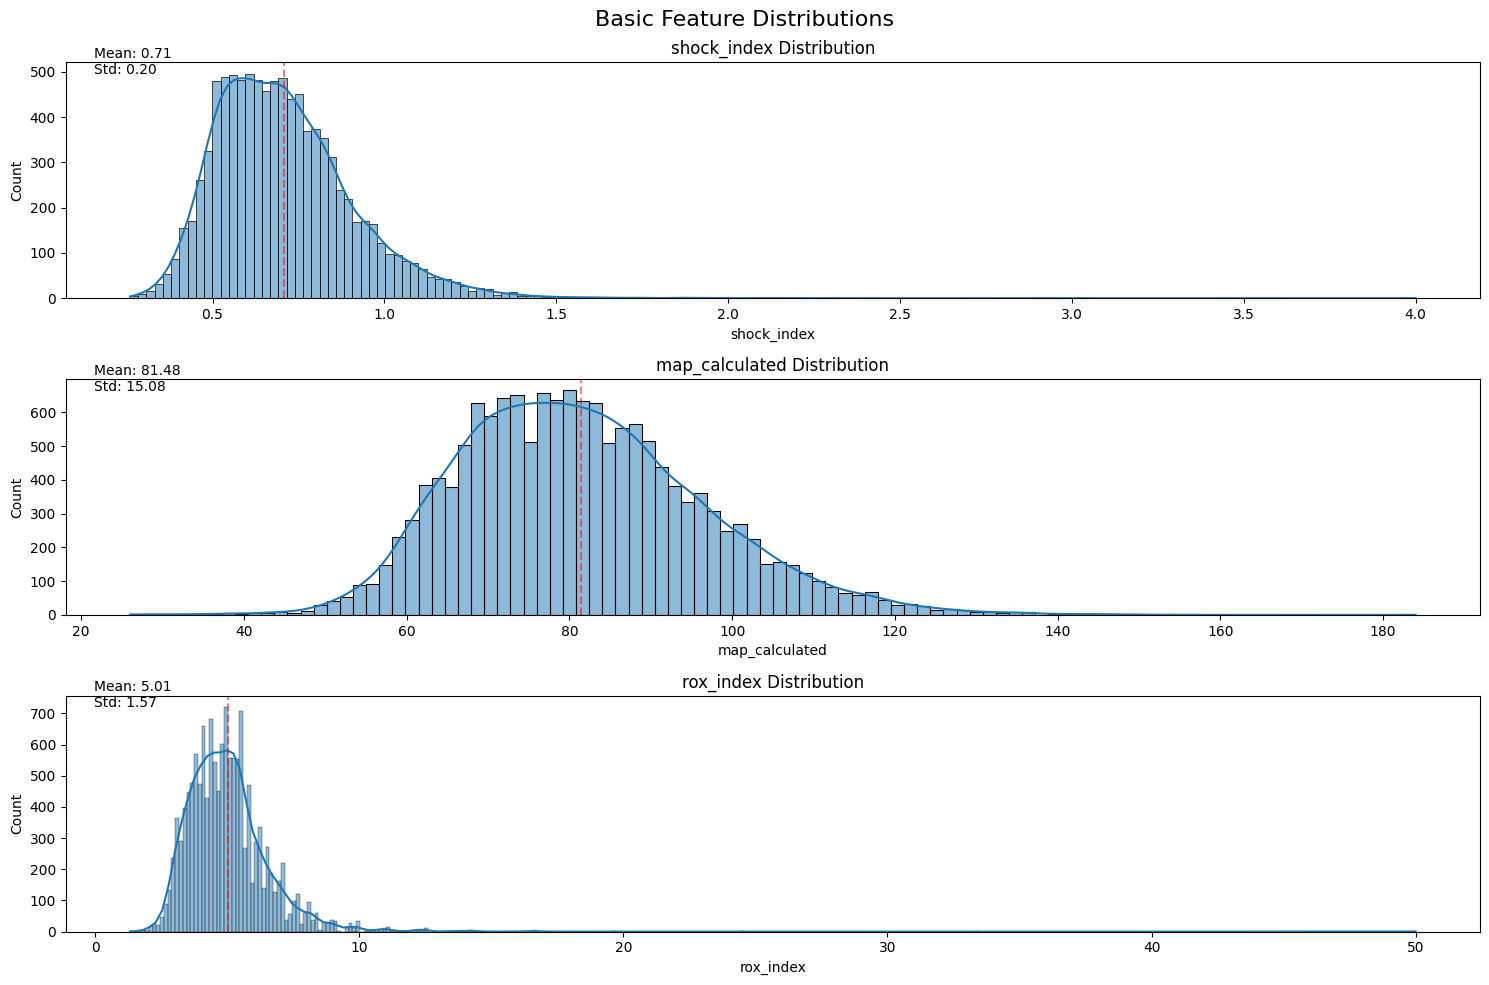

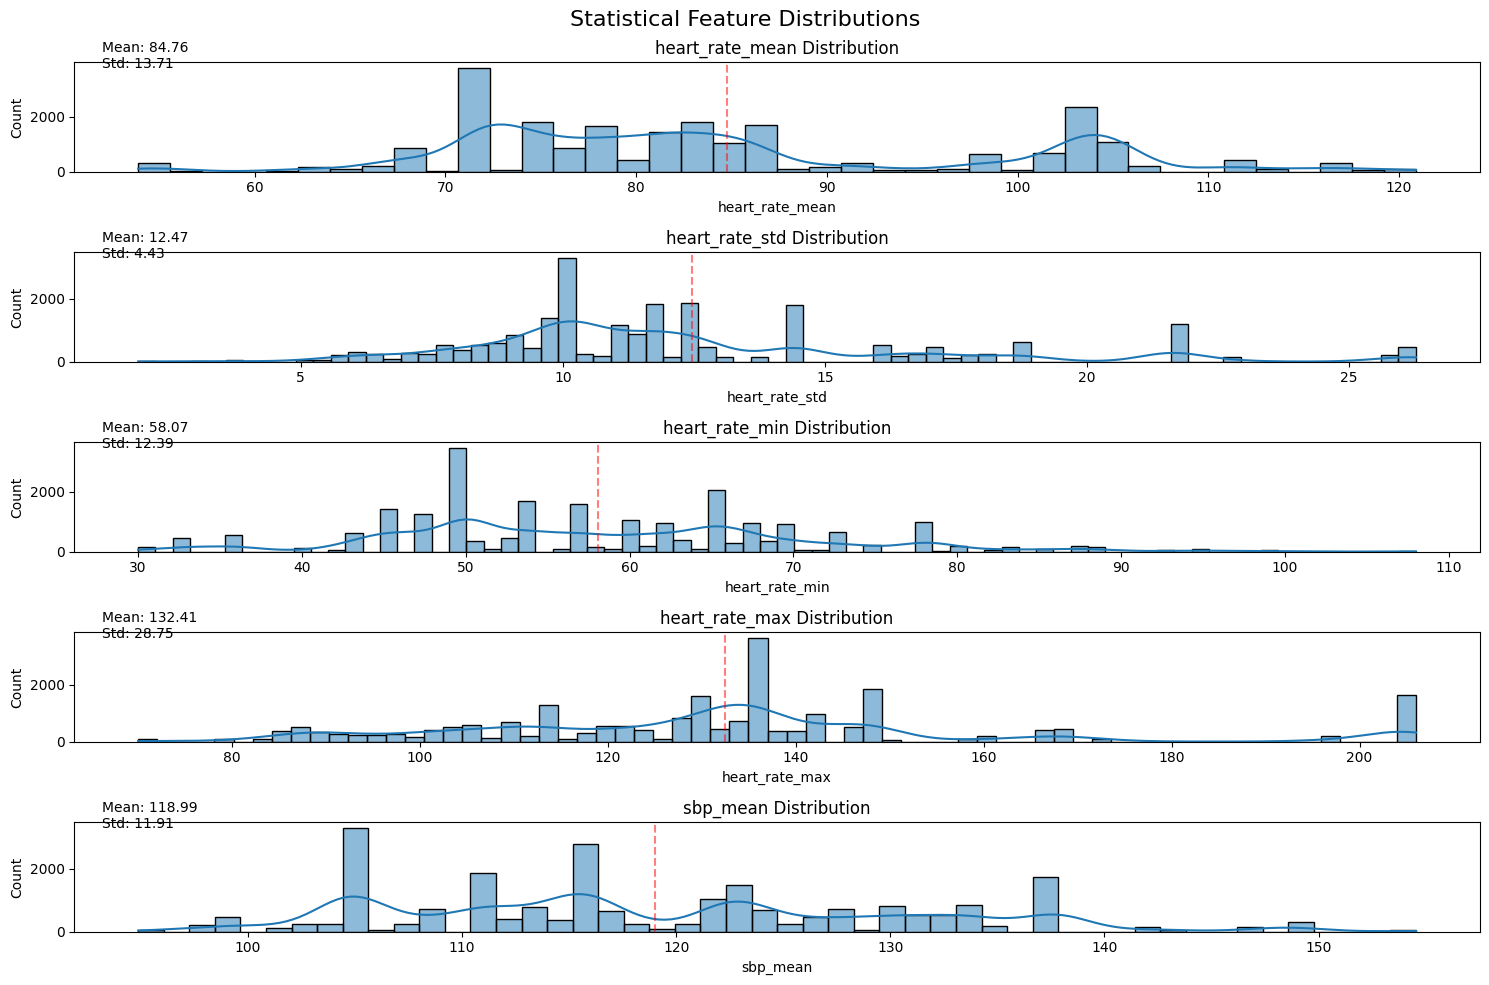

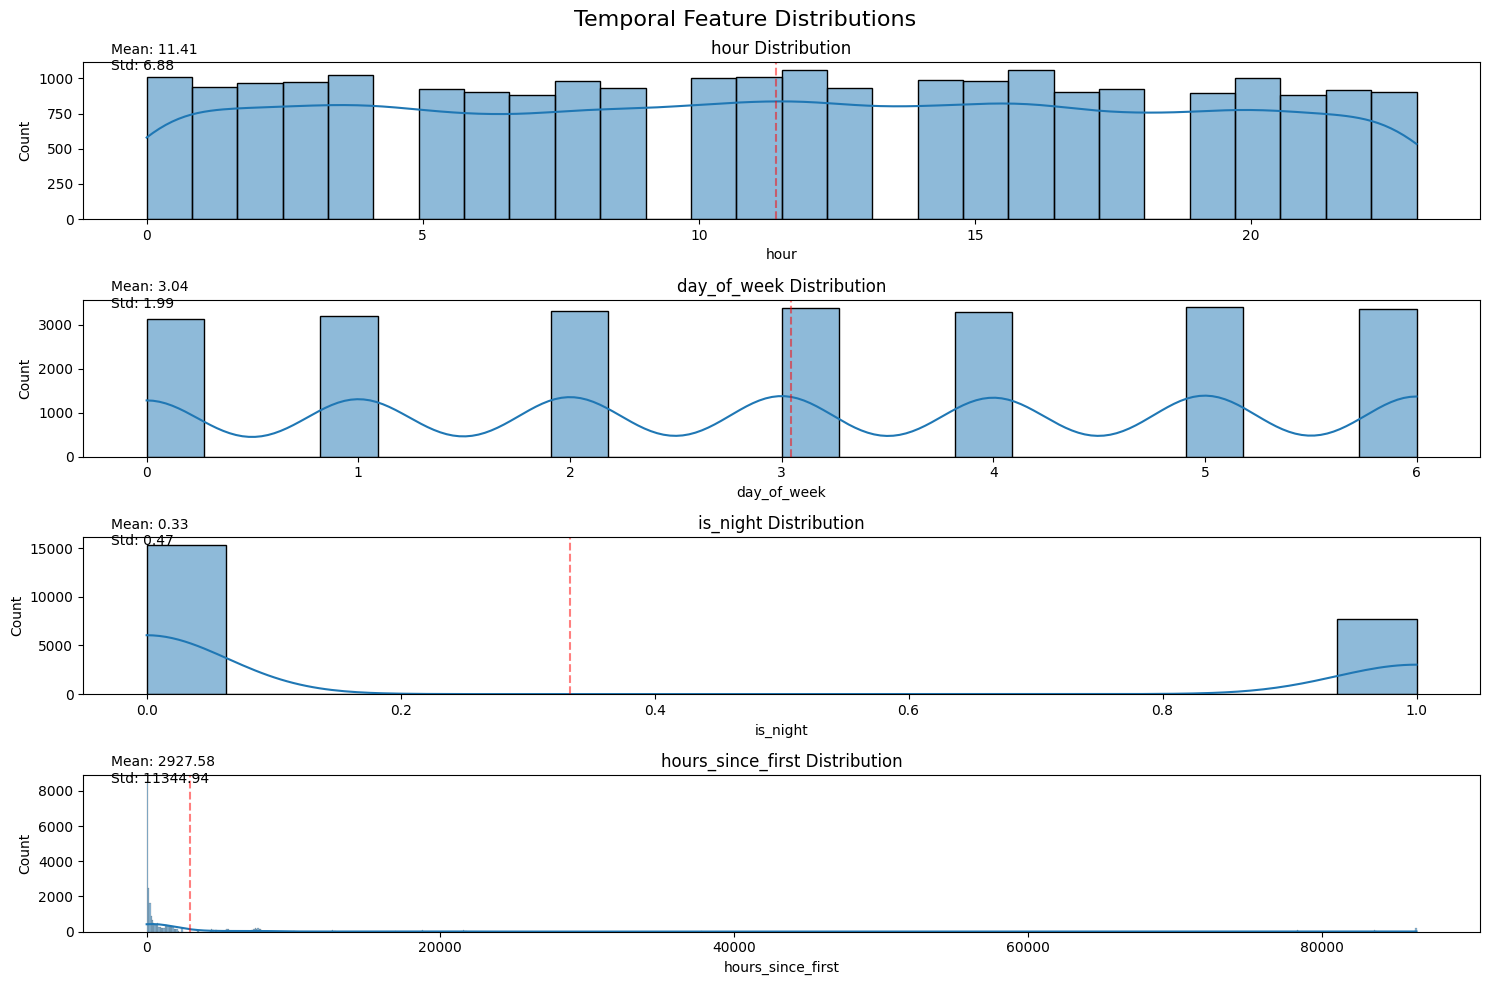

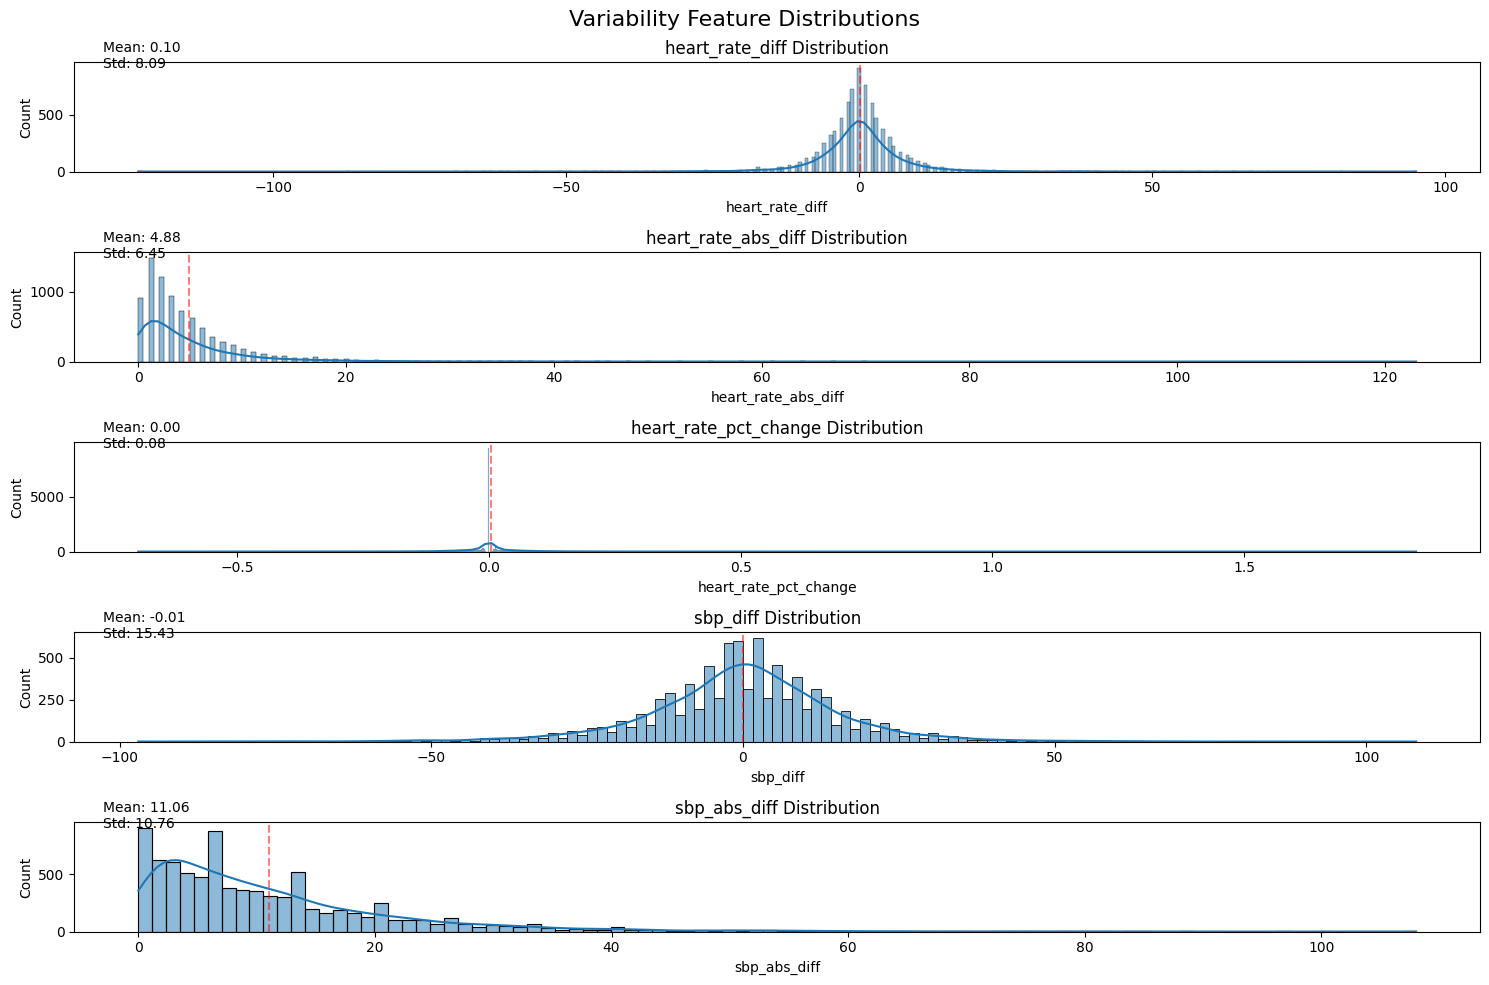

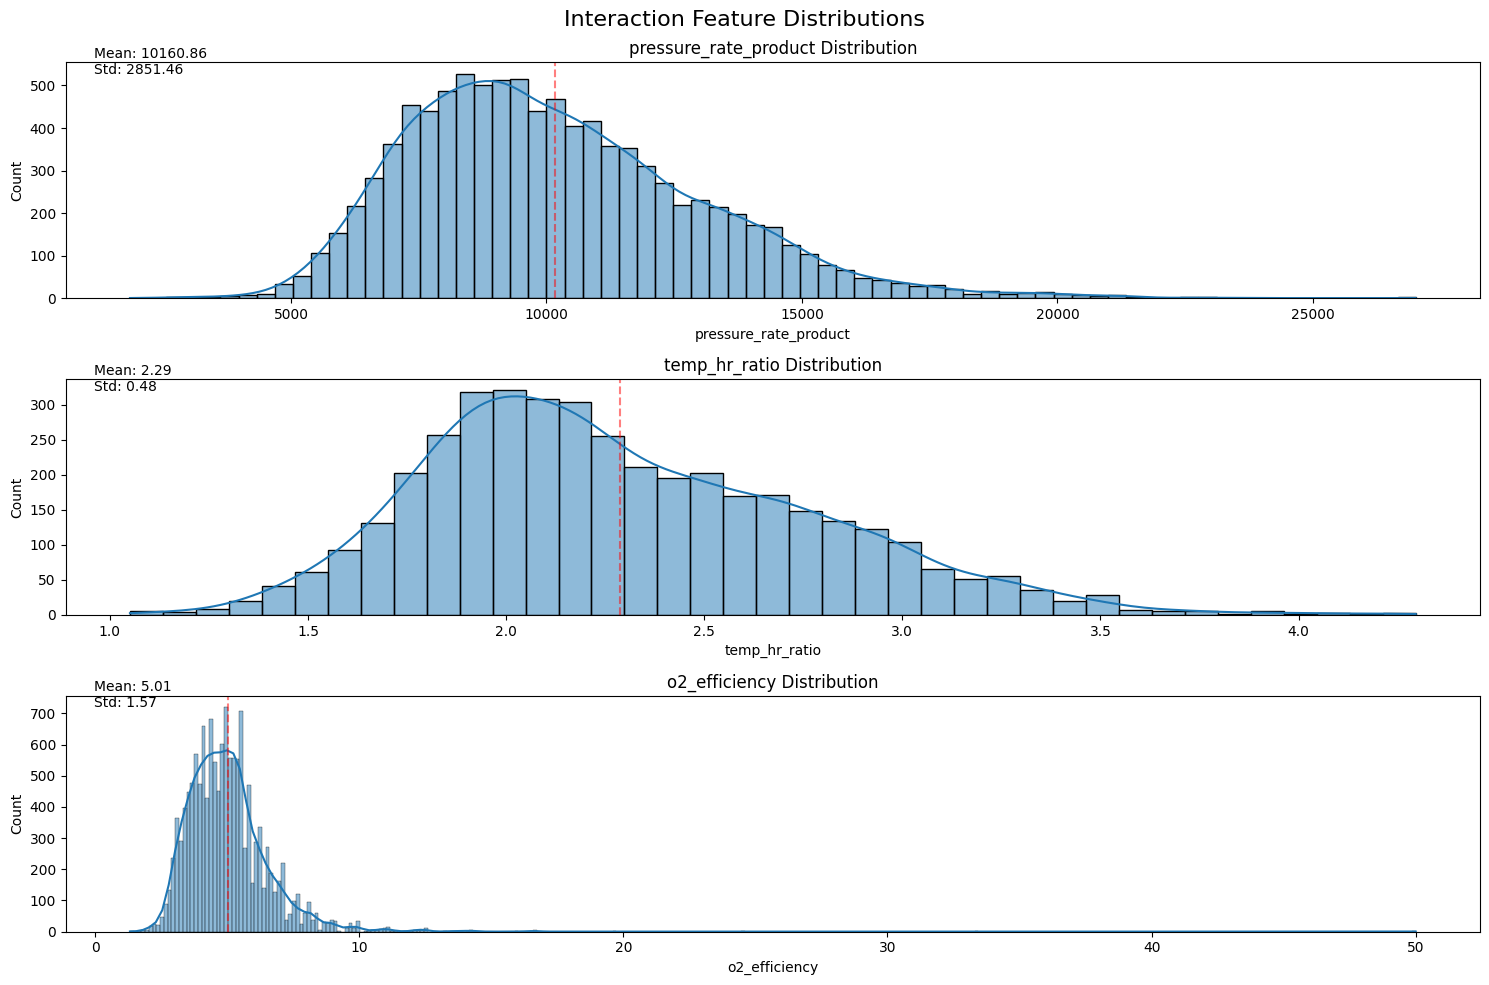

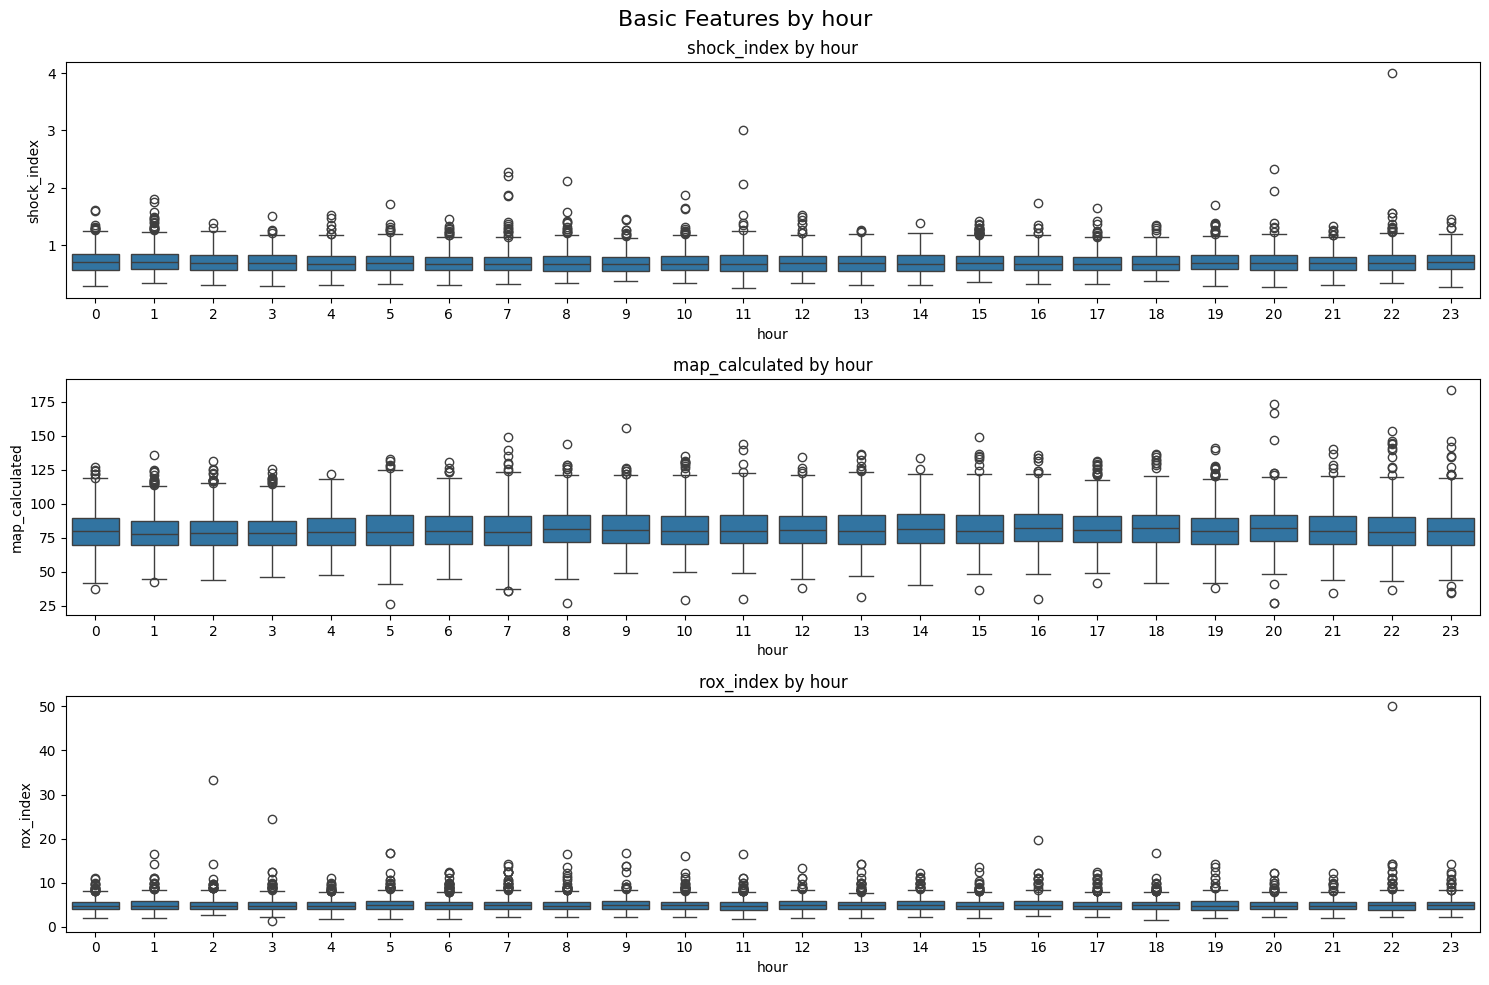

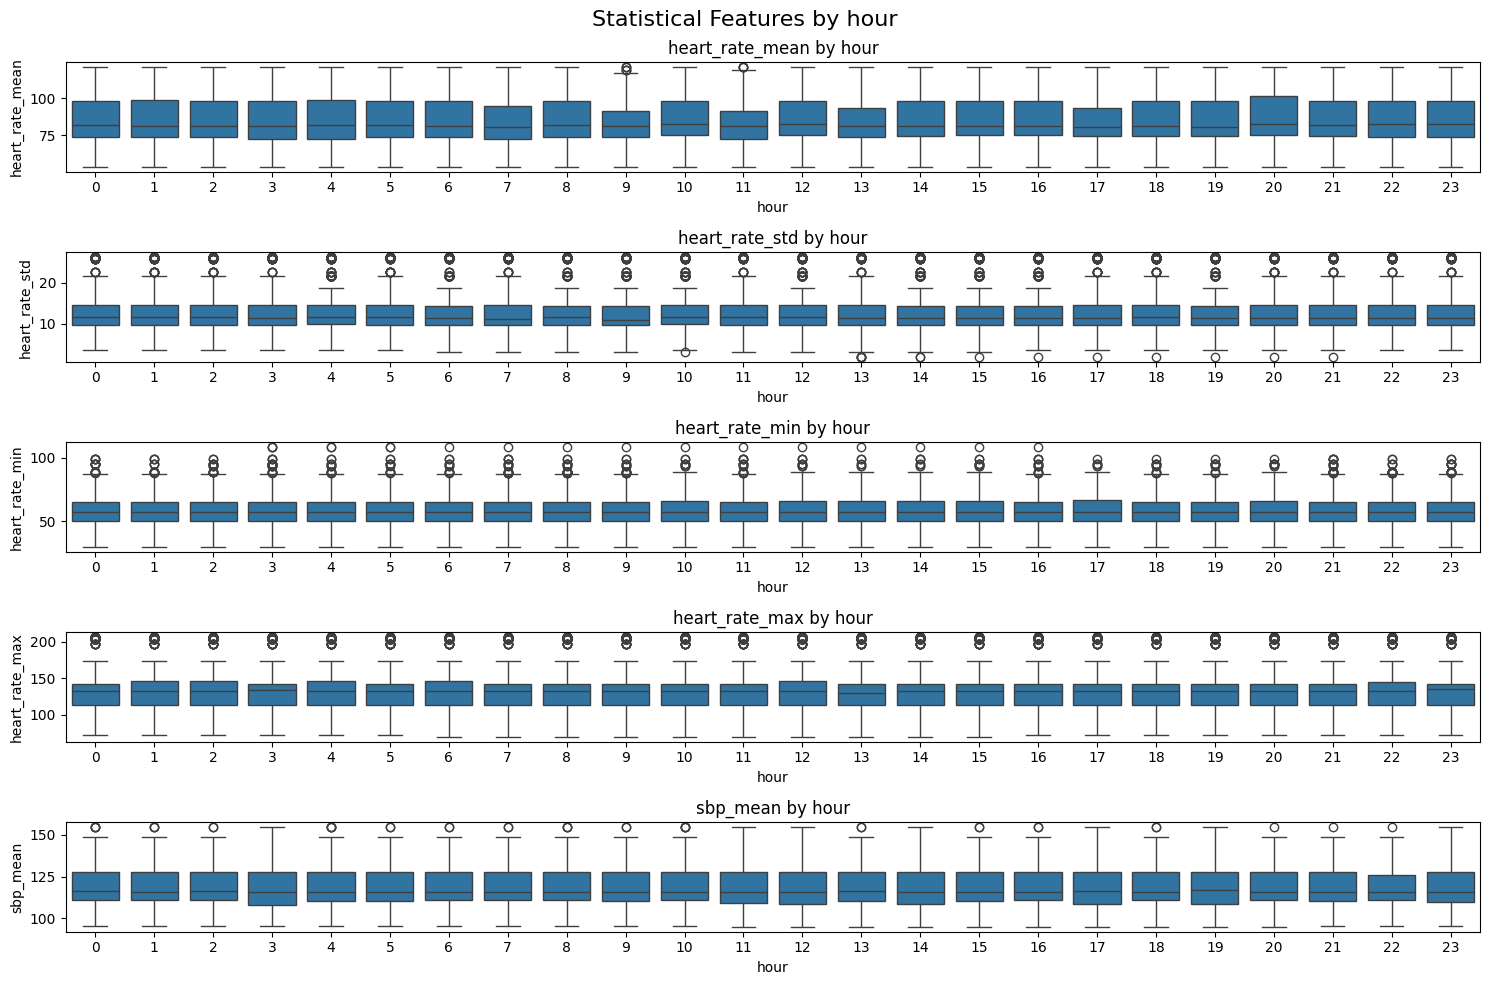

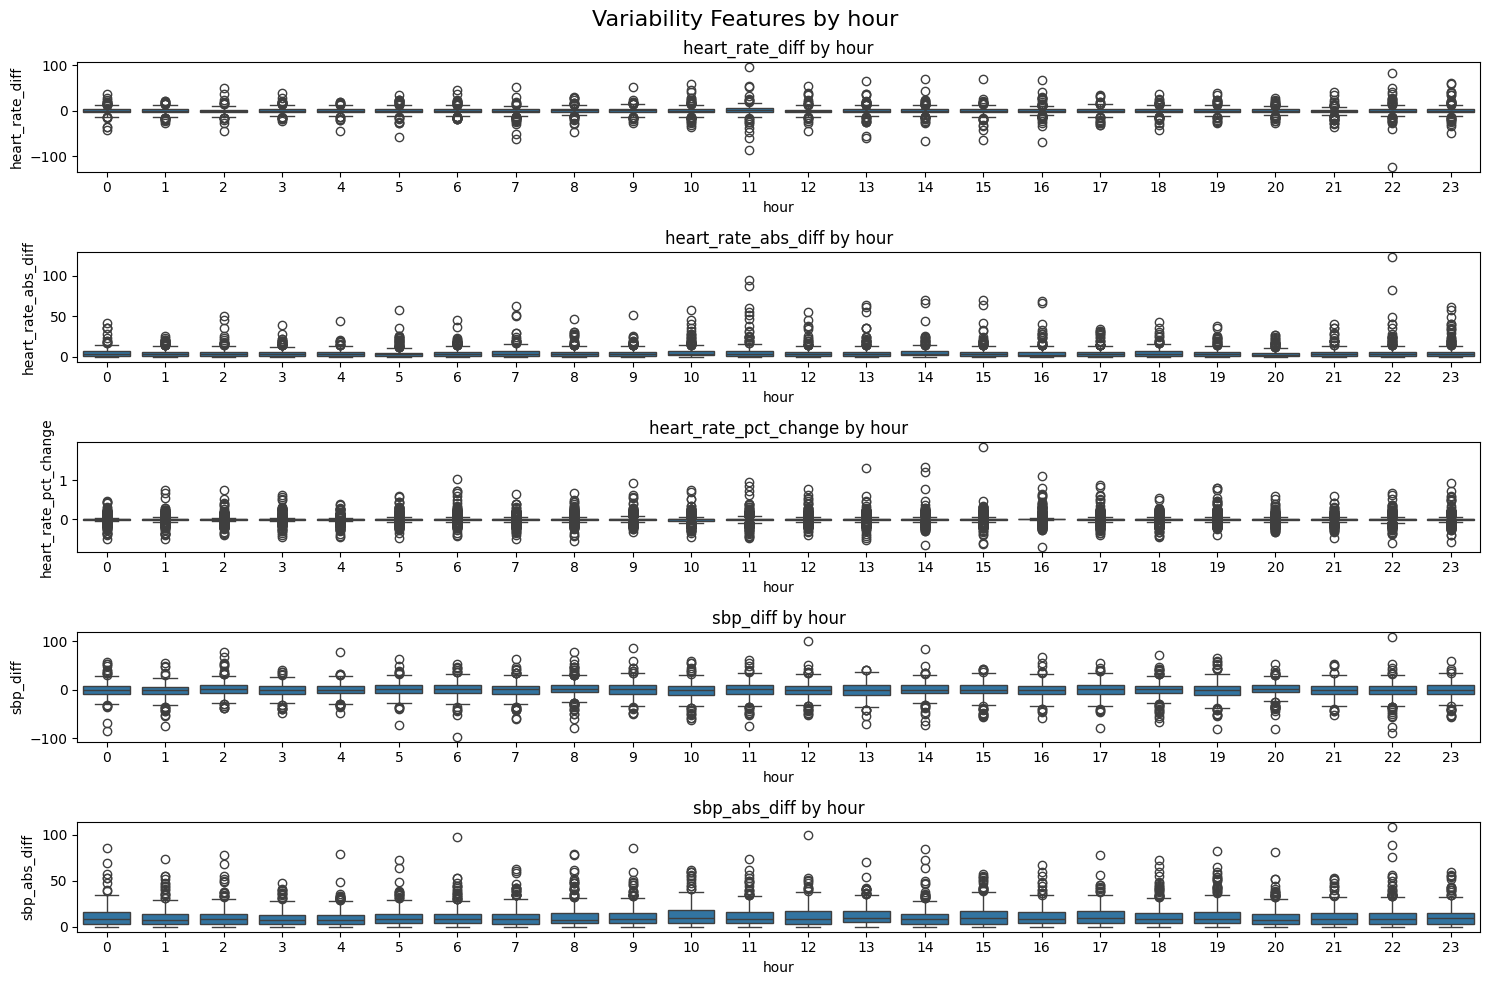

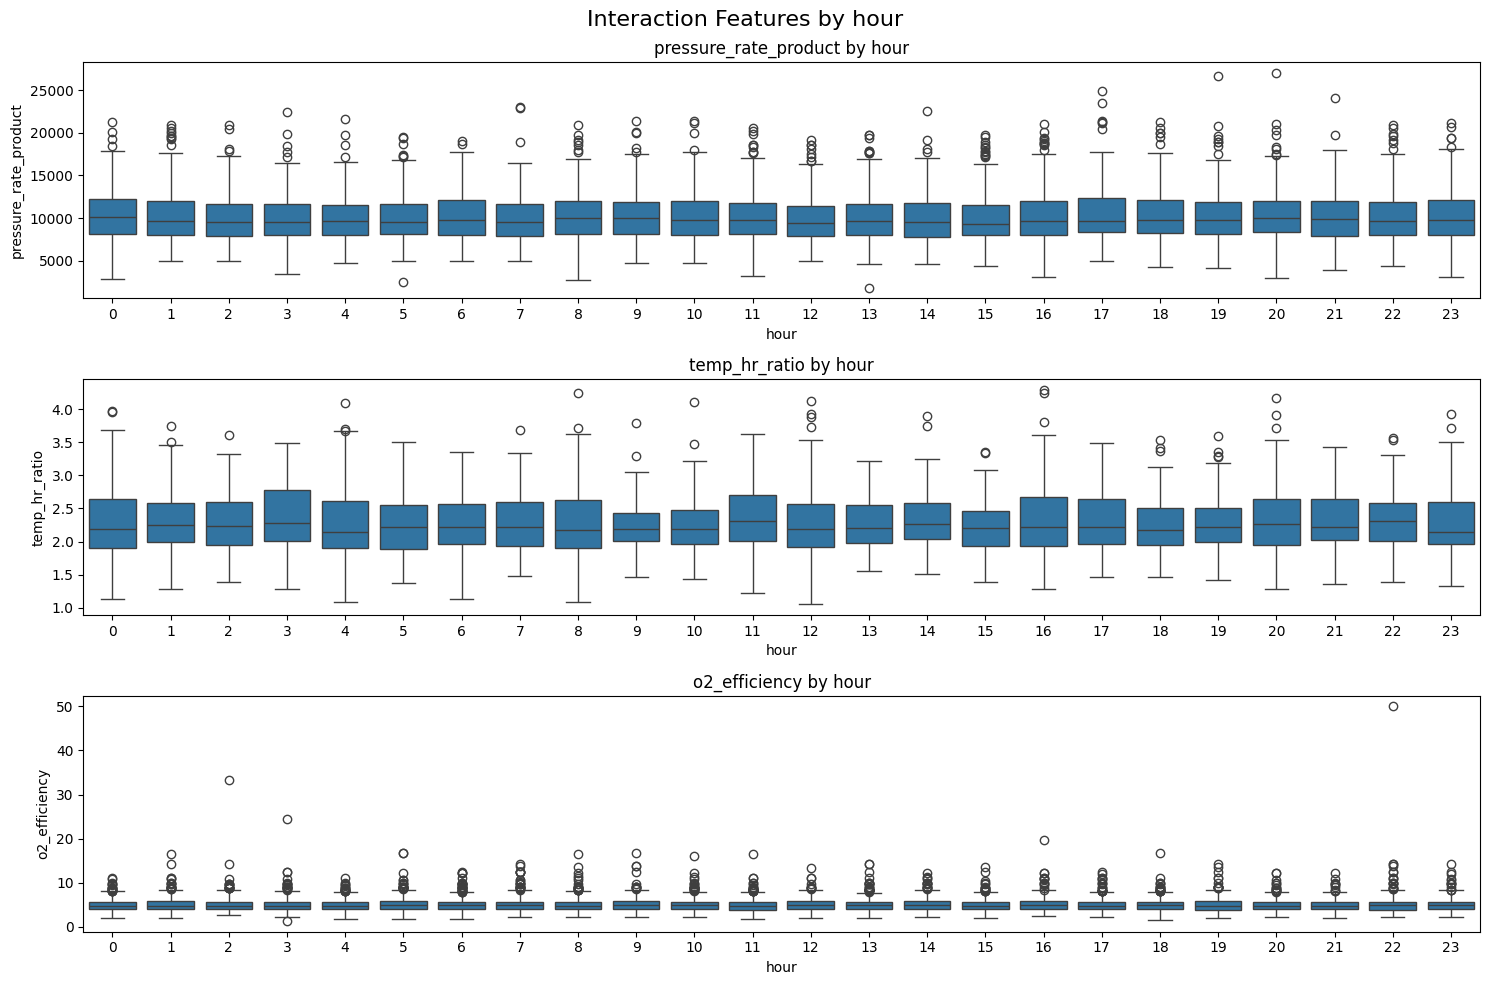

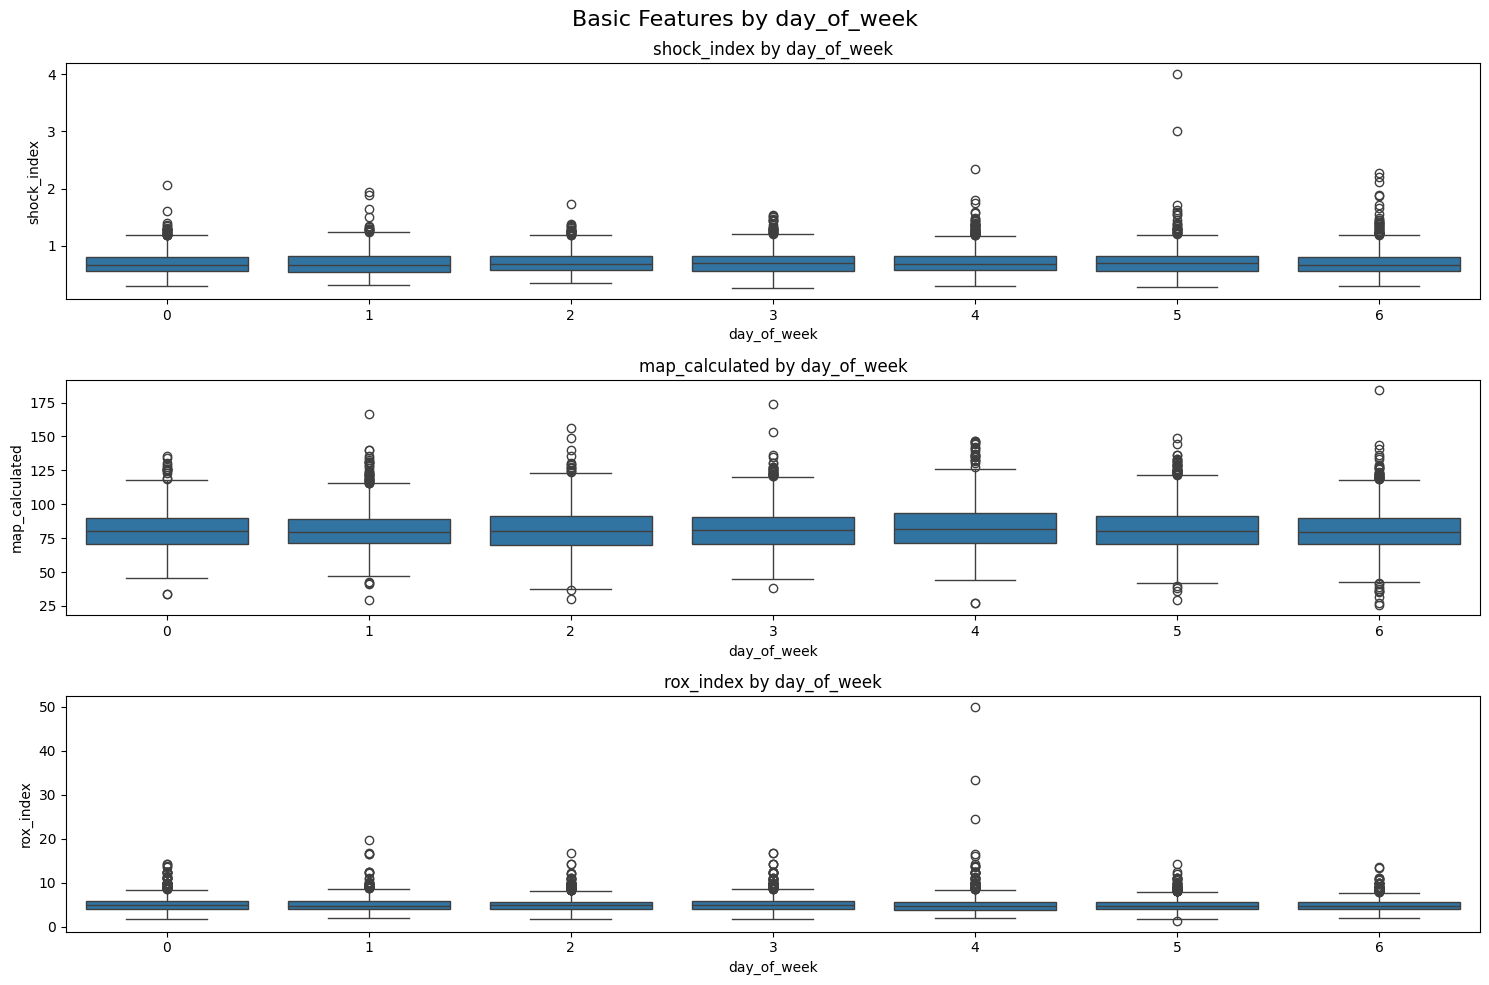

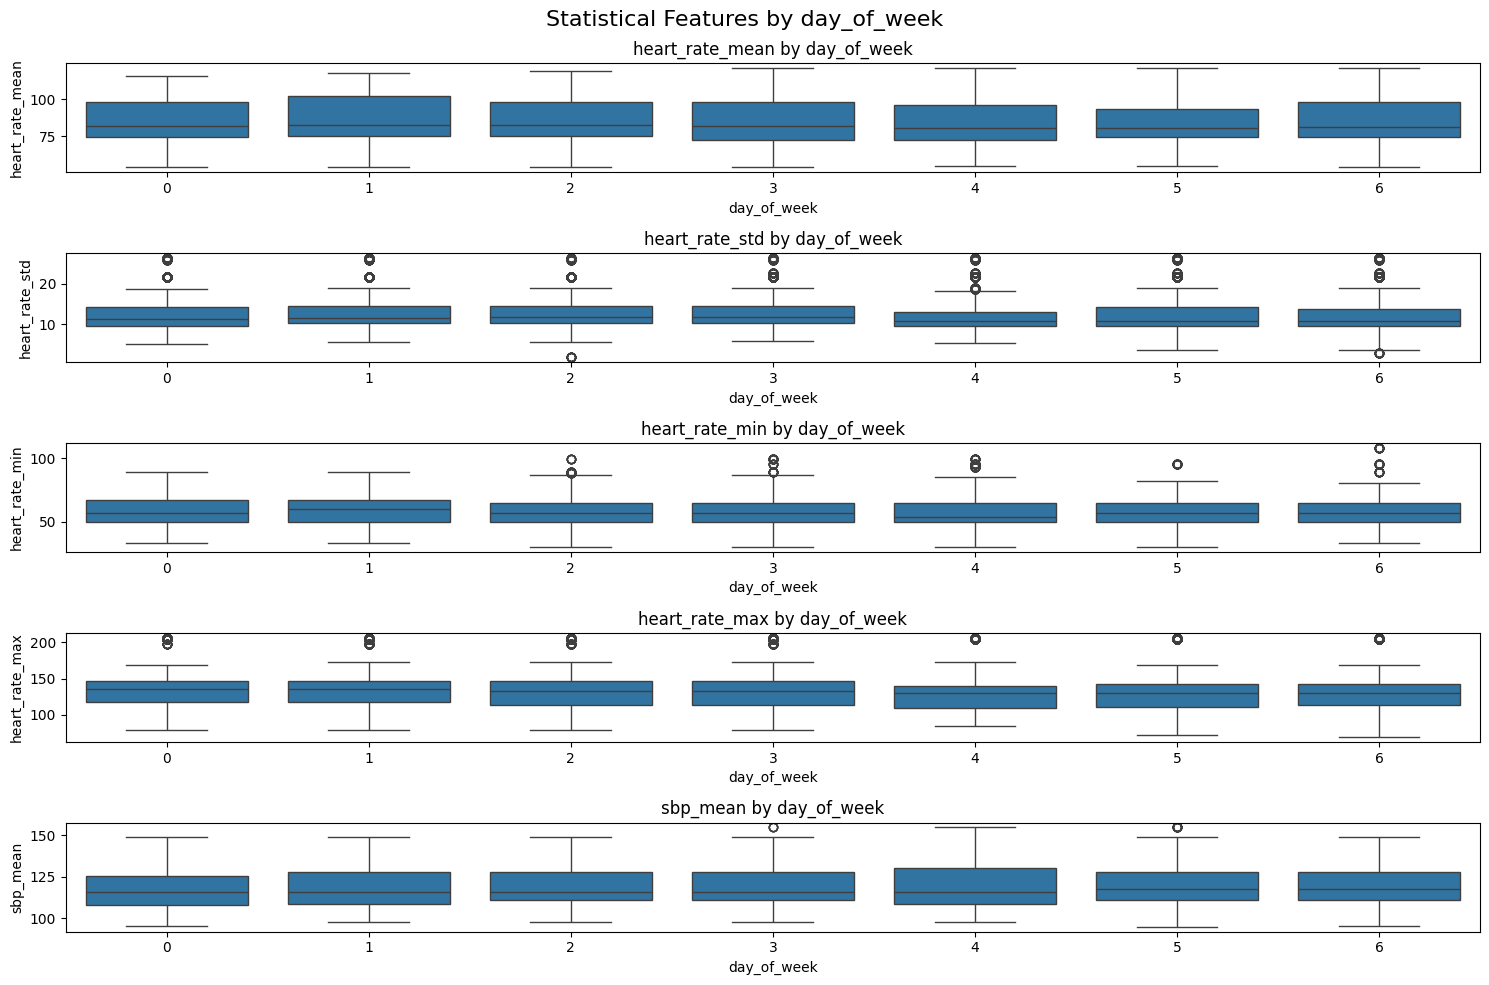

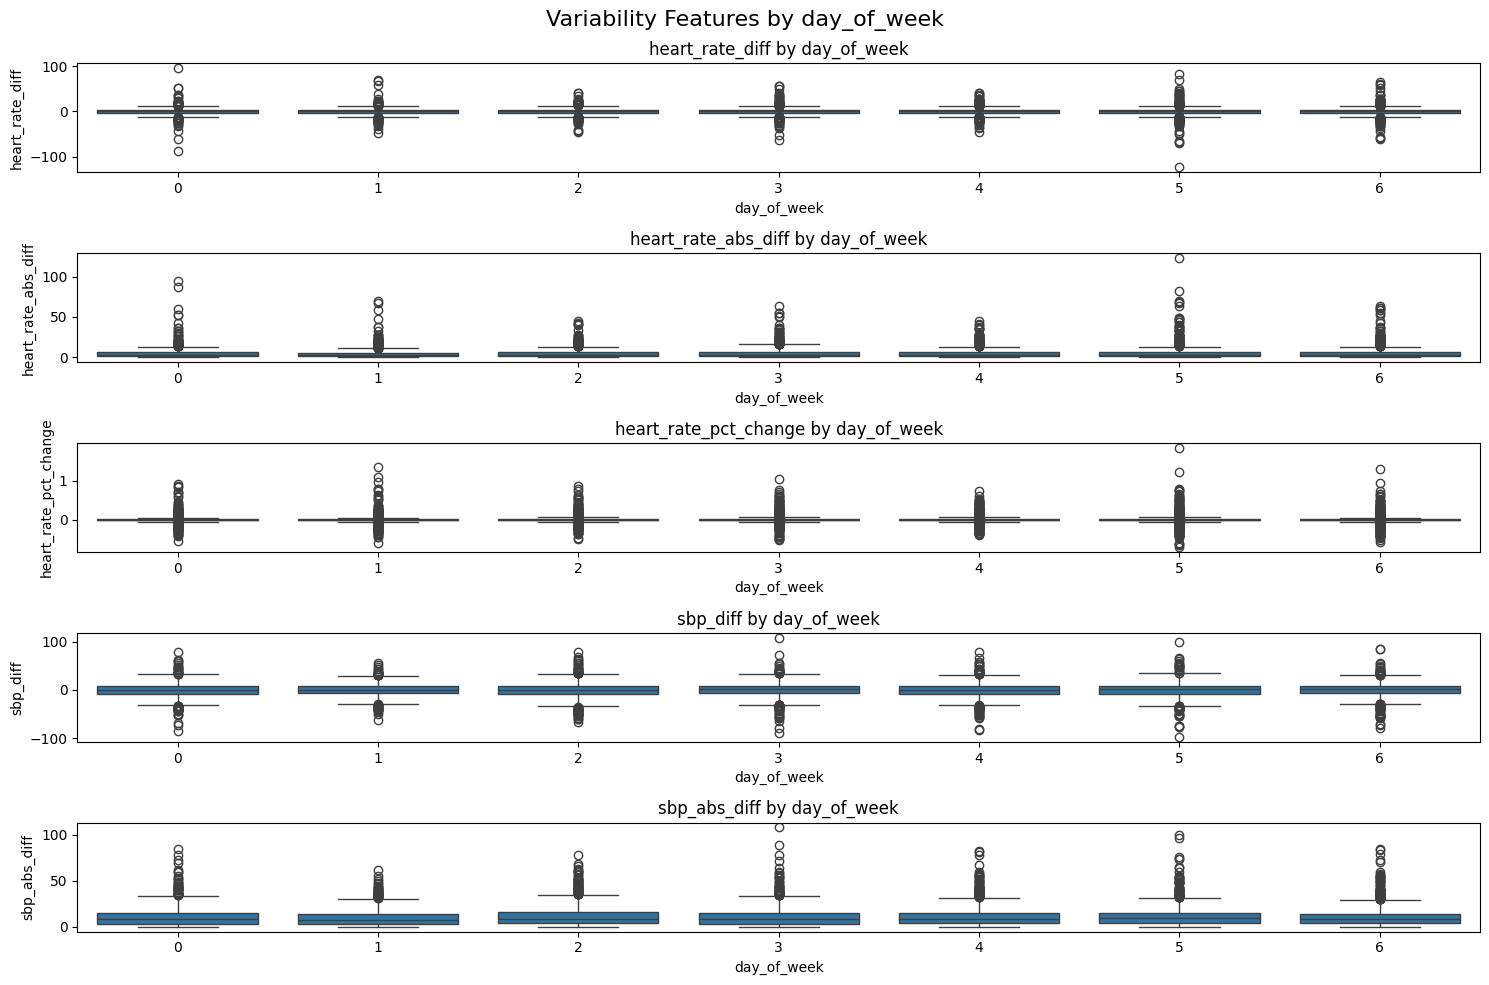

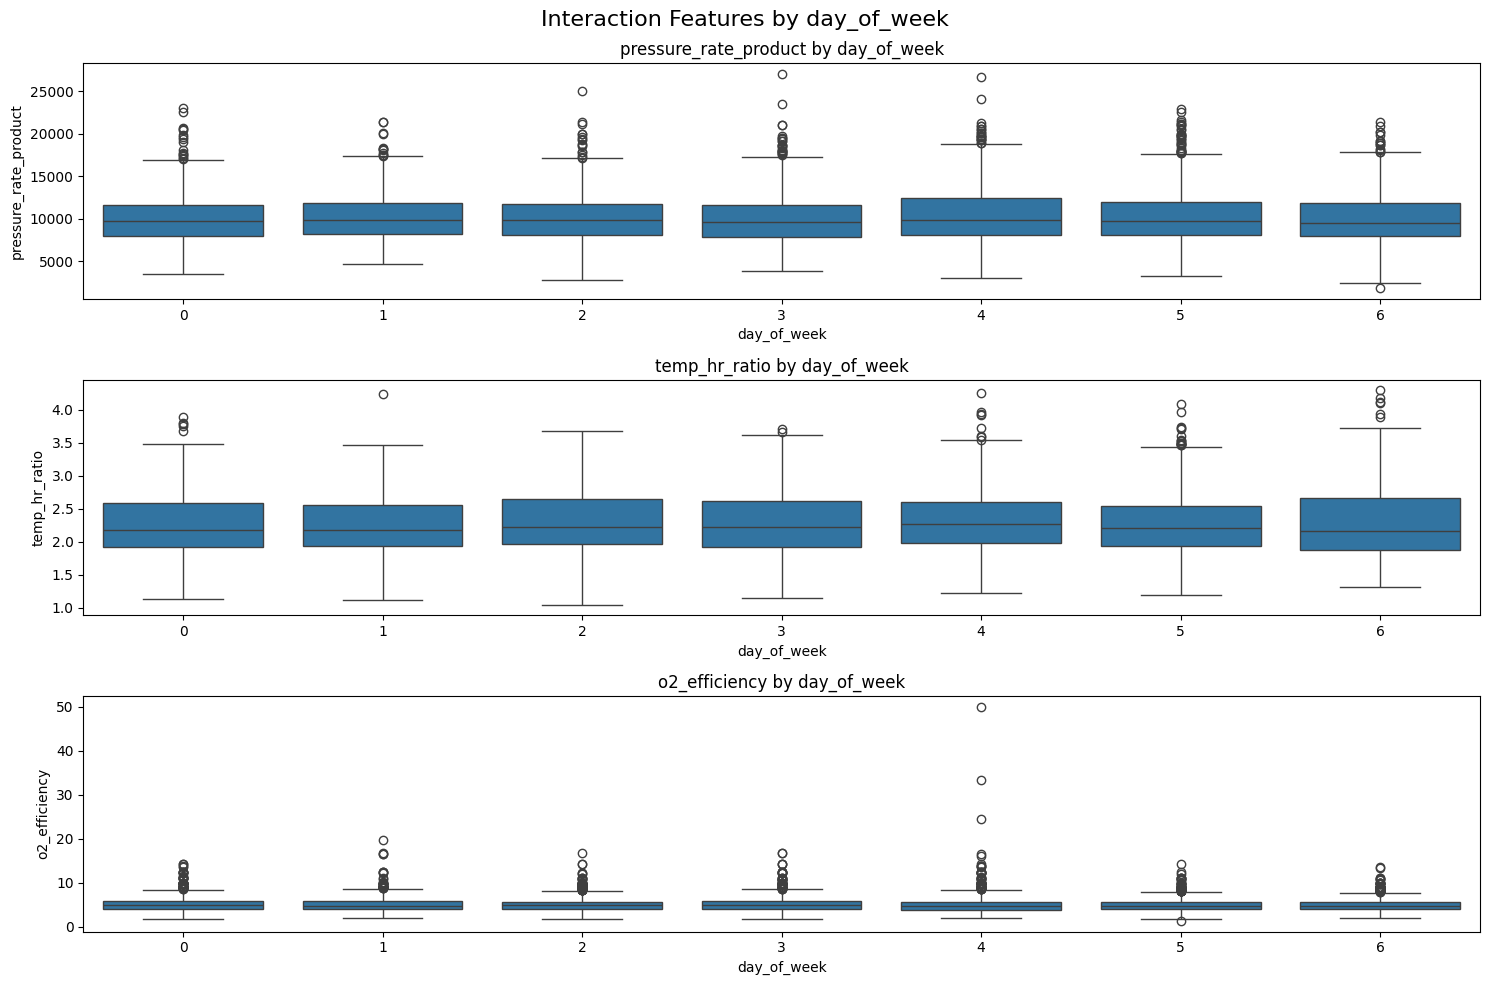

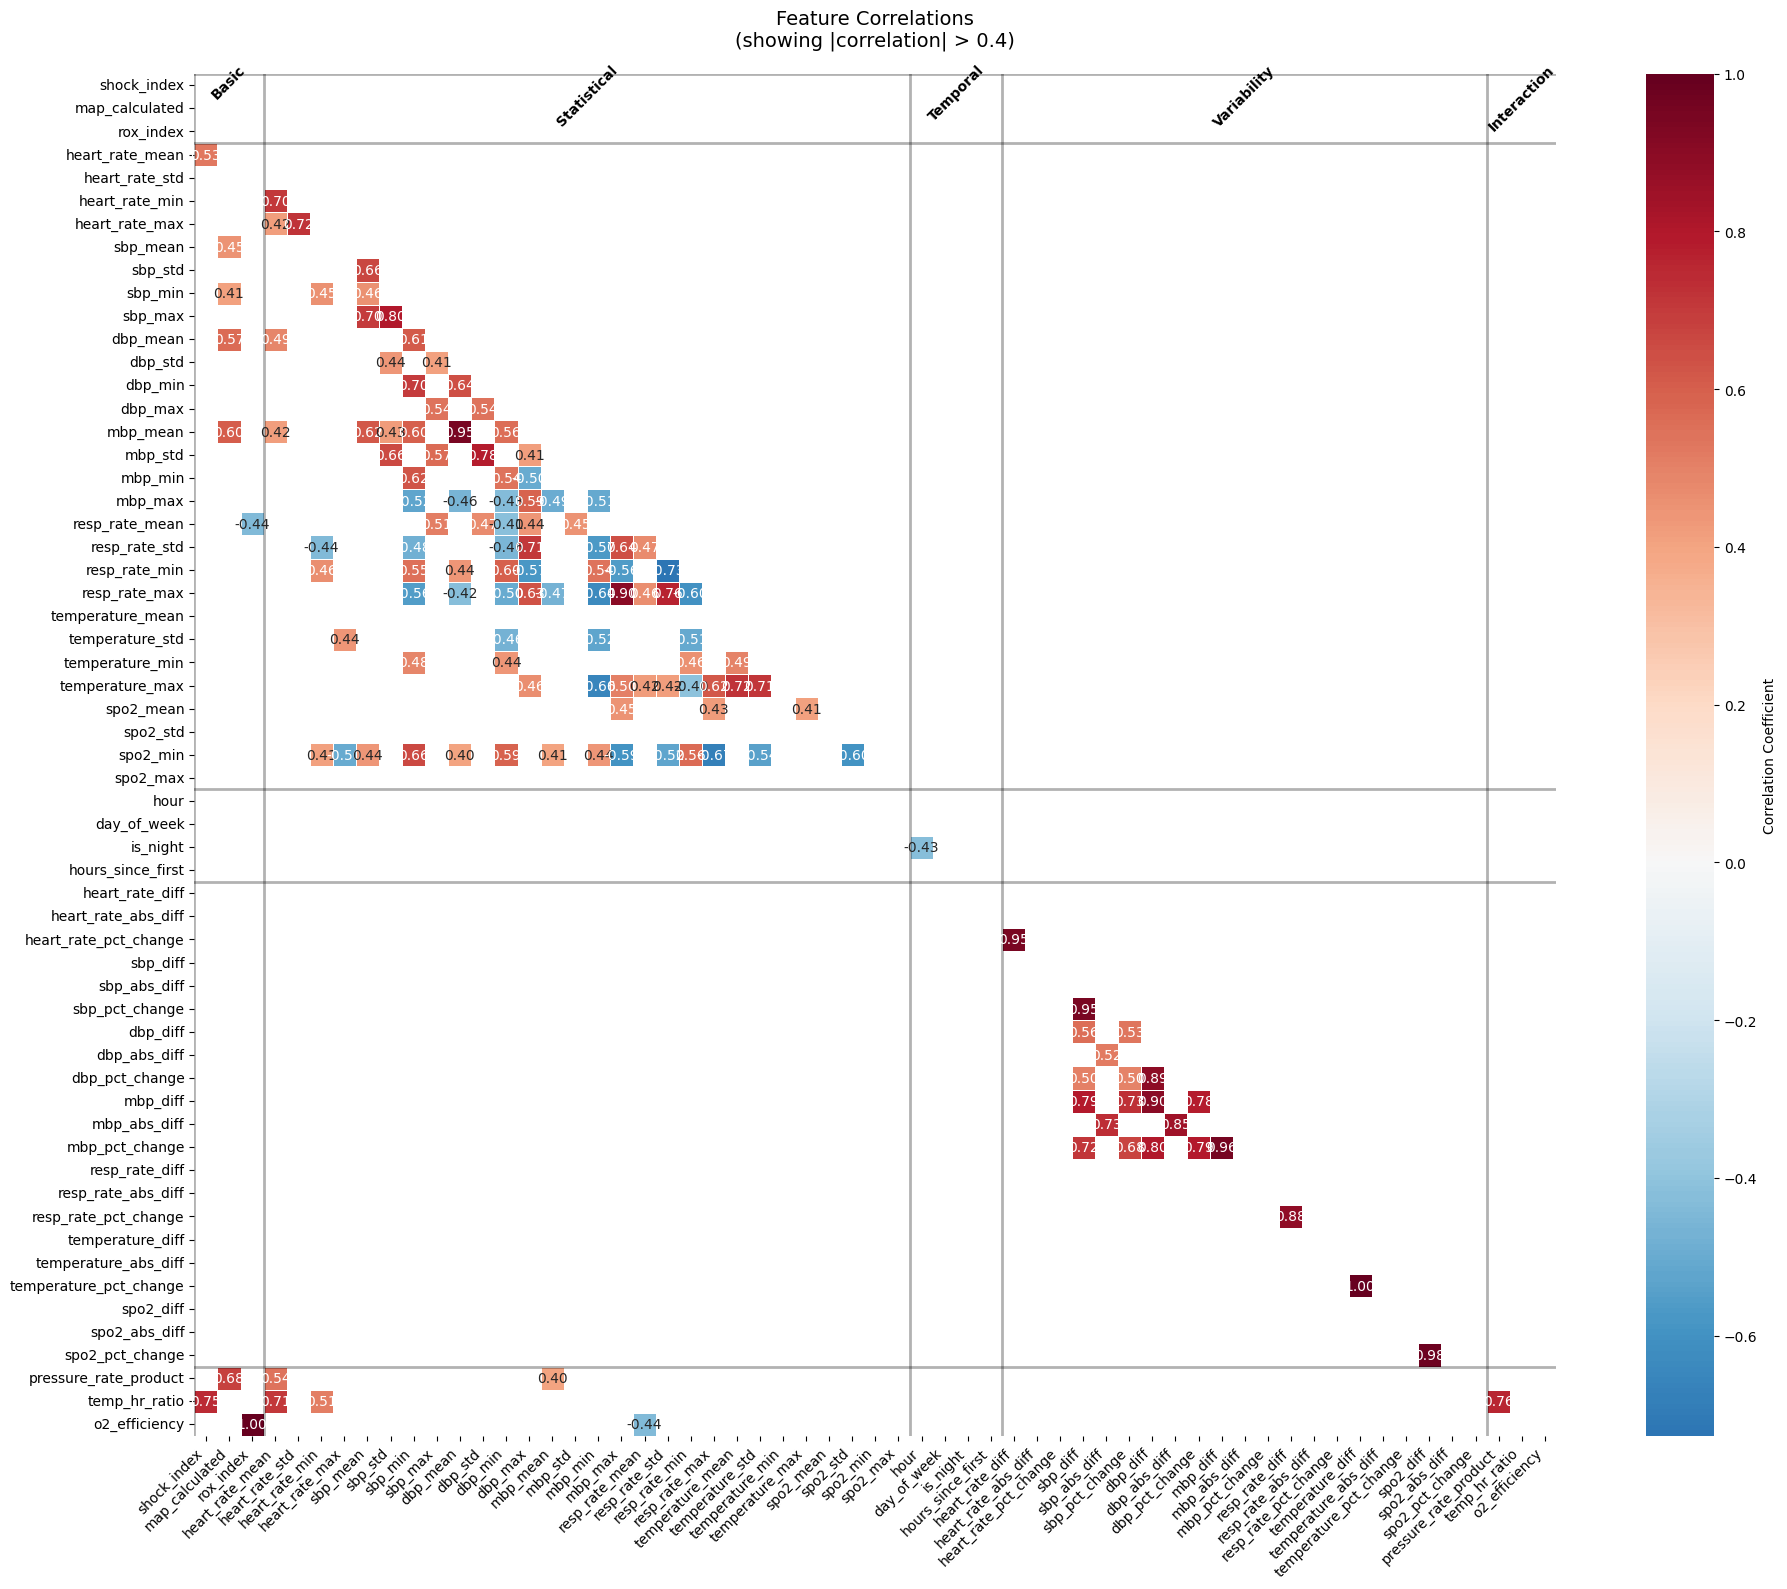

In [35]:
### visualize feature distributions
plot_feature_distributions(feature_df, feature_types)
### visualize temporal patterns
plot_temporal_patterns(feature_df, feature_types, time_unit='hour')
plot_temporal_patterns(feature_df, feature_types, time_unit='day_of_week')
### visualize feature correlations
plot_feature_correlations(feature_df, feature_types, threshold=0.4, figsize=(20, 16))

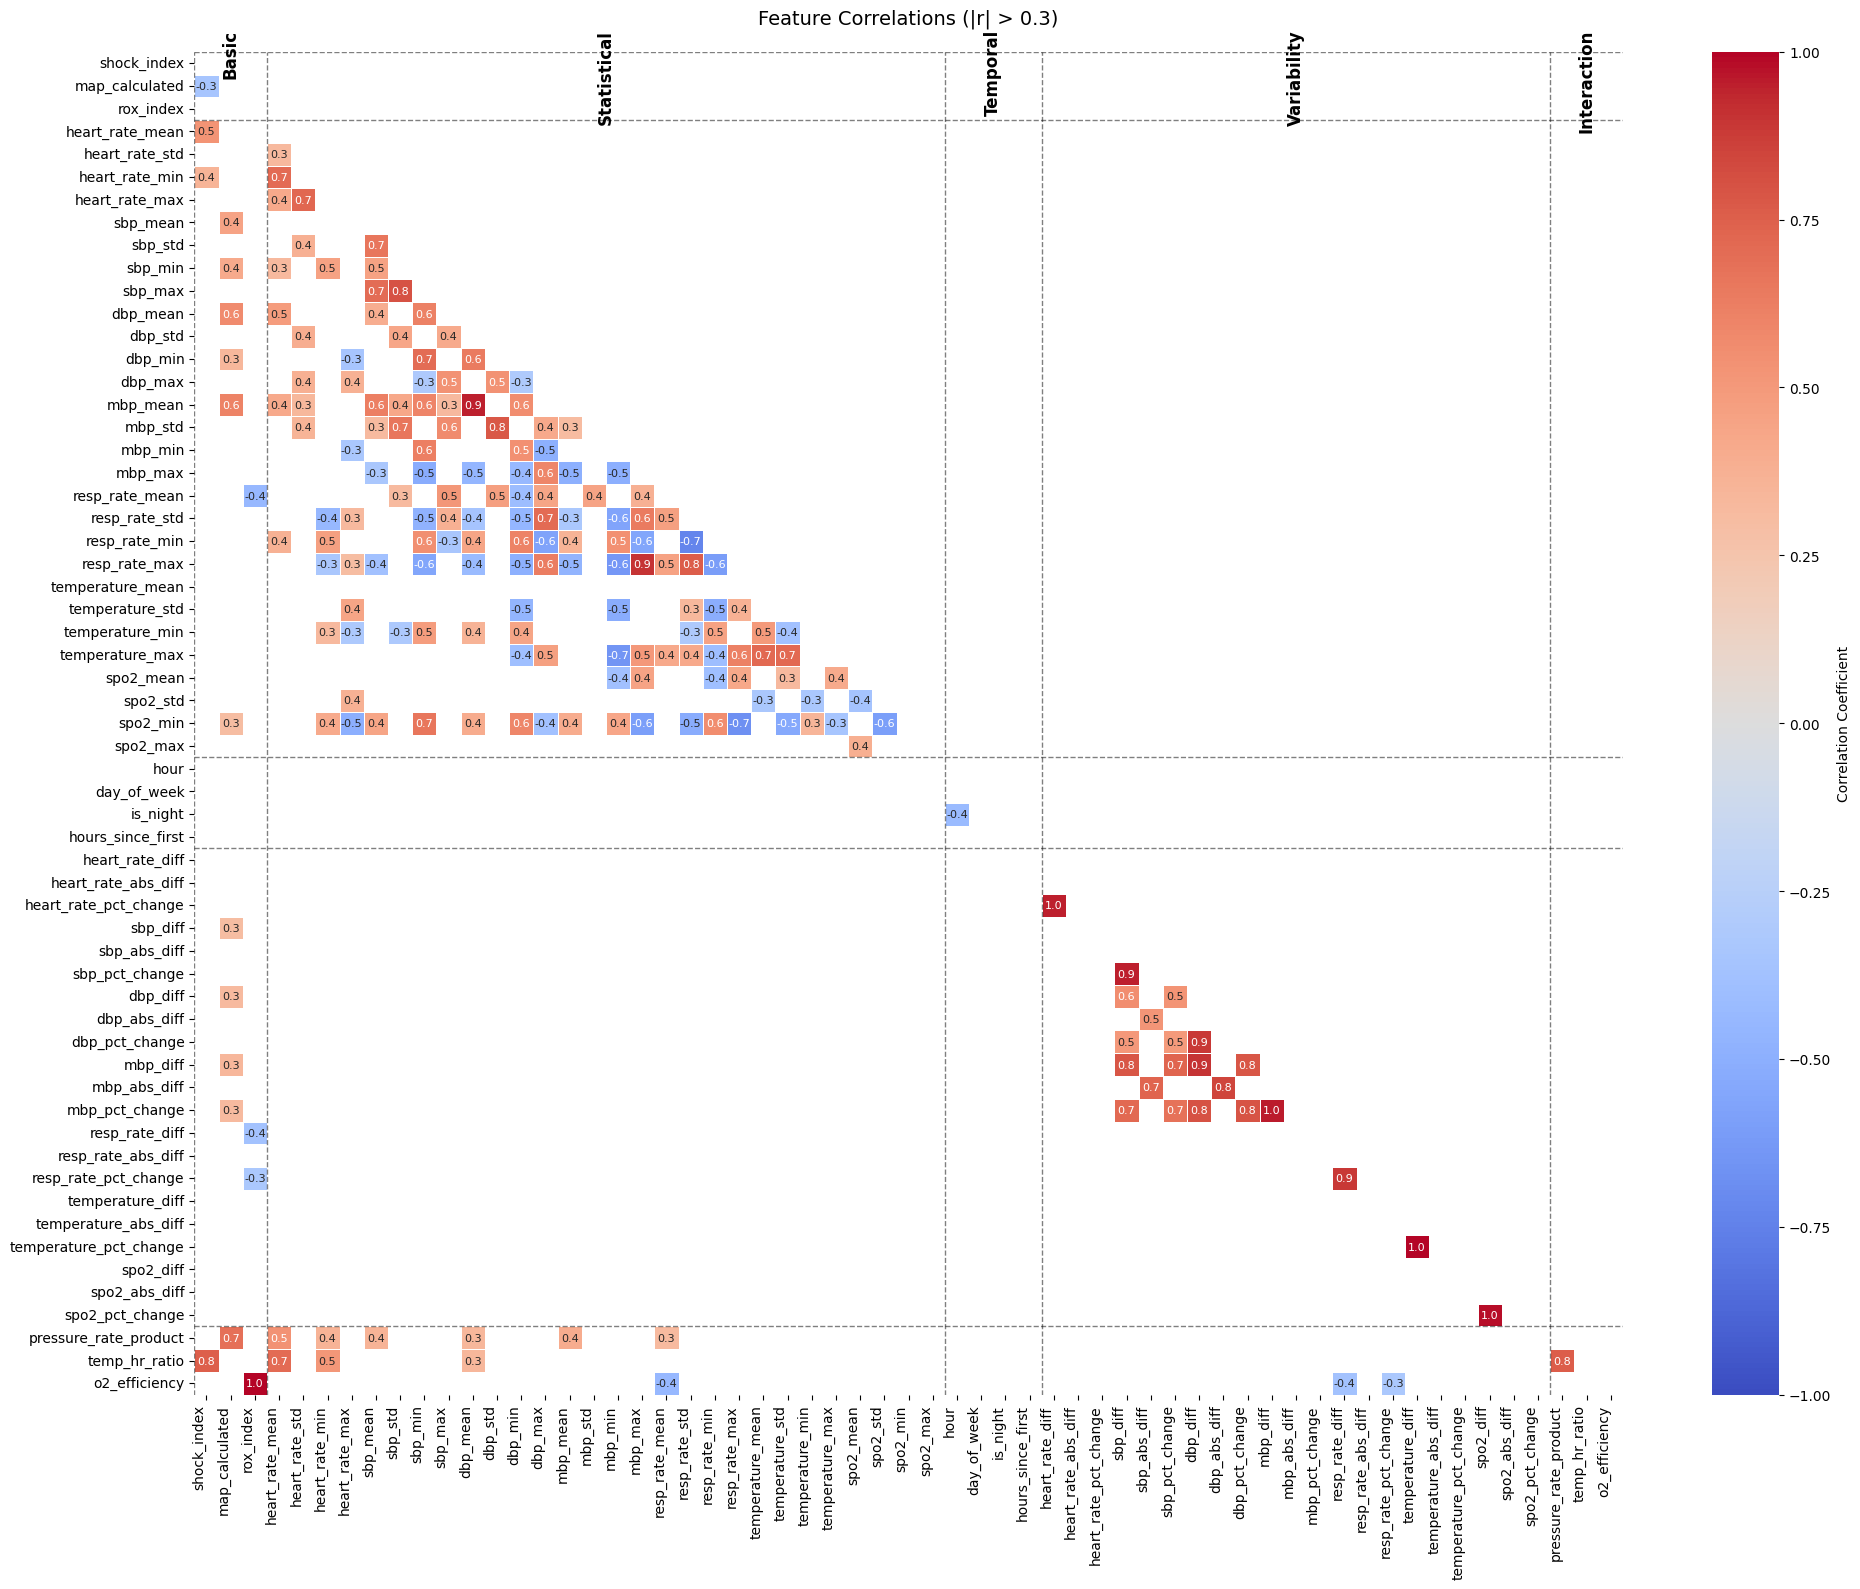

In [36]:
### plot_feature_correlations_r1; revised correlation fn, tweaks for visual readability...
def plot_feature_correlations_r1(df, feature_types, threshold=0.3, figsize=(20, 16)):
    """
    Plot correlation heatmap for features within and between types with improved readability.
    
    Args:
        df: DataFrame with features
        feature_types: Dictionary mapping feature types to feature lists
        threshold: Correlation threshold to display
        figsize: Figure size tuple
    """
    # Ensure we have a clean index
    plot_df = df.reset_index(drop=True)
    
    # Get all features and organize by type
    feature_map = {f: ftype for ftype, features in feature_types.items() for f in features if f in plot_df.columns}
    
    # Compute correlation matrix
    corr_matrix = plot_df[list(feature_map.keys())].corr()
    
    # Create a mask for low correlations and the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    corr_matrix = corr_matrix.where(np.abs(corr_matrix) > threshold)  # Keep only strong correlations
    
    # Initialize the figure
    plt.figure(figsize=figsize)
    
    # Create heatmap with improved visualization
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        cmap='coolwarm',  # Smooth transition of colors
        center=0,
        annot=True,
        fmt='.1f',  # Reduce decimal places
        annot_kws={"size": 8},  # Improve annotation readability
        linewidths=0.5,
        cbar_kws={'label': 'Correlation Coefficient'},
        vmin=-1, vmax=1  # Ensure full correlation range is visualized
    )

    # Improve axis labels
    plt.xticks(rotation=90, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    # Add feature type separators
    ax = plt.gca()
    current_pos = 0
    for ftype, features in feature_types.items():
        num_features = sum(f in feature_map for f in features)
        if num_features:
            ax.axvline(x=current_pos, color='black', linewidth=1, linestyle='dashed', alpha=0.5)
            ax.axhline(y=current_pos, color='black', linewidth=1, linestyle='dashed', alpha=0.5)
            plt.text(current_pos + num_features / 2, -1, ftype, ha='center', va='top', 
                     fontsize=12, fontweight='bold', rotation=90)
            current_pos += num_features

    plt.title(f'Feature Correlations (|r| > {threshold})', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

### visualize feature correlations r1
plot_feature_correlations_r1(feature_df, feature_types)


Strongest Feature Correlations (|correlation| >= 0.7):
o2_efficiency ~ rox_index: 1.000
temperature_pct_chg ~ temperature_diff: 0.999
spo2_pct_chg ~ spo2_diff: 0.977
mbp_pct_chg ~ mbp_diff: 0.958
heart_pct_chg ~ heart_diff: 0.952
sbp_pct_chg ~ sbp_diff: 0.948
mbp_mean ~ dbp_mean: 0.947
resp_max ~ mbp_max: 0.905
mbp_diff ~ dbp_diff: 0.903
dbp_pct_chg ~ dbp_diff: 0.889


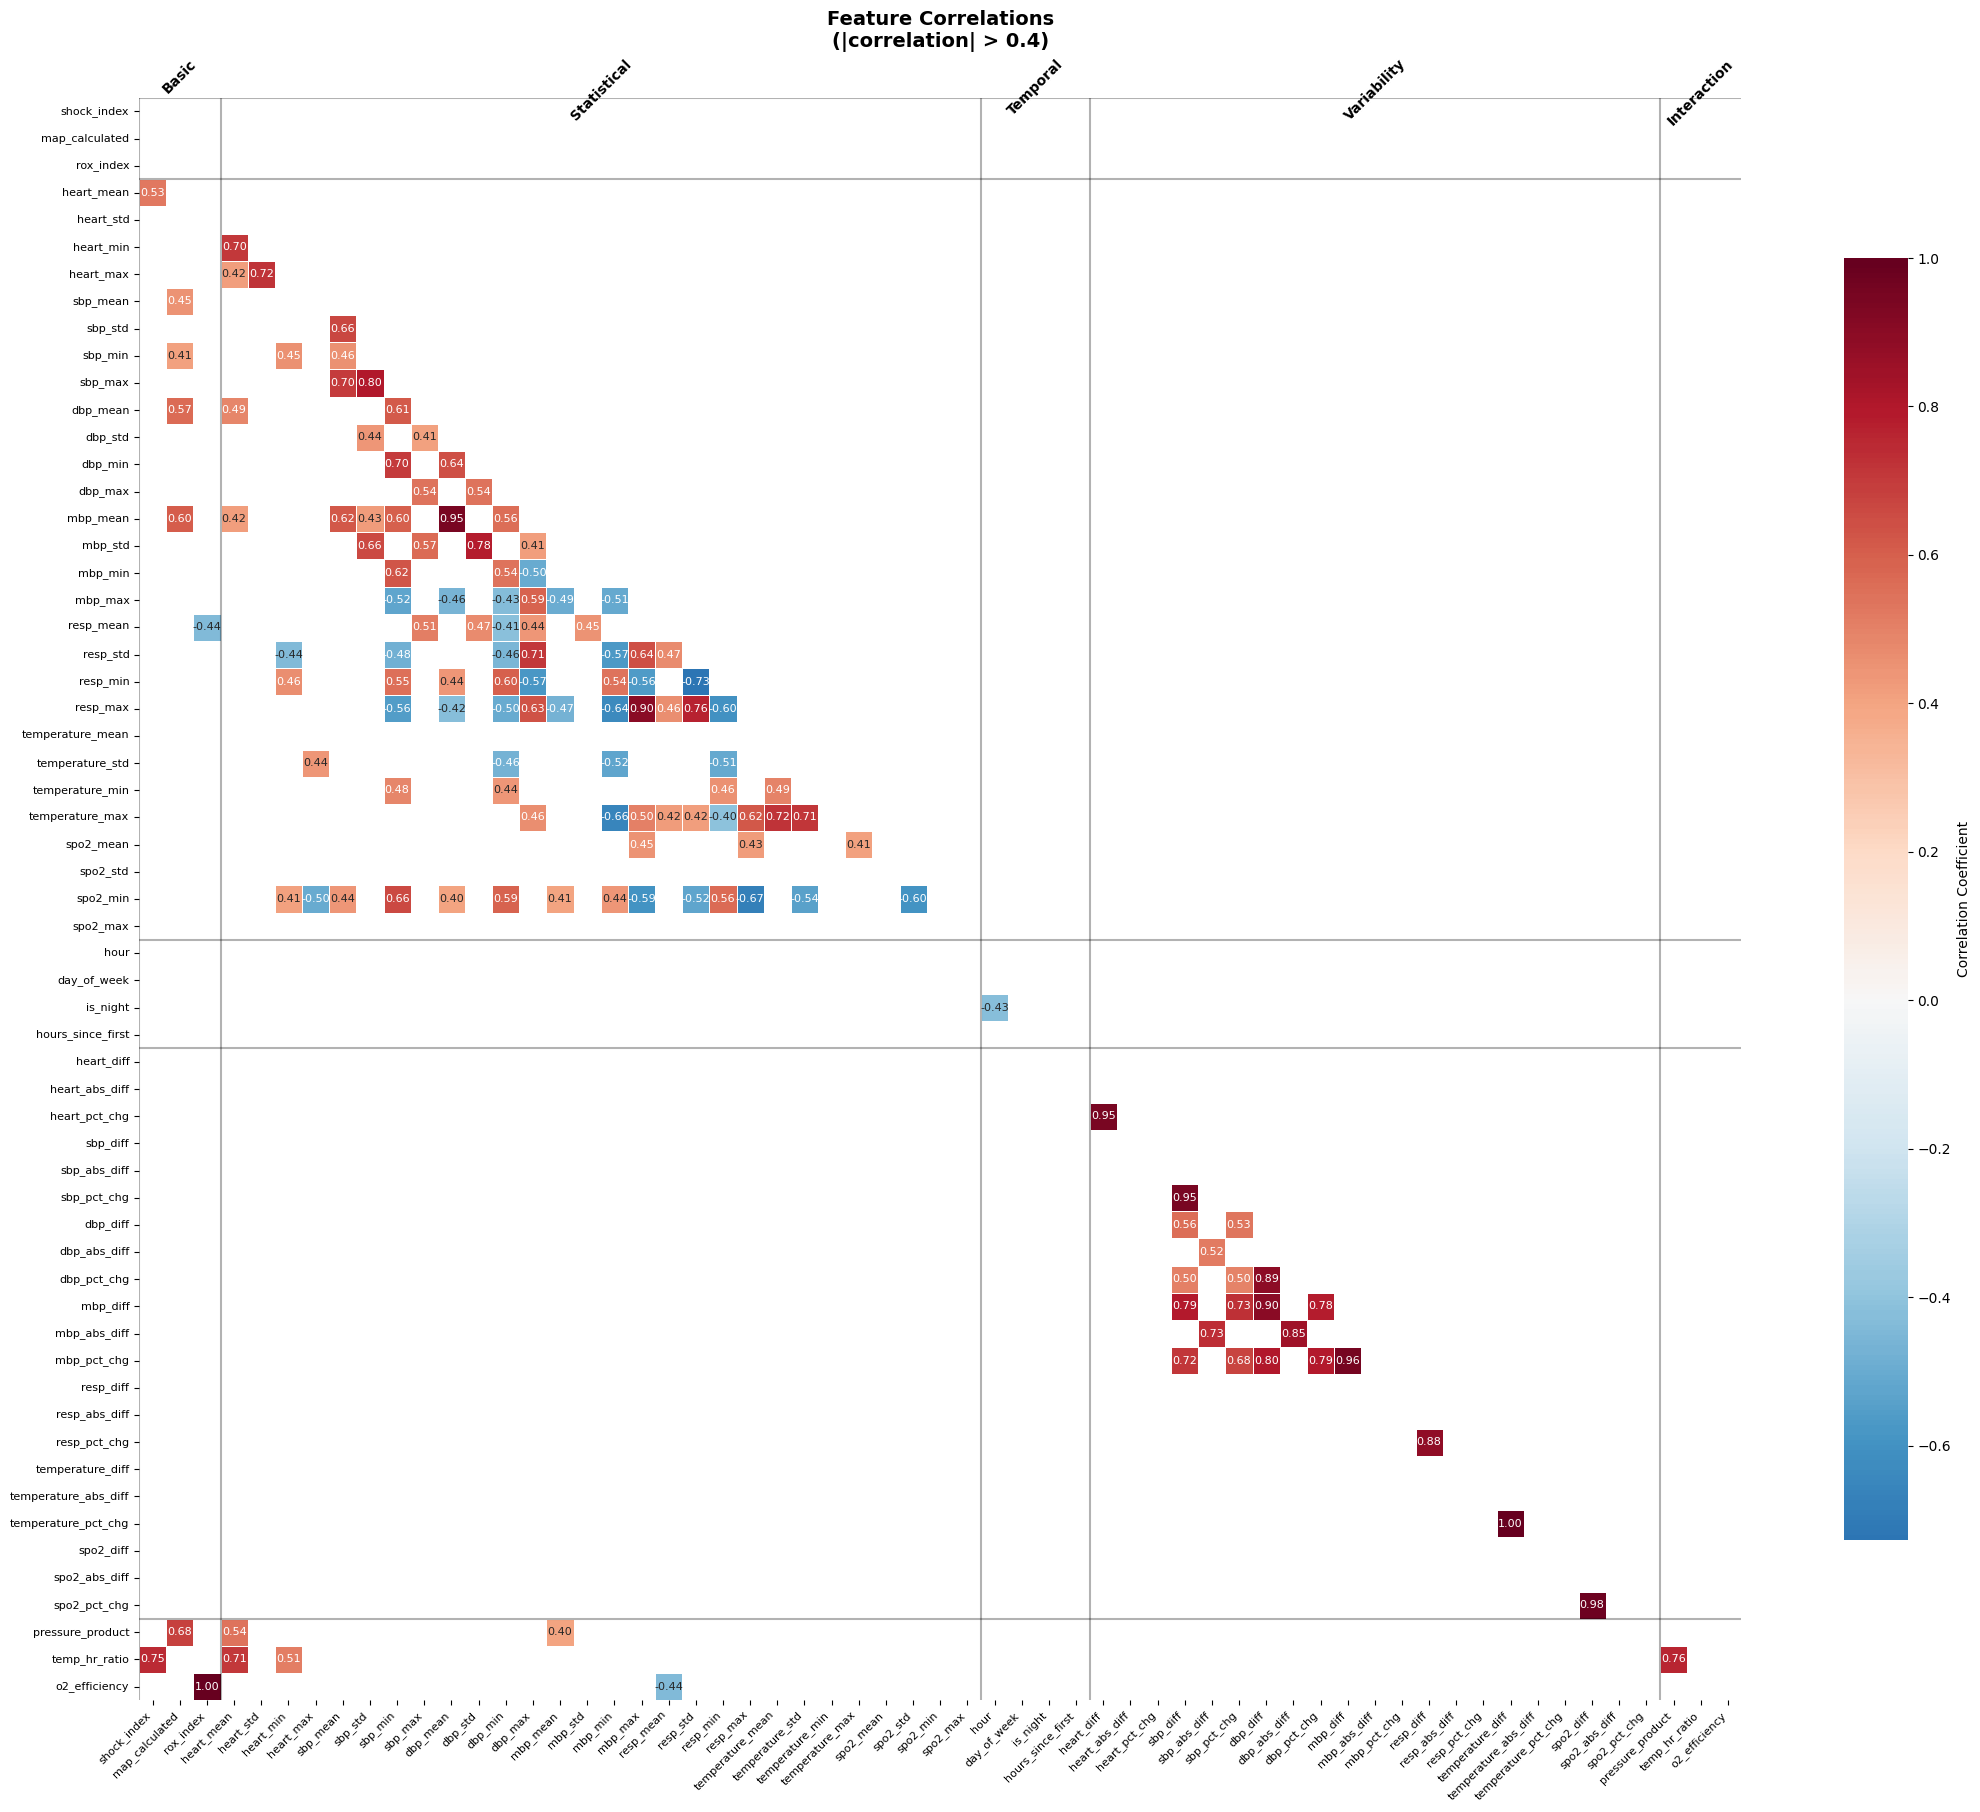

In [37]:
### plot_feature_correlations_r2; revised correlation, further tweaks for visual readability...
def plot_feature_correlations_r2(df, feature_types, threshold=0.4, figsize=(22, 18)):
    """
    Plot correlation heatmap with improved readability
    """
    # Ensure we have a clean index
    plot_df = df.reset_index(drop=True)
    
    # Get features and organize by type
    feature_map = {}
    for ftype, features in feature_types.items():
        for f in features:
            if f in plot_df.columns:
                # Simplify feature names for readability
                simple_name = f.replace('_rate', '').replace('_change', '_chg')
                feature_map[f] = {'type': ftype, 'simple_name': simple_name}
    
    # Calculate correlation matrix
    corr_matrix = plot_df[list(feature_map.keys())].corr()
    
    # Create figure with larger size
    plt.figure(figsize=figsize)
    
    # Mask setup
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True  # Mask upper triangle
    mask |= np.abs(corr_matrix) < threshold  # Mask low correlations
    
    # Custom annotation function to improve readability
    def annotation_formatter(val):
        if np.abs(val) >= threshold:
            return f'{val:.2f}'
        return ''
    
    # Create heatmap with improved styling
    sns.heatmap(corr_matrix, 
                mask=mask,
                cmap='RdBu_r',
                center=0,
                annot=True,
                fmt='.2f',
                annot_kws={'size': 8},
                square=True,
                linewidths=0.5,
                cbar_kws={'label': 'Correlation Coefficient',
                         'shrink': 0.8})
    
    # Improve labels
    ax = plt.gca()
    
    # Simplify and rotate labels
    labels = [feature_map[f]['simple_name'] for f in corr_matrix.columns]
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(labels, rotation=0, fontsize=8)
    
    # Add feature type grouping
    type_boundaries = {}
    current_pos = 0
    for ftype in feature_types.keys():
        type_features = [f for f, info in feature_map.items() if info['type'] == ftype]
        if type_features:
            type_boundaries[ftype] = (current_pos, current_pos + len(type_features))
            current_pos += len(type_features)
    
    # Add group separators and labels
    for ftype, (start, end) in type_boundaries.items():
        # Add separating lines
        ax.axvline(x=start, color='black', linewidth=1.5, alpha=0.3)
        ax.axhline(y=start, color='black', linewidth=1.5, alpha=0.3)
        
        # Add group labels
        plt.text(start + (end-start)/2, -1.5, ftype, 
                ha='center', va='top', rotation=45,
                fontsize=10, fontweight='bold')
    
    # Add title with information
    plt.title(f'Feature Correlations\n(|correlation| > {threshold})\n', 
              pad=20, fontsize=14, fontweight='bold')
    
    # Create a summary of strongest correlations
    strong_correlations = []
    for i in range(len(corr_matrix)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= 0.7:  # Threshold for "strong" correlations
                strong_correlations.append({
                    'feature1': labels[i],
                    'feature2': labels[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    
    # Sort by absolute correlation value
    strong_correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)
    
    # Print summary of strongest correlations
    print("\nStrongest Feature Correlations (|correlation| >= 0.7):")
    for corr in strong_correlations[:10]:  # Show top 10
        print(f"{corr['feature1']} ~ {corr['feature2']}: {corr['correlation']:.3f}")
    
    plt.tight_layout()
    plt.show()

### visualize correlations with r2
plot_feature_correlations_r2(feature_df, feature_types, threshold=0.4)

## Model Preparation

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import TimeSeriesSplit
import umap
from sklearn.impute import SimpleImputer

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

d:\Projects\3m-pipeline\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
# Normalization and PCA
def prepare_features(df, feature_types, n_components=0.95): 
    """
    Prepare features for analysis using PCA and standardization
    
    Args:
        df (pd.DataFrame): Input dataframe with engineered features
        feature_types (dict): Dictionary mapping feature types to column names
        n_components (float): Variance ratio to preserve in PCA
    
    Returns:
        tuple: (transformed_features, transformers_dict)
            - transformed_features: PCA-transformed feature matrix
            - transformers_dict: Dictionary containing fitted scaler and PCA objects
    """
    # Get numerical features
    numeric_features = [col for ftype in feature_types.values() for col in ftype 
                       if col in df.columns and df[col].dtype in ['float64', 'int64']]
    
    # Handle missing values (Impute with mean)
    imputer = SimpleImputer(strategy='mean')  # Or 'median' if you prefer
    X_imputed = imputer.fit_transform(df[numeric_features])
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create DataFrame with transformed features
    pca_cols = [f'PC_{i+1}' for i in range(X_pca.shape[1])]
    X_transformed = pd.DataFrame(X_pca, columns=pca_cols, index=df.index)
    
    # Store transformers for later use
    transformers = {
        'scaler': scaler,
        'pca': pca,
        'imputer': imputer  # Add imputer to transformers for later use
    }
    
    return X_transformed, transformers


In [60]:
### Output and visualization functions for clustering
def plot_cluster_analysis(results, figsize=(20, 12)):
    """
    Visualize clustering results with multiple perspectives
    
    Args:
        results (dict): Dictionary containing clustering analysis results
        figsize (tuple): Figure size for plots
    """
    fig = plt.figure(figsize=figsize)
    
    # 1. UMAP plot with clusters
    ax1 = plt.subplot(2, 2, 1)
    scatter = ax1.scatter(
        results['umap_coords'][:, 0], 
        results['umap_coords'][:, 1], 
        c=results['clusters'], 
        cmap='tab10', 
        alpha=0.6
    )
    ax1.set_title('Patient Clusters in UMAP Space')
    plt.colorbar(scatter, ax=ax1)
    
    # 2. Elbow curve
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(results['metrics']['n_clusters'], results['metrics']['inertia'], 'bo-')
    ax2.axvline(x=results['optimal_k'], color='r', linestyle='--', 
                label=f'Optimal k={results["optimal_k"]}')
    ax2.set_title('Cluster Optimization (Elbow Method)')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Inertia')
    ax2.legend()
    
    # 3. Feature importance
    ax3 = plt.subplot(2, 2, 3)
    top_features = results['feature_importance'].nlargest(10)
    ax3.barh(range(len(top_features)), top_features.values)
    ax3.set_yticks(range(len(top_features)))
    ax3.set_yticklabels(top_features.index)
    ax3.set_title('Top 10 Contributing Features')
    
    # 4. Cluster sizes
    ax4 = plt.subplot(2, 2, 4)
    cluster_sizes = pd.Series(results['clusters']).value_counts().sort_index()
    cluster_sizes.plot(kind='bar', ax=ax4)
    ax4.set_title('Cluster Sizes')
    ax4.set_xlabel('Cluster')
    ax4.set_ylabel('Number of Patients')
    
    plt.tight_layout()
    plt.show()

def print_cluster_summary(results):
    """
    Generate clinical interpretation of identified health states
    
    Args:
        results (dict): Dictionary containing clustering analysis results
    
    Prints:
        - Vital sign statistics per cluster
        - Derived clinical metrics
        - Variability measures
        - Population distribution
    """
    cluster_sizes = pd.Series(results['clusters']).value_counts().sort_index()
    profiles = results['cluster_profiles']
    
    # Define vital signs with their statistical features and descriptions
    vital_stats = {
        'heart_rate': {
            'mean': 'Heart Rate (bpm)',
            'std': 'HR Variability',
            'min': 'Minimum HR',
            'max': 'Maximum HR'
        },
        'sbp': {
            'mean': 'Systolic BP (mmHg)',
            'std': 'SBP Variability',
            'min': 'Minimum SBP',
            'max': 'Maximum SBP'
        },
        'resp_rate': {
            'mean': 'Respiratory Rate (bpm)',
            'std': 'RR Variability',
            'min': 'Minimum RR',
            'max': 'Maximum RR'
        },
        'temperature': {
            'mean': 'Temperature (°C)',
            'std': 'Temp Variability',
            'min': 'Minimum Temp',
            'max': 'Maximum Temp'
        },
        'spo2': {
            'mean': 'SpO2 (%)',
            'std': 'SpO2 Variability',
            'min': 'Minimum SpO2',
            'max': 'Maximum SpO2'
        }
    }
    
    # Define derived metrics
    derived_metrics = {
        'shock_index': 'Shock Index',
        'map_calculated': 'Mean Arterial Pressure (mmHg)',
        'rox_index': 'ROX Index',
        'pressure_rate_product': 'Pressure-Rate Product',
        'o2_efficiency': 'O2 Efficiency'
    }
    
    print("\nCluster Clinical Characteristics:")
    for cluster in range(results['optimal_k']):
        print(f"\nCluster {cluster} (n={cluster_sizes[cluster]}):")
        profile = profiles.iloc[cluster]
        
        # Print vital signs statistics
        print("\nVital Signs (mean ± std):")
        for vital, stats in vital_stats.items():
            mean_col = f"{vital}_mean"
            std_col = f"{vital}_std"
            if mean_col in profile.index and std_col in profile.index:
                mean_val = profile[mean_col]
                std_val = profile[std_col]
                if not pd.isna(mean_val) and not pd.isna(std_val):
                    print(f"- {stats['mean']}: {mean_val:.1f} ± {std_val:.1f}")
        
        # Print derived metrics
        print("\nDerived Metrics:")
        for metric, description in derived_metrics.items():
            if metric in profile.index:
                value = profile[metric]
                if not pd.isna(value):
                    print(f"- {description}: {value:.2f}")
        
        # Print variability metrics
        print("\nVariability Metrics:")
        for vital in vital_stats.keys():
            pct_change_col = f"{vital}_pct_change"
            if pct_change_col in profile.index:
                value = profile[pct_change_col]
                if not pd.isna(value):
                    print(f"- {vital.replace('_', ' ').title()} % Change: {value:.1f}%")

In [63]:
### compute_cluster_analysis -> helpers & main controller
def prepare_features_for_clustering(df, feature_types, transformers=None):
    """
    Prepare features for clustering by applying scaling and PCA transformation.
    
    Args:
        df: DataFrame with engineered features
        feature_types: Dictionary of feature categories
        transformers: Fitted transformers (scaler and PCA) or None
    
    Returns:
        Tuple: Transformed features (X_transformed), and transformers (dict)
    """
    # Get numeric features
    numeric_features = [col for ftype in feature_types.values() for col in ftype if col in df.columns and df[col].dtype in ['float64', 'int64']]

    # If transformers are not passed, fit them
    if transformers is None:
        print("Fitting new transformers...")
        # Fit StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df[numeric_features])

        # Fit PCA with desired variance ratio
        pca = PCA(n_components=0.95)
        X_transformed = pca.fit_transform(X_scaled)

        transformers = {'scaler': scaler, 'pca': pca}  # Store the fitted transformers
    else:
        print("Using existing transformers...")
        X_scaled = transformers['scaler'].transform(df[numeric_features])
        X_transformed = transformers['pca'].transform(X_scaled)

    return X_transformed, transformers


### optimize umap
def optimize_umap_for_clustering(X_transformed, n_trials=20):
    """
    Optimize UMAP parameters based on silhouette score.

    Args:
        X_transformed: Transformed feature data
        n_trials: Number of optimization trials

    Returns:
        dict: Best UMAP parameters
        float: Best silhouette score
    """
    print("\nOptimizing UMAP parameters...")
    best_params, best_score = optimize_umap_params(X_transformed, n_trials=n_trials)
    print(f"Best UMAP parameters found: {best_params}")
    print(f"Best silhouette score: {best_score:.3f}")
    
    return best_params, best_score


### apply umap
def apply_umap(X_transformed, best_params):
    """
    Apply UMAP transformation with optimized parameters.

    Args:
        X_transformed: Transformed feature data
        best_params: Best UMAP parameters

    Returns:
        np.ndarray: UMAP-transformed feature data
    """
    print("\nApplying UMAP transformation...")
    reducer = umap.UMAP(**best_params, random_state=42)
    X_umap = reducer.fit_transform(X_transformed)
    
    return X_umap

### optimize clustering
def find_optimal_clusters(X_umap, n_clusters_max=8):
    """
    Find the optimal number of clusters for the UMAP-transformed data.

    Args:
        X_umap: UMAP-transformed feature data
        n_clusters_max: Maximum number of clusters to test

    Returns:
        int: Optimal number of clusters
        dict: Clustering metrics
    """
    print("\nFinding optimal number of clusters...")
    optimal_k, metrics = optimize_clustering_params(X_umap, max_clusters=n_clusters_max)
    print(f"Optimal number of clusters: {optimal_k}")
    
    return optimal_k, metrics


### finalize clustering
def perform_clustering(X_umap, optimal_k):
    """
    Perform KMeans clustering on the UMAP-transformed data.

    Args:
        X_umap: UMAP-transformed feature data
        optimal_k: Optimal number of clusters

    Returns:
        np.ndarray: Predicted cluster labels
        KMeans: Fitted KMeans model
    """
    print("\nPerforming final clustering...")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(X_umap)
    
    return clusters, kmeans


### compute feature importance
def compute_feature_importance(transformers, feature_df, feature_types):
    """
    Compute the feature importance from the PCA components.

    Args:
        transformers: Fitted scaler and PCA transformers
        feature_df: DataFrame with original features
        feature_types: Dictionary of feature categories

    Returns:
        pd.Series: Absolute sum of PCA component importances
    """
    print("\nComputing feature importance...")
    numeric_features = [col for ftype in feature_types.values() 
                        for col in ftype if col in feature_df.columns 
                        and feature_df[col].dtype in ['float64', 'int64']]
    
    feature_importance = pd.DataFrame(
        transformers['pca'].components_,
        columns=numeric_features
    ).abs().sum()
    
    return feature_importance

### generate cluster profiles
def generate_cluster_profiles(kmeans, transformers, feature_types, numeric_features):
    """
    Generate cluster profiles by inverse transforming the cluster centers.

    Args:
        kmeans: Fitted KMeans model
        transformers: Fitted scaler and PCA transformers
        feature_types: Dictionary of feature categories
        numeric_features: List of numeric feature names

    Returns:
        pd.DataFrame: DataFrame of cluster profiles
    """
    print("\nGenerating cluster profiles...")
    cluster_centers_pca = kmeans.cluster_centers_

    # Check if the cluster centers match the number of PCA components
    if cluster_centers_pca.shape[1] == transformers['pca'].n_components_:
        cluster_centers_scaled = transformers['pca'].inverse_transform(cluster_centers_pca)
        cluster_centers_original = transformers['scaler'].inverse_transform(cluster_centers_scaled)

        # Generate cluster profiles
        cluster_profiles = pd.DataFrame(
            cluster_centers_original,
            columns=numeric_features
        )
    else:
        print("Error: Mismatch in number of PCA components.")
        cluster_profiles = None
    
    return cluster_profiles

    # Compute clustering analysis results
    
    # Args:
    #     feature_df: DataFrame with engineered features
    #     feature_types: Dictionary of feature categories
    #     transformers: Dict containing fitted scaler and PCA
    #     n_clusters_max: Maximum number of clusters to try
    
    # Returns:
    #     dict: Results containing all computed values
    # """
    # print("Starting cluster analysis...")
    
    # # 1. Prepare features
    # if transformers is None:
    #     print("Preparing new features...")
    #     X_transformed, transformers = prepare_features(feature_df, feature_types)
    # else:
    #     print("Using existing transformers...")
    #     numeric_features = [col for ftype in feature_types.values() 
    #                       for col in ftype if col in feature_df.columns 
    #                       and feature_df[col].dtype in ['float64', 'int64']]
    #     X_scaled = transformers['scaler'].transform(feature_df[numeric_features])
    #     X_transformed = transformers['pca'].transform(X_scaled)
    
    # print(f"Working with {X_transformed.shape[1]} principal components")
    
    # # 2. Optimize UMAP parameters using existing function
    # print("\nOptimizing UMAP parameters...")
    # best_params, best_score = optimize_umap_params(X_transformed, n_trials=20)
    # print(f"Best UMAP parameters found: {best_params}")
    # print(f"Best silhouette score: {best_score:.3f}")
    
    # # 3. Apply UMAP with best parameters
    # print("\nApplying UMAP transformation...")
    # reducer = umap.UMAP(**best_params, random_state=42)
    # X_umap = reducer.fit_transform(X_transformed)
    
    # # 4. Find optimal clusters
    # print("\nFinding optimal number of clusters...")
    # optimal_k, metrics = optimize_clustering_params(X_umap, max_clusters=n_clusters_max)
    # print(f"Optimal number of clusters: {optimal_k}")
    
    # # 5. Final clustering
    # print("\nPerforming final clustering...")
    # kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    # clusters = kmeans.fit_predict(X_umap)
    
    # # 6. Compute feature importance
    # print("\nComputing feature importance...")
    # numeric_features = [col for ftype in feature_types.values() 
    #                    for col in ftype if col in feature_df.columns 
    #                    and feature_df[col].dtype in ['float64', 'int64']]
    
    # feature_importance = pd.DataFrame(
    #     transformers['pca'].components_,
    #     columns=numeric_features
    # ).abs().sum()
    
    # # 7. Compute cluster profiles
    # print("\nGenerating cluster profiles...")
    
    # # Ensure the number of components matches
    # cluster_centers_pca = kmeans.cluster_centers_
    
    # if cluster_centers_pca.shape[1] == transformers['pca'].n_components_:
    #     cluster_centers_scaled = transformers['pca'].inverse_transform(cluster_centers_pca)
    #     cluster_centers_original = transformers['scaler'].inverse_transform(cluster_centers_scaled)
        
    #     cluster_profiles = pd.DataFrame(
    #         cluster_centers_original,
    #         columns=numeric_features
    #     )
    # else:
    #     raise ValueError("Mismatch in number of PCA components. Check PCA fitting and clustering steps.")
    
    # print("\nAnalysis complete!")
    
    # return {
    #     'clusters': clusters,
    #     'umap_coords': X_umap,
    #     'cluster_profiles': cluster_profiles,
    #     'metrics': metrics,
    #     'optimal_k': optimal_k,
    #     'feature_importance': feature_importance,
    #     'best_umap_params': best_params,
    #     'best_umap_score': best_score,
    #     'transformers': transformers,  # Include transformers in results
    #     'numeric_features': numeric_features  # Include feature list for reference
    # }

In [64]:
### run_cluster_analysis; organize and progressively call previous cluster functions
def run_cluster_analysis(feature_df, feature_types, transformers=None, n_clusters_max=8):
    """
    Compute clustering analysis results
    """
    print("Starting cluster analysis...")
    
    # 1. Prepare features
    if transformers is None:
        print("Preparing new features...")
        X_transformed, transformers = prepare_features(feature_df, feature_types)
    else:
        print("Using existing transformers...")
        numeric_features = [col for ftype in feature_types.values() 
                          for col in ftype if col in feature_df.columns 
                          and feature_df[col].dtype in ['float64', 'int64']]
        X_scaled = transformers['scaler'].transform(feature_df[numeric_features])
        X_transformed = transformers['pca'].transform(X_scaled)
    
    print(f"Working with {X_transformed.shape[1]} principal components")
    
    # 2. UMAP transformation for visualization
    print("\nOptimizing UMAP parameters...")
    best_params, best_score = optimize_umap_params(X_transformed, n_trials=20)
    print(f"Best UMAP parameters found: {best_params}")
    
    reducer = umap.UMAP(**best_params, random_state=42)
    X_umap = reducer.fit_transform(X_transformed)
    
    # 3. Find optimal number of clusters
    print("\nFinding optimal number of clusters...")
    optimal_k, metrics = optimize_clustering_params(X_umap, max_clusters=n_clusters_max)
    print(f"Optimal number of clusters: {optimal_k}")
    
    # 4. Perform clustering on original PCA space
    print("\nPerforming clustering in PCA space...")
    kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans_pca.fit_predict(X_transformed)
    
    # 5. Compute feature importance
    print("\nComputing feature importance...")
    numeric_features = [col for ftype in feature_types.values() 
                       for col in ftype if col in feature_df.columns 
                       and feature_df[col].dtype in ['float64', 'int64']]
    
    feature_importance = pd.DataFrame(
        transformers['pca'].components_,
        columns=numeric_features
    ).abs().sum()
    
    # 6. Generate cluster profiles using PCA space centers
    print("\nGenerating cluster profiles...")
    cluster_centers_pca = kmeans_pca.cluster_centers_  # Using PCA space centers
    cluster_centers_scaled = transformers['pca'].inverse_transform(cluster_centers_pca)
    cluster_centers_original = transformers['scaler'].inverse_transform(cluster_centers_scaled)
    
    cluster_profiles = pd.DataFrame(
        cluster_centers_original,
        columns=numeric_features
    )
    
    print("\nAnalysis complete!")
    
    return {
        'clusters': clusters,
        'umap_coords': X_umap,
        'cluster_profiles': cluster_profiles,
        'metrics': metrics,
        'optimal_k': optimal_k,
        'feature_importance': feature_importance,
        'best_umap_params': best_params,
        'best_umap_score': best_score,
        'transformers': transformers,
        'numeric_features': numeric_features
    }


Computing cluster analysis...
Starting cluster analysis...
Preparing new features...
Working with 35 principal components

Optimizing UMAP parameters...


d:\Projects\3m-pipeline\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Projects\3m-pipeline\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
d:\Projects\3m-pipeline\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Projects\3m-pipeline\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
d:\Projects\3m-pipeline\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Projects\3m-pipeline\venv\Lib\site-packages\u

Best UMAP parameters found: {'n_neighbors': np.int64(20), 'min_dist': np.float64(0.1), 'metric': np.str_('cosine')}


d:\Projects\3m-pipeline\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Projects\3m-pipeline\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Finding optimal number of clusters...
Optimal number of clusters: 3

Performing clustering in PCA space...

Computing feature importance...

Generating cluster profiles...

Analysis complete!


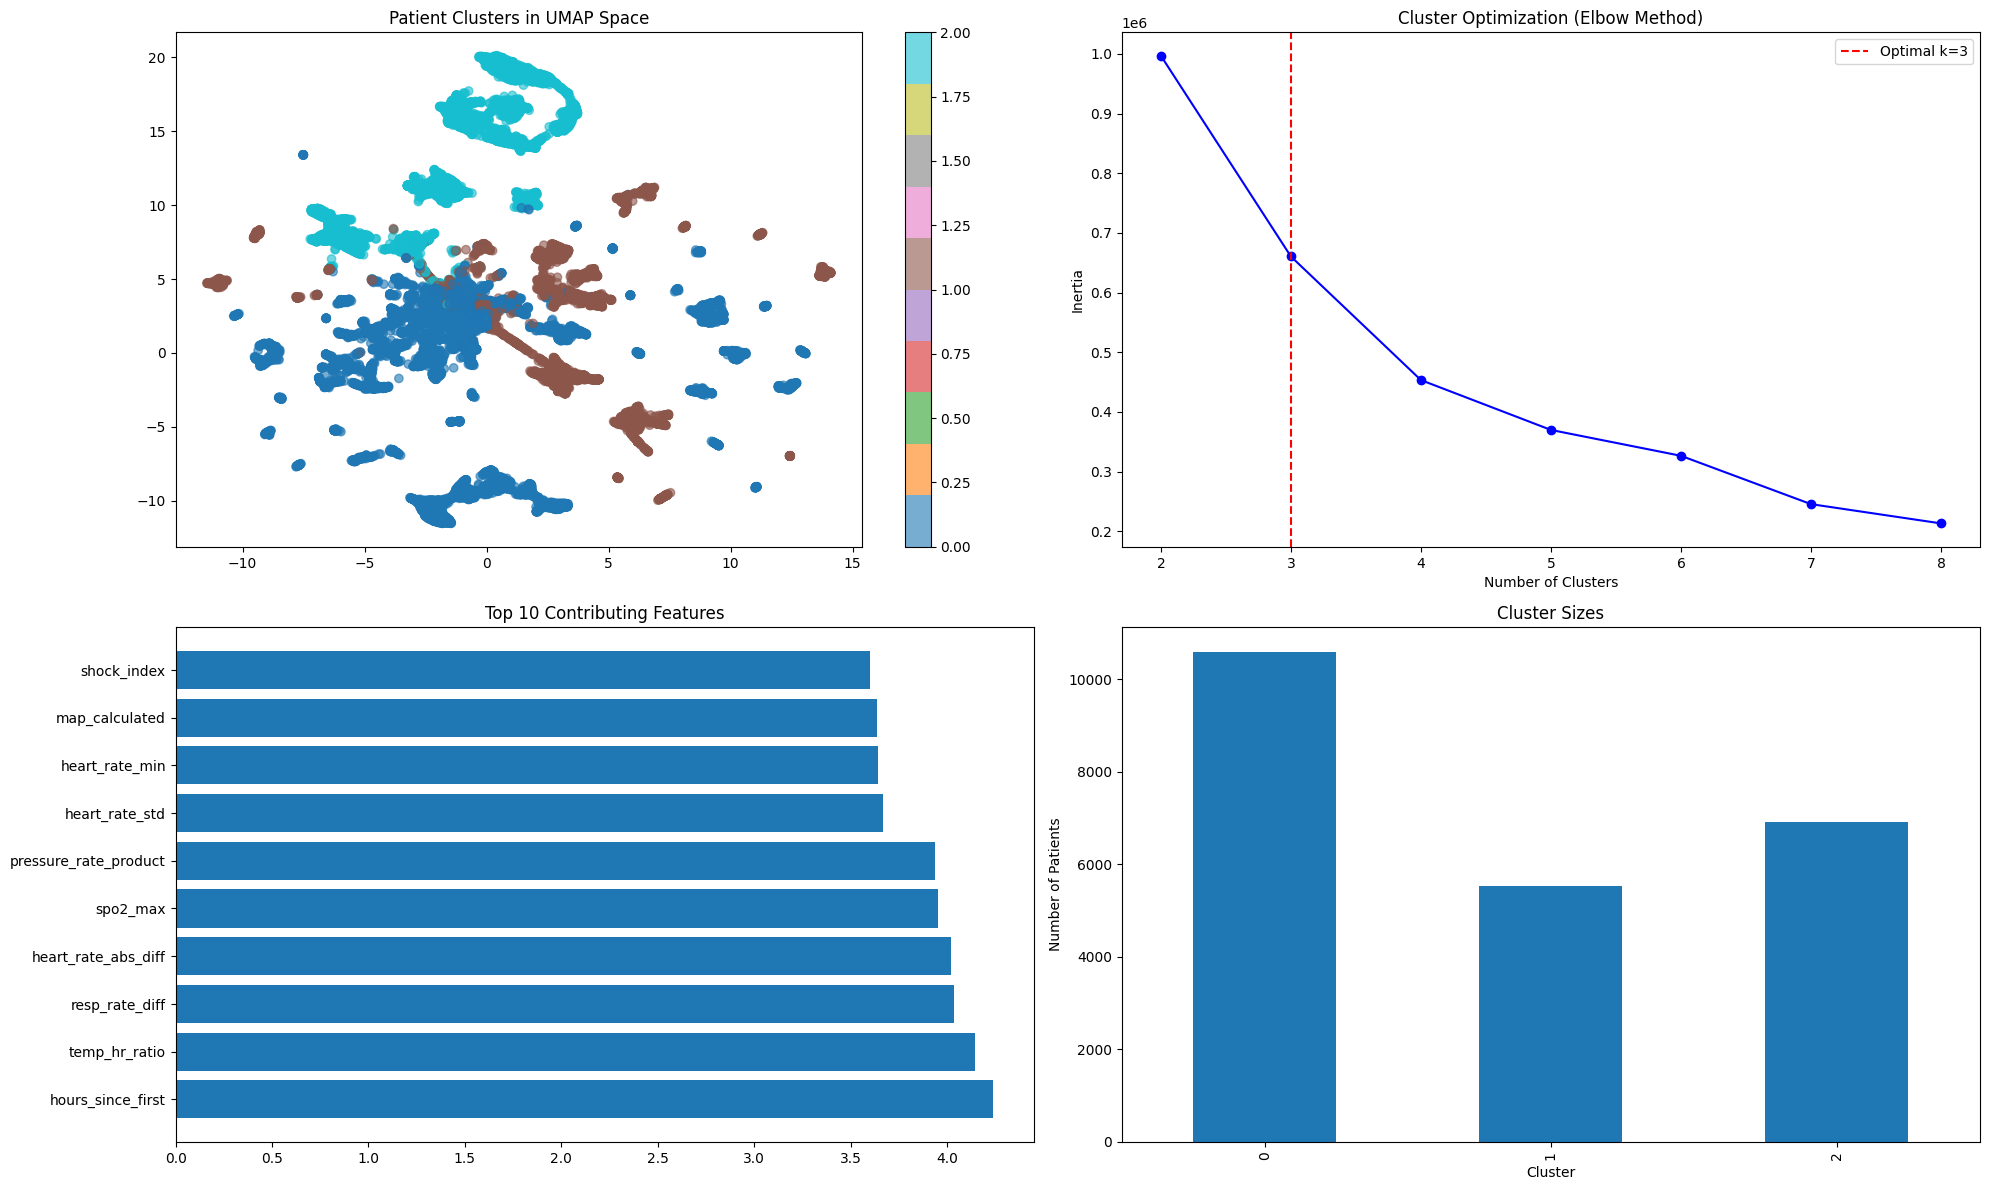


Cluster Clinical Characteristics:

Cluster 0 (n=10588):
Key Vitals (mean values):

Cluster 1 (n=5524):
Key Vitals (mean values):

Cluster 2 (n=6903):
Key Vitals (mean values):


In [52]:
print("Computing cluster analysis...")
cluster_results = run_cluster_analysis(
    feature_df, 
    feature_types,
    transformers=None
)


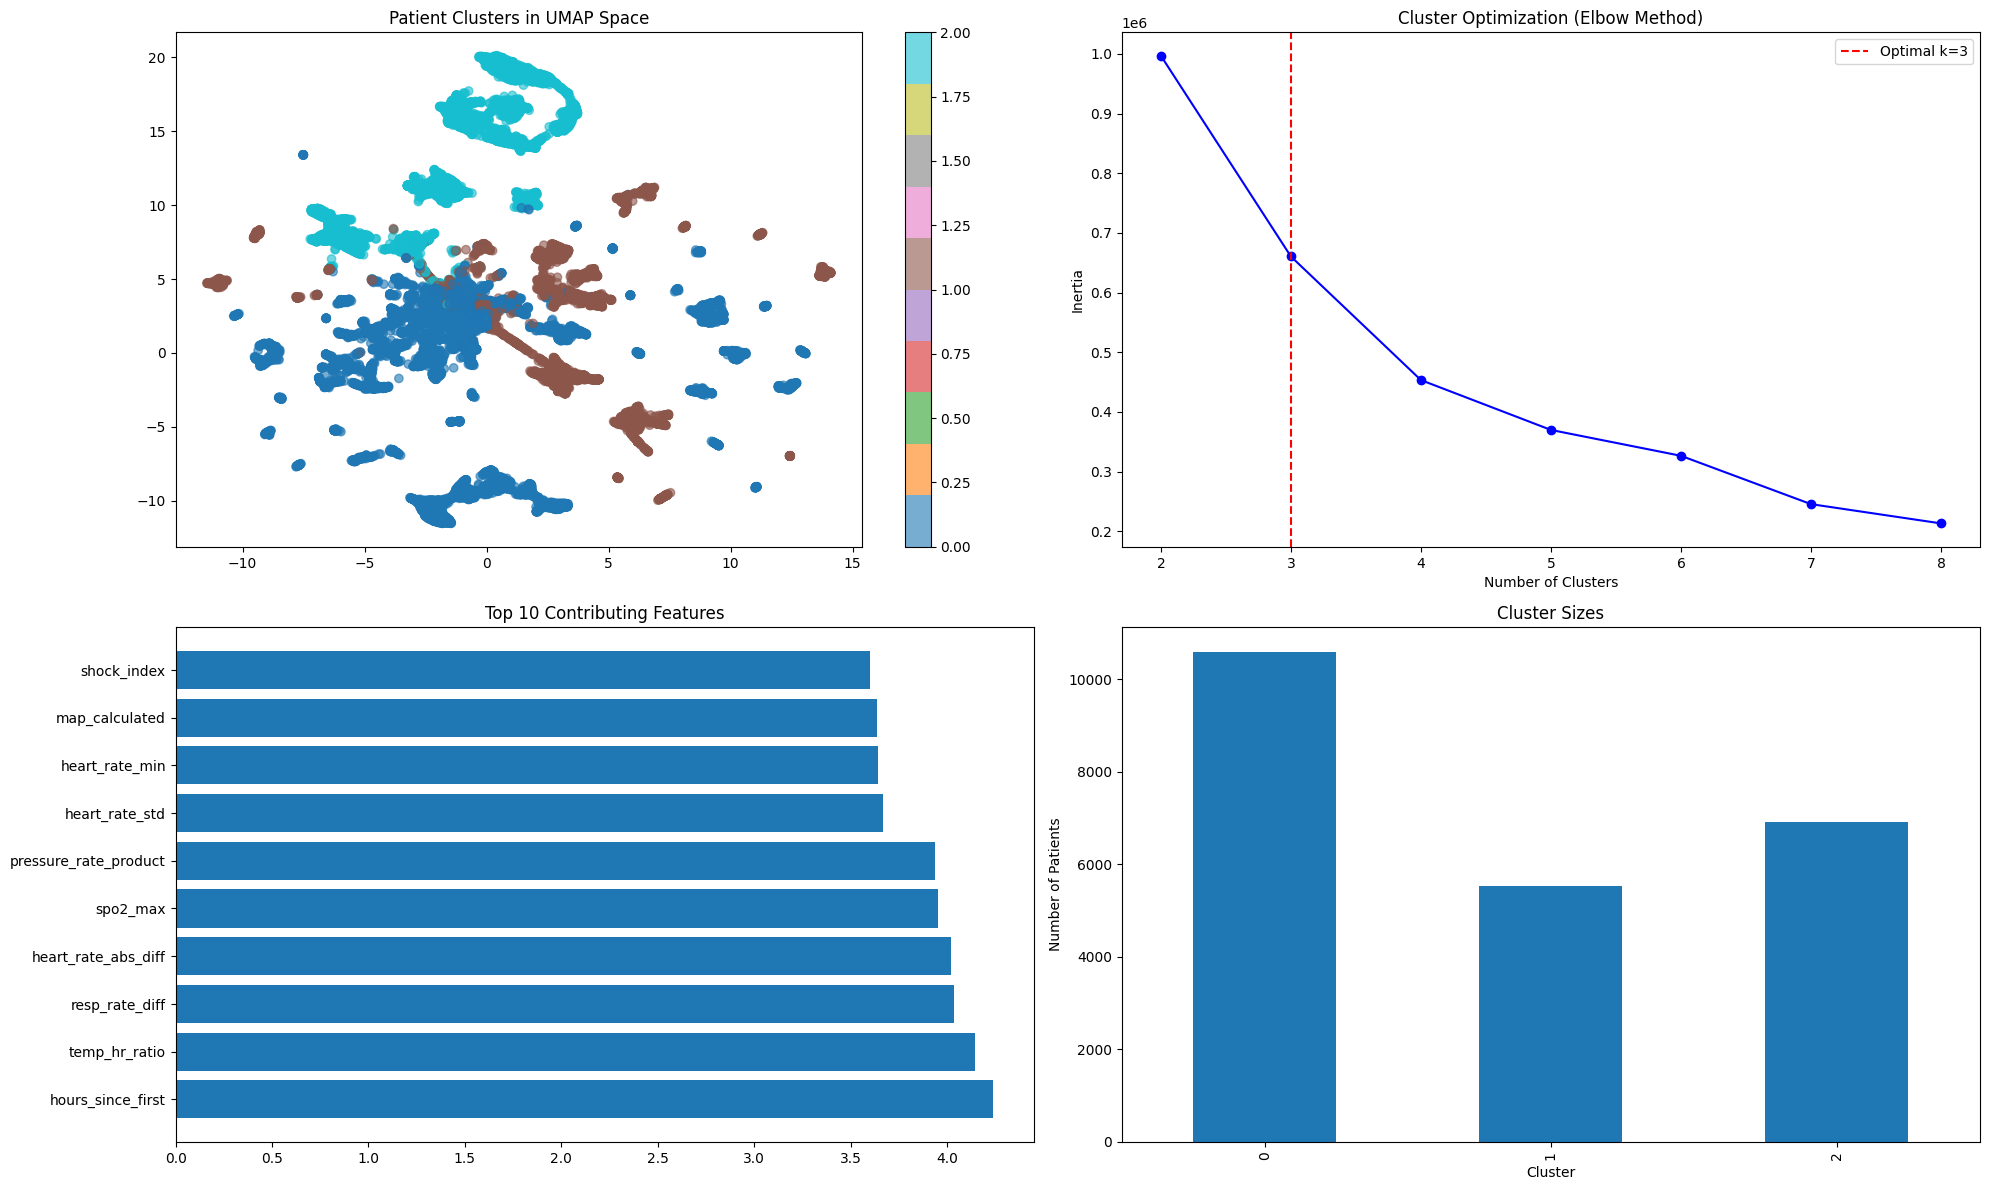


Cluster Clinical Characteristics:

Cluster 0 (n=10588):

Vital Signs (mean ± std):
- Heart Rate (bpm): 86.0 ± 11.1
- Systolic BP (mmHg): 118.6 ± 14.3
- Respiratory Rate (bpm): 18.7 ± 3.9
- Temperature (°C): 37.0 ± 0.5
- SpO2 (%): 97.0 ± 2.2

Derived Metrics:
- Shock Index: 0.71
- Mean Arterial Pressure (mmHg): 82.38
- ROX Index: 5.25
- Pressure-Rate Product: 10040.42
- O2 Efficiency: 5.25

Variability Metrics:
- Heart Rate % Change: 0.0%
- Sbp % Change: 0.0%
- Resp Rate % Change: 0.0%
- Temperature % Change: 0.0%
- Spo2 % Change: 0.0%

Cluster 1 (n=5524):

Vital Signs (mean ± std):
- Heart Rate (bpm): 92.6 ± 14.8
- Systolic BP (mmHg): 128.9 ± 20.0
- Respiratory Rate (bpm): 23.3 ± 5.2
- Temperature (°C): 37.0 ± 0.5
- SpO2 (%): 96.9 ± 2.8

Derived Metrics:
- Shock Index: 0.73
- Mean Arterial Pressure (mmHg): 87.88
- ROX Index: 4.56
- Pressure-Rate Product: 11093.76
- O2 Efficiency: 4.56

Variability Metrics:
- Heart Rate % Change: 0.0%
- Sbp % Change: 0.0%
- Resp Rate % Change: 0.0%
- T

In [59]:
### Visualize results
plot_cluster_analysis(cluster_results)
print_cluster_summary(cluster_results)
